# MVI
## Graph Neural Networks
### Binary classification model in Cheminformatics
Jozef Fulop

# Load Libraries

In [1]:
# Standard libraries
import os
import json
import pickle
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated') # Known issue with PyTorch and DGL

# Data handling
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Machine learning and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.cluster import HDBSCAN

# Neural Networks and Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Graph Neural Networks
import dgl
import dgl.nn as dglnn
from dgl import batch
from dgl.data.utils import save_graphs, load_graphs

# Cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from dgllife.utils import mol_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer

# Network analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


check if GPU is aviable and the device

In [2]:
import torch
print("PyTorch version:", torch.__version__)
print("Is CUDA Supported?", torch.cuda.is_available())

PyTorch version: 2.1.2
Is CUDA Supported? True


In [3]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0)

(True, 1, 'Tesla T4')

# Data Preprocessing

load dataset

In [4]:
# load json data from data_mvi folder
chemdiv = pd.read_json('data_mvi/chemdiv_df.json')
enamine = pd.read_json('data_mvi/enamine_df.json')
enmine_protein = pd.read_json('data_mvi/enamine_protein_df.json')
life_chemicals = pd.read_json('data_mvi/life_chemicals_df.json')
robin = pd.read_json('data_mvi/robin_df.json')

add source column

In [5]:
# add 'source column'
chemdiv['source'] = 'chemdiv'
enamine['source'] = 'enamine'
enmine_protein['source'] = 'enmine_protein'
life_chemicals['source'] = 'life_chemicals'
robin['source'] = 'robin'

In [6]:
robin.shape

(1991, 4)

compute fingerprings for algorithms

In [7]:
# combine all dataframes
df = pd.concat([chemdiv, enamine, enmine_protein, life_chemicals, robin], ignore_index=True)
# delte 'mol' column and ECFp6 column
df = df.drop(['mol', 'ECFP6'], axis=1)

# create 'mol' column and use SMILES column to create mol object
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
# create 'ECFP6' column and use mol object to create ECFP6 fingerprint
df['ECFP6'] = df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 3, nBits=2048))


these fingerprints will be further used more in data preprocessing,train and test set selection. (not in this milestone). Dataset was deduplicated before.

In [8]:
# check for duplicates using 'SMILES' column
df.duplicated(subset=['SMILES']).sum()

0

In [9]:
df.head()

source                                             SMILES  \
0  chemdiv  O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...   
1  chemdiv  O=C(CSc1nnc(-c2ccccc2Cl)n1-c1ccccc1)c1ccc2c(c1...   
2  chemdiv  Cc1ccc(-n2c(=O)c3c4c(sc3n3c(SCC(=O)c5ccccc5)nn...   
3  chemdiv  O=C(Nc1ccc(C(=O)c2ccccc2)cc1)c1ccc(Oc2ccc(C(=O...   
4  chemdiv  O=C(Nc1ccc(Oc2cccc(Oc3ccc(NC(=O)c4ccccc4Cl)cc3...   

                                                mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x7fdca1263970>   
1  <rdkit.Chem.rdchem.Mol object at 0x7fdca12636d0>   
2  <rdkit.Chem.rdchem.Mol object at 0x7fdca1263820>   
3  <rdkit.Chem.rdchem.Mol object at 0x7fdca1263740>   
4  <rdkit.Chem.rdchem.Mol object at 0x7fdca1263a50>   

                                               ECFP6  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  
4  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...

create column for labels, if 'rna' == 1 - molecule binds to the RNA, else - Protein

In [10]:
# create 'rna' column and if in column 'source' is 'enmine_protein' set 'rna' to 0 else 1
df['rna'] = df['source'].apply(lambda x: 0 if x == 'enmine_protein' else 1)

In [11]:
df.shape

(493078, 5)

dataset is unbalanced - creating balanced dataset - undersampling majority class (just for now, in near future more sofisticated approaches will be used - clustering)

In [12]:
chemdiv.shape, enamine.shape, enmine_protein.shape, life_chemicals.shape, robin.shape

((19912, 4), (11080, 4), (456141, 4), (3954, 4), (1991, 4))

In [13]:
# divide data back to 5 dataframes
chemdiv = df[df['source'] == 'chemdiv']
enamine = df[df['source'] == 'enamine']
enmine_protein = df[df['source'] == 'enmine_protein']
life_chemicals = df[df['source'] == 'life_chemicals']
robin = df[df['source'] == 'robin']

rna_df = pd.concat([chemdiv, enamine, life_chemicals, robin], ignore_index=True)

rna_df.shape

(36937, 5)

In [14]:
enmine_protein.head()

source                                           SMILES  \
30992  enmine_protein       CCc1nn(C)cc1NC(=O)c1cnn(CC(=O)NC2CCCCC2)c1   
30993  enmine_protein            O=C(Cc1coc2ccccc12)NC1(c2ncon2)CCOCC1   
30994  enmine_protein   CC(C)(C)c1ccc(O)c(NC(=O)c2cccc(Oc3cnccn3)c2)c1   
30995  enmine_protein           CC(NC(=O)Cc1ccc(Cl)s1)(C(N)=O)c1ccccc1   
30996  enmine_protein  COCc1cccc(S(=O)(=O)Nc2cccc(-n3cn[nH]c3=O)c2C)c1   

                                                    mol  \
30992  <rdkit.Chem.rdchem.Mol object at 0x7fdca3644580>   
30993  <rdkit.Chem.rdchem.Mol object at 0x7fdca36445f0>   
30994  <rdkit.Chem.rdchem.Mol object at 0x7fdca3644660>   
30995  <rdkit.Chem.rdchem.Mol object at 0x7fdca36446d0>   
30996  <rdkit.Chem.rdchem.Mol object at 0x7fdca3644740>   

                                                   ECFP6  rna  
30992  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0  
30993  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...    0  
30994  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0  
30995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0  
30996  [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...    0

In [15]:
df.shape

(493078, 5)

sanity check 

In [16]:
# show rows from df with each source so there will be 5 rows and all columns
df.groupby('source').head(1)


source                                             SMILES  \
0              chemdiv  O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...   
19912          enamine  CCOc1ccc(-n2c(-c3ccc(CC)cc3)cn3c4ccc5ccccc5c4n...   
30992   enmine_protein         CCc1nn(C)cc1NC(=O)c1cnn(CC(=O)NC2CCCCC2)c1   
487133  life_chemicals                    CN1CCCN(c2cc(C#N)ccn2)CC1.Cl.Cl   
491087           robin                              CC(=O)c1ccc(Br)c(N)c1   

                                                     mol  \
0       <rdkit.Chem.rdchem.Mol object at 0x7fdca1263970>   
19912   <rdkit.Chem.rdchem.Mol object at 0x7fdca1d16a50>   
30992   <rdkit.Chem.rdchem.Mol object at 0x7fdca3644580>   
487133  <rdkit.Chem.rdchem.Mol object at 0x7fdc76f2feb0>   
491087  <rdkit.Chem.rdchem.Mol object at 0x7fdc7461dc10>   

                                                    ECFP6  rna  
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1  
19912   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1  
30992   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0  
487133  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...    1  
491087  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1

In [17]:
enmine_protein_small = enmine_protein.sample(36937)


In [18]:
# combine all df
df_small = pd.concat([chemdiv, enamine, enmine_protein_small, life_chemicals, robin], ignore_index=True)

In [19]:
df_small.groupby('source').head(1)

source                                             SMILES  \
0             chemdiv  O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...   
19912         enamine  CCOc1ccc(-n2c(-c3ccc(CC)cc3)cn3c4ccc5ccccc5c4n...   
30992  enmine_protein                 CCC1(CO)CCN(S(=O)(=O)N2CCCCCC2)CC1   
67929  life_chemicals                    CN1CCCN(c2cc(C#N)ccn2)CC1.Cl.Cl   
71883           robin                              CC(=O)c1ccc(Br)c(N)c1   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x7fdca1263970>   
19912  <rdkit.Chem.rdchem.Mol object at 0x7fdca1d16a50>   
30992  <rdkit.Chem.rdchem.Mol object at 0x7fdcbedb16d0>   
67929  <rdkit.Chem.rdchem.Mol object at 0x7fdc76f2feb0>   
71883  <rdkit.Chem.rdchem.Mol object at 0x7fdc7461dc10>   

                                                   ECFP6  rna  
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1  
19912  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1  
30992  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0  
67929  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...    1  
71883  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1

In [20]:
df_small['rna'].value_counts()

rna
1    36937
0    36937
Name: count, dtype: int64

## Create Graphs from molecules and add features to nodes (atoms) - mainly one hot encoding , edges (bonds)

In [21]:
def create_graphs_from_dataframe(df):
    graphs = []
    labels = []

    for index, row in df.iterrows():
        mol = row['mol']  # RDKit Mol object
        label = row['rna']  # Binary label

        # Convert RDKit molecule to a bi-directed DGLGraph and featurize
        graph = mol_to_bigraph(mol,
                               node_featurizer=CanonicalAtomFeaturizer(),
                               edge_featurizer=CanonicalBondFeaturizer(),
                               explicit_hydrogens=False)
        graph = dgl.add_self_loop(graph)
        graphs.append(graph)
        labels.append(label)

    return graphs, torch.tensor(labels).unsqueeze(1)

# Create graphs and labels from the DataFrame
graphs, labels = create_graphs_from_dataframe(df_small)

# Now, 'graphs' is a list of DGLGraphs, and 'labels' is a tensor of labels



save graphs - tensors

In [22]:
graph_labels = df_small[['source', 'rna']].to_dict('records')  # Convert relevant columns to a list of dictionaries

# Save the graphs
dgl.save_graphs('data_mvi/molecule_graphs_orig.bin', graphs)

# Save the labels and additional information
with open('graph_labels.json', 'w') as f:
    json.dump(graph_labels, f)


In [23]:
# Load the graphs
loaded_graphs_orig, _ = dgl.load_graphs('data_mvi/molecule_graphs_orig.bin')

# Load the labels and additional information
with open('graph_labels.json', 'r') as f:
    loaded_graph_labels = json.load(f)

# You can now reconstruct a DataFrame or directly use the loaded data
reconstructed_df = pd.DataFrame(loaded_graph_labels)


### Visualization of the graph representation 

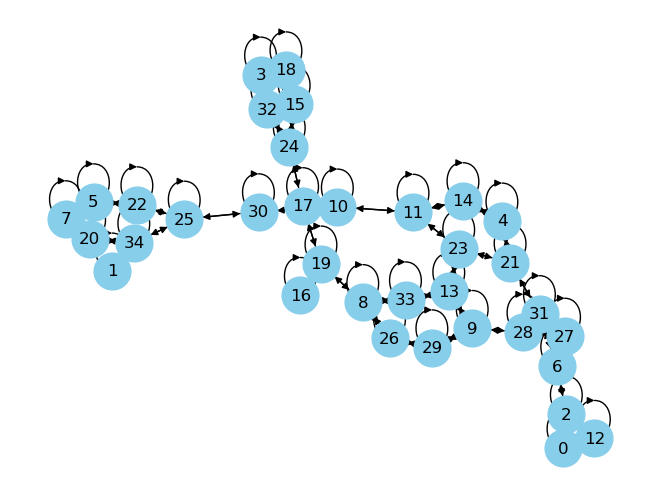

In [24]:
def visualize_dgl_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)  # Convert DGL graph to a NetworkX graph
    pos = nx.spring_layout(g)  # Position nodes using Fruchterman-Reingold force-directed algorithm
    nx.draw(g, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='black')
    plt.show()

# Visualize the first graph in the list
visualize_dgl_graph(loaded_graphs_orig[42])

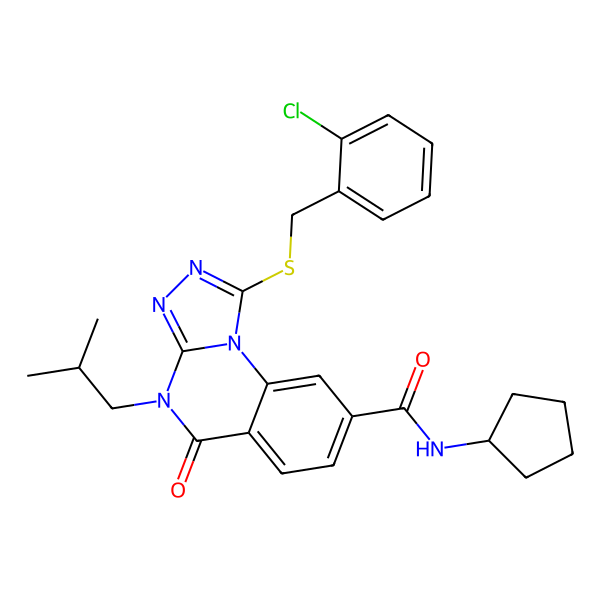

In [25]:

mol = df_small['mol'][42]
AllChem.Compute2DCoords(mol)
# draw the molecule
Draw.MolToImage(mol, size=(600, 600))

# Create train and test set

In [26]:
# First split into training and test sets
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    loaded_graphs_orig, 
    reconstructed_df['rna'], 
    test_size=0.2, 
    random_state=42
)

# Further split the training set into training and validation sets
train_graphs, val_graphs, train_labels, val_labels = train_test_split(
    train_graphs, 
    train_labels, 
    test_size=0.2,  # 20% of the original training set for validation
    random_state=42
)

# merge train and val,  labels are Series
train_graphs_all = train_graphs + val_graphs
train_labels_all = pd.concat([train_labels, val_labels])

there was a problem with few isolated nodes in few graphs so I added loops to each node to have information at least about themselfs

In [27]:
for i, g in enumerate(train_graphs):
    if (g.in_degrees() == 0).any():
        print(f"Graph {i} has isolated nodes")

# if there is not any isolated nodes in train_graphs, print 'No isolated nodes'
print('No isolated nodes')

for i, g in enumerate(test_graphs):
    if (g.in_degrees() == 0).any():
        print(f"Graph {i} has isolated nodes")

# if there is not any isolated nodes in train_graphs, print 'No isolated nodes'
print('No isolated nodes')

No isolated nodes


No isolated nodes


# Graph Convolutional Network Model (GCN)

In [28]:
class GCNClassifier(nn.Module):
    def __init__(self, in_feats, hidden_size):
        super(GCNClassifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, g, features):
        x = F.relu(self.conv1(g, features))
        x = F.relu(self.conv2(g, x))
        g.ndata['h'] = x
        x = dgl.mean_nodes(g, 'h')
        return self.fc(x)


## Instance of the the GCN Model

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
in_feats = train_graphs[0].ndata['h'].shape[1]  # Replace with your feature size
model = GCNClassifier(in_feats, hidden_size=148).to(device)  # hidden_size is set to 74,  num_classes=2

# Loss and optimizer
# criterion = nn.CrossEntropyLoss() 
criterion = nn.BCEWithLogitsLoss()  # Use this loss if you are using a sigmoid activation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



## Train the GCN model

In [30]:
class GraphDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        
        # Reset index if labels is a pandas DataFrame/Series to ensure continuous indexing
        if isinstance(labels, pd.DataFrame) or isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels

    def __len__(self):
        # The lengths of graphs and labels should be the same
        assert len(self.graphs) == len(self.labels), "Graphs and labels must have the same length"
        return len(self.graphs)

    def __getitem__(self, idx):
        try:
            graph = self.graphs[idx]
            label = self.labels[idx]
            return graph, label
        except IndexError:
            print(f"IndexError: Index {idx} out of range for dataset of size {len(self)}")
            raise
        
        

In [31]:
def collate_graphs(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels, dtype=torch.float32)
    return batched_graph, labels



In [32]:
batch_size = 1024
num_workers = 10

# Assuming train_labels and test_labels are originally 1D tensors or lists
# Create the datasets with updated labels
# Create the DataLoader with multiple workers

if isinstance(train_labels, torch.Tensor):
    train_labels = train_labels.tolist()
train_dataset = GraphDataset(train_graphs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_graphs)

if isinstance(test_labels, torch.Tensor):
    test_labels = test_labels.tolist()
test_dataset = GraphDataset(test_graphs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_graphs)

if isinstance(val_labels, torch.Tensor):
    val_labels = val_labels.tolist()
val_dataset = GraphDataset(val_graphs, val_labels)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=collate_graphs)

if isinstance(train_labels_all, torch.Tensor):
    train_labels_all = train_labels_all.tolist()
train_dataset_all = GraphDataset(train_graphs_all, train_labels_all)
train_loader_all = DataLoader(train_dataset_all, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_graphs)



In [33]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        
        # batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)
        batch_labels = batch_labels.clone().detach().to(device)
        batch_features = batch_graphs.ndata['h']

        outputs = model(batch_graphs, batch_features)
        outputs = outputs.squeeze() # remove extra dimension
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)



In [34]:
def validate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    y_true = []
    y_pred = []
    y_pred_proba = []
    with torch.no_grad():
        for graphs, labels in data_loader:
            graphs = graphs.to(device)
            features = graphs.ndata['h'].to(device)
            labels = labels.to(device)
            outputs = model(graphs, features)
            if outputs.dim() == 2 and outputs.shape[0] == 1:
                outputs = outputs.squeeze(0)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Check the dimension of outputs before applying torch.max
            if outputs.dim() > 1:
                _, predicted = torch.max(outputs.data, 1)
            else:
                predicted = outputs.round()  # Assuming binary classification

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(outputs.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss, y_true, y_pred, y_pred_proba



In [35]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.epochs_no_improve = 0
        self.early_stop = False
        self.stopped_epoch = 0  # Attribute to store the epoch number

    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                self.stopped_epoch = epoch  # Store the epoch number



In [36]:
num_epochs = 500
early_stopping = EarlyStopping(patience=20, min_delta=0.002)

# Initialize lists to store loss values
gcn_train_loss_list = []
gcn_val_loss_list = []

for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_loader, criterion, optimizer, device)
    gcn_train_loss_list.append(train_loss)  # Store train loss

    # Validation
    val_loss, _, _, _ = validate(model, val_loader, criterion, device)
    gcn_val_loss_list.append(val_loss)  # Store validation loss

    # Print and check for early stopping
    print(f"Epoch: {epoch+1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
    early_stopping(val_loss, epoch)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


# Store the epoch number when early stopping was triggered
num_epochs_early = early_stopping.stopped_epoch + 1



Epoch: 1, train_loss: 0.6910, val_loss: 0.6881


Epoch: 2, train_loss: 0.6846, val_loss: 0.6809


Epoch: 3, train_loss: 0.6758, val_loss: 0.6706


Epoch: 4, train_loss: 0.6644, val_loss: 0.6588


Epoch: 5, train_loss: 0.6520, val_loss: 0.6480


Epoch: 6, train_loss: 0.6423, val_loss: 0.6391


Epoch: 7, train_loss: 0.6332, val_loss: 0.6311


Epoch: 8, train_loss: 0.6260, val_loss: 0.6245


Epoch: 9, train_loss: 0.6185, val_loss: 0.6185


Epoch: 10, train_loss: 0.6140, val_loss: 0.6143


Epoch: 11, train_loss: 0.6097, val_loss: 0.6107


Epoch: 12, train_loss: 0.6050, val_loss: 0.6076


Epoch: 13, train_loss: 0.6034, val_loss: 0.6056


Epoch: 14, train_loss: 0.6000, val_loss: 0.6031


Epoch: 15, train_loss: 0.5977, val_loss: 0.6014


Epoch: 16, train_loss: 0.5971, val_loss: 0.5996


Epoch: 17, train_loss: 0.5935, val_loss: 0.5981


Epoch: 18, train_loss: 0.5920, val_loss: 0.5968


Epoch: 19, train_loss: 0.5910, val_loss: 0.5952


Epoch: 20, train_loss: 0.5888, val_loss: 0.5938


Epoch: 21, train_loss: 0.5872, val_loss: 0.5925


Epoch: 22, train_loss: 0.5865, val_loss: 0.5912


Epoch: 23, train_loss: 0.5853, val_loss: 0.5900


Epoch: 24, train_loss: 0.5837, val_loss: 0.5887


Epoch: 25, train_loss: 0.5829, val_loss: 0.5876


Epoch: 26, train_loss: 0.5798, val_loss: 0.5864


Epoch: 27, train_loss: 0.5796, val_loss: 0.5853


Epoch: 28, train_loss: 0.5794, val_loss: 0.5840


Epoch: 29, train_loss: 0.5769, val_loss: 0.5837


Epoch: 30, train_loss: 0.5751, val_loss: 0.5819


Epoch: 31, train_loss: 0.5742, val_loss: 0.5809


Epoch: 32, train_loss: 0.5741, val_loss: 0.5798


Epoch: 33, train_loss: 0.5720, val_loss: 0.5793


Epoch: 34, train_loss: 0.5708, val_loss: 0.5779


Epoch: 35, train_loss: 0.5694, val_loss: 0.5773


Epoch: 36, train_loss: 0.5688, val_loss: 0.5769


Epoch: 37, train_loss: 0.5685, val_loss: 0.5751


Epoch: 38, train_loss: 0.5672, val_loss: 0.5750


Epoch: 39, train_loss: 0.5657, val_loss: 0.5737


Epoch: 40, train_loss: 0.5647, val_loss: 0.5731


Epoch: 41, train_loss: 0.5645, val_loss: 0.5716


Epoch: 42, train_loss: 0.5638, val_loss: 0.5706


Epoch: 43, train_loss: 0.5628, val_loss: 0.5697


Epoch: 44, train_loss: 0.5625, val_loss: 0.5688


Epoch: 45, train_loss: 0.5611, val_loss: 0.5680


Epoch: 46, train_loss: 0.5591, val_loss: 0.5670


Epoch: 47, train_loss: 0.5600, val_loss: 0.5668


Epoch: 48, train_loss: 0.5587, val_loss: 0.5654


Epoch: 49, train_loss: 0.5575, val_loss: 0.5646


Epoch: 50, train_loss: 0.5569, val_loss: 0.5637


Epoch: 51, train_loss: 0.5549, val_loss: 0.5628


Epoch: 52, train_loss: 0.5545, val_loss: 0.5618


Epoch: 53, train_loss: 0.5536, val_loss: 0.5610


Epoch: 54, train_loss: 0.5516, val_loss: 0.5607


Epoch: 55, train_loss: 0.5519, val_loss: 0.5593


Epoch: 56, train_loss: 0.5514, val_loss: 0.5591


Epoch: 57, train_loss: 0.5504, val_loss: 0.5578


Epoch: 58, train_loss: 0.5493, val_loss: 0.5569


Epoch: 59, train_loss: 0.5492, val_loss: 0.5564


Epoch: 60, train_loss: 0.5490, val_loss: 0.5554


Epoch: 61, train_loss: 0.5470, val_loss: 0.5548


Epoch: 62, train_loss: 0.5469, val_loss: 0.5540


Epoch: 63, train_loss: 0.5466, val_loss: 0.5538


Epoch: 64, train_loss: 0.5447, val_loss: 0.5522


Epoch: 65, train_loss: 0.5433, val_loss: 0.5517


Epoch: 66, train_loss: 0.5443, val_loss: 0.5517


Epoch: 67, train_loss: 0.5432, val_loss: 0.5503


Epoch: 68, train_loss: 0.5422, val_loss: 0.5503


Epoch: 69, train_loss: 0.5412, val_loss: 0.5488


Epoch: 70, train_loss: 0.5412, val_loss: 0.5481


Epoch: 71, train_loss: 0.5401, val_loss: 0.5474


Epoch: 72, train_loss: 0.5397, val_loss: 0.5468


Epoch: 73, train_loss: 0.5392, val_loss: 0.5460


Epoch: 74, train_loss: 0.5374, val_loss: 0.5454


Epoch: 75, train_loss: 0.5377, val_loss: 0.5456


Epoch: 76, train_loss: 0.5375, val_loss: 0.5441


Epoch: 77, train_loss: 0.5371, val_loss: 0.5436


Epoch: 78, train_loss: 0.5346, val_loss: 0.5430


Epoch: 79, train_loss: 0.5358, val_loss: 0.5424


Epoch: 80, train_loss: 0.5342, val_loss: 0.5427


Epoch: 81, train_loss: 0.5346, val_loss: 0.5412


Epoch: 82, train_loss: 0.5341, val_loss: 0.5408


Epoch: 83, train_loss: 0.5326, val_loss: 0.5411


Epoch: 84, train_loss: 0.5323, val_loss: 0.5397


Epoch: 85, train_loss: 0.5323, val_loss: 0.5391


Epoch: 86, train_loss: 0.5315, val_loss: 0.5386


Epoch: 87, train_loss: 0.5303, val_loss: 0.5380


Epoch: 88, train_loss: 0.5297, val_loss: 0.5375


Epoch: 89, train_loss: 0.5290, val_loss: 0.5373


Epoch: 90, train_loss: 0.5282, val_loss: 0.5368


Epoch: 91, train_loss: 0.5285, val_loss: 0.5360


Epoch: 92, train_loss: 0.5285, val_loss: 0.5356


Epoch: 93, train_loss: 0.5272, val_loss: 0.5352


Epoch: 94, train_loss: 0.5269, val_loss: 0.5347


Epoch: 95, train_loss: 0.5271, val_loss: 0.5346


Epoch: 96, train_loss: 0.5262, val_loss: 0.5337


Epoch: 97, train_loss: 0.5260, val_loss: 0.5333


Epoch: 98, train_loss: 0.5246, val_loss: 0.5328


Epoch: 99, train_loss: 0.5246, val_loss: 0.5324


Epoch: 100, train_loss: 0.5241, val_loss: 0.5329


Epoch: 101, train_loss: 0.5253, val_loss: 0.5315


Epoch: 102, train_loss: 0.5229, val_loss: 0.5313


Epoch: 103, train_loss: 0.5228, val_loss: 0.5309


Epoch: 104, train_loss: 0.5236, val_loss: 0.5309


Epoch: 105, train_loss: 0.5227, val_loss: 0.5301


Epoch: 106, train_loss: 0.5226, val_loss: 0.5295


Epoch: 107, train_loss: 0.5210, val_loss: 0.5293


Epoch: 108, train_loss: 0.5219, val_loss: 0.5287


Epoch: 109, train_loss: 0.5207, val_loss: 0.5285


Epoch: 110, train_loss: 0.5206, val_loss: 0.5280


Epoch: 111, train_loss: 0.5209, val_loss: 0.5279


Epoch: 112, train_loss: 0.5204, val_loss: 0.5273


Epoch: 113, train_loss: 0.5199, val_loss: 0.5269


Epoch: 114, train_loss: 0.5193, val_loss: 0.5266


Epoch: 115, train_loss: 0.5194, val_loss: 0.5263


Epoch: 116, train_loss: 0.5182, val_loss: 0.5260


Epoch: 117, train_loss: 0.5184, val_loss: 0.5260


Epoch: 118, train_loss: 0.5170, val_loss: 0.5253


Epoch: 119, train_loss: 0.5172, val_loss: 0.5252


Epoch: 120, train_loss: 0.5161, val_loss: 0.5246


Epoch: 121, train_loss: 0.5172, val_loss: 0.5243


Epoch: 122, train_loss: 0.5155, val_loss: 0.5241


Epoch: 123, train_loss: 0.5165, val_loss: 0.5238


Epoch: 124, train_loss: 0.5161, val_loss: 0.5234


Epoch: 125, train_loss: 0.5151, val_loss: 0.5249


Epoch: 126, train_loss: 0.5153, val_loss: 0.5230


Epoch: 127, train_loss: 0.5152, val_loss: 0.5231


Epoch: 128, train_loss: 0.5152, val_loss: 0.5223


Epoch: 129, train_loss: 0.5146, val_loss: 0.5221


Epoch: 130, train_loss: 0.5143, val_loss: 0.5222


Epoch: 131, train_loss: 0.5139, val_loss: 0.5214


Epoch: 132, train_loss: 0.5136, val_loss: 0.5212


Epoch: 133, train_loss: 0.5149, val_loss: 0.5212


Epoch: 134, train_loss: 0.5136, val_loss: 0.5206


Epoch: 135, train_loss: 0.5128, val_loss: 0.5202


Epoch: 136, train_loss: 0.5131, val_loss: 0.5200


Epoch: 137, train_loss: 0.5111, val_loss: 0.5202


Epoch: 138, train_loss: 0.5117, val_loss: 0.5195


Epoch: 139, train_loss: 0.5119, val_loss: 0.5191


Epoch: 140, train_loss: 0.5108, val_loss: 0.5188


Epoch: 141, train_loss: 0.5121, val_loss: 0.5187


Epoch: 142, train_loss: 0.5104, val_loss: 0.5183


Epoch: 143, train_loss: 0.5103, val_loss: 0.5181


Epoch: 144, train_loss: 0.5117, val_loss: 0.5178


Epoch: 145, train_loss: 0.5105, val_loss: 0.5183


Epoch: 146, train_loss: 0.5104, val_loss: 0.5172


Epoch: 147, train_loss: 0.5095, val_loss: 0.5179


Epoch: 148, train_loss: 0.5104, val_loss: 0.5172


Epoch: 149, train_loss: 0.5082, val_loss: 0.5167


Epoch: 150, train_loss: 0.5087, val_loss: 0.5180


Epoch: 151, train_loss: 0.5075, val_loss: 0.5159


Epoch: 152, train_loss: 0.5083, val_loss: 0.5155


Epoch: 153, train_loss: 0.5075, val_loss: 0.5152


Epoch: 154, train_loss: 0.5070, val_loss: 0.5155


Epoch: 155, train_loss: 0.5077, val_loss: 0.5147


Epoch: 156, train_loss: 0.5063, val_loss: 0.5147


Epoch: 157, train_loss: 0.5066, val_loss: 0.5144


Epoch: 158, train_loss: 0.5055, val_loss: 0.5139


Epoch: 159, train_loss: 0.5064, val_loss: 0.5136


Epoch: 160, train_loss: 0.5054, val_loss: 0.5143


Epoch: 161, train_loss: 0.5058, val_loss: 0.5137


Epoch: 162, train_loss: 0.5049, val_loss: 0.5132


Epoch: 163, train_loss: 0.5053, val_loss: 0.5131


Epoch: 164, train_loss: 0.5039, val_loss: 0.5123


Epoch: 165, train_loss: 0.5056, val_loss: 0.5126


Epoch: 166, train_loss: 0.5052, val_loss: 0.5118


Epoch: 167, train_loss: 0.5037, val_loss: 0.5117


Epoch: 168, train_loss: 0.5045, val_loss: 0.5112


Epoch: 169, train_loss: 0.5038, val_loss: 0.5119


Epoch: 170, train_loss: 0.5039, val_loss: 0.5106


Epoch: 171, train_loss: 0.5021, val_loss: 0.5111


Epoch: 172, train_loss: 0.5026, val_loss: 0.5105


Epoch: 173, train_loss: 0.5018, val_loss: 0.5105


Epoch: 174, train_loss: 0.5017, val_loss: 0.5102


Epoch: 175, train_loss: 0.5009, val_loss: 0.5096


Epoch: 176, train_loss: 0.5017, val_loss: 0.5093


Epoch: 177, train_loss: 0.5006, val_loss: 0.5098


Epoch: 178, train_loss: 0.5021, val_loss: 0.5093


Epoch: 179, train_loss: 0.5010, val_loss: 0.5103


Epoch: 180, train_loss: 0.5021, val_loss: 0.5081


Epoch: 181, train_loss: 0.4999, val_loss: 0.5079


Epoch: 182, train_loss: 0.4994, val_loss: 0.5077


Epoch: 183, train_loss: 0.5002, val_loss: 0.5079


Epoch: 184, train_loss: 0.4992, val_loss: 0.5114


Epoch: 185, train_loss: 0.4996, val_loss: 0.5070


Epoch: 186, train_loss: 0.4994, val_loss: 0.5074


Epoch: 187, train_loss: 0.4976, val_loss: 0.5072


Epoch: 188, train_loss: 0.4990, val_loss: 0.5064


Epoch: 189, train_loss: 0.4974, val_loss: 0.5065


Epoch: 190, train_loss: 0.4981, val_loss: 0.5060


Epoch: 191, train_loss: 0.4975, val_loss: 0.5058


Epoch: 192, train_loss: 0.4979, val_loss: 0.5067


Epoch: 193, train_loss: 0.4980, val_loss: 0.5053


Epoch: 194, train_loss: 0.4975, val_loss: 0.5051


Epoch: 195, train_loss: 0.4965, val_loss: 0.5050


Epoch: 196, train_loss: 0.4977, val_loss: 0.5049


Epoch: 197, train_loss: 0.4964, val_loss: 0.5055


Epoch: 198, train_loss: 0.4973, val_loss: 0.5044


Epoch: 199, train_loss: 0.4964, val_loss: 0.5053


Epoch: 200, train_loss: 0.4974, val_loss: 0.5048


Epoch: 201, train_loss: 0.4961, val_loss: 0.5040


Epoch: 202, train_loss: 0.4965, val_loss: 0.5037


Epoch: 203, train_loss: 0.4959, val_loss: 0.5035


Epoch: 204, train_loss: 0.4946, val_loss: 0.5056


Epoch: 205, train_loss: 0.4967, val_loss: 0.5033


Epoch: 206, train_loss: 0.4957, val_loss: 0.5029


Epoch: 207, train_loss: 0.4951, val_loss: 0.5028


Epoch: 208, train_loss: 0.4940, val_loss: 0.5037


Epoch: 209, train_loss: 0.4962, val_loss: 0.5023


Epoch: 210, train_loss: 0.4950, val_loss: 0.5021


Epoch: 211, train_loss: 0.4961, val_loss: 0.5021


Epoch: 212, train_loss: 0.4959, val_loss: 0.5019


Epoch: 213, train_loss: 0.4938, val_loss: 0.5030


Epoch: 214, train_loss: 0.4937, val_loss: 0.5023


Epoch: 215, train_loss: 0.4945, val_loss: 0.5016


Epoch: 216, train_loss: 0.4935, val_loss: 0.5014


Epoch: 217, train_loss: 0.4938, val_loss: 0.5011


Epoch: 218, train_loss: 0.4936, val_loss: 0.5020


Epoch: 219, train_loss: 0.4934, val_loss: 0.5006


Epoch: 220, train_loss: 0.4916, val_loss: 0.5012


Epoch: 221, train_loss: 0.4917, val_loss: 0.5003


Epoch: 222, train_loss: 0.4915, val_loss: 0.5003


Epoch: 223, train_loss: 0.4921, val_loss: 0.5004


Epoch: 224, train_loss: 0.4920, val_loss: 0.5002


Epoch: 225, train_loss: 0.4919, val_loss: 0.5008


Epoch: 226, train_loss: 0.4925, val_loss: 0.4994


Epoch: 227, train_loss: 0.4909, val_loss: 0.4993


Epoch: 228, train_loss: 0.4913, val_loss: 0.5004


Epoch: 229, train_loss: 0.4916, val_loss: 0.4988


Epoch: 230, train_loss: 0.4911, val_loss: 0.4994


Epoch: 231, train_loss: 0.4927, val_loss: 0.4985


Epoch: 232, train_loss: 0.4909, val_loss: 0.4984


Epoch: 233, train_loss: 0.4910, val_loss: 0.4981


Epoch: 234, train_loss: 0.4908, val_loss: 0.4986


Epoch: 235, train_loss: 0.4901, val_loss: 0.4983


Epoch: 236, train_loss: 0.4901, val_loss: 0.4977


Epoch: 237, train_loss: 0.4901, val_loss: 0.4977


Epoch: 238, train_loss: 0.4892, val_loss: 0.4983


Epoch: 239, train_loss: 0.4895, val_loss: 0.4970


Epoch: 240, train_loss: 0.4888, val_loss: 0.4979


Epoch: 241, train_loss: 0.4911, val_loss: 0.4970


Epoch: 242, train_loss: 0.4887, val_loss: 0.4972


Epoch: 243, train_loss: 0.4895, val_loss: 0.4975


Epoch: 244, train_loss: 0.4902, val_loss: 0.4965


Epoch: 245, train_loss: 0.4887, val_loss: 0.4961


Epoch: 246, train_loss: 0.4891, val_loss: 0.4964


Epoch: 247, train_loss: 0.4885, val_loss: 0.4970


Epoch: 248, train_loss: 0.4880, val_loss: 0.4955


Epoch: 249, train_loss: 0.4877, val_loss: 0.4955


Epoch: 250, train_loss: 0.4882, val_loss: 0.4952


Epoch: 251, train_loss: 0.4870, val_loss: 0.4950


Epoch: 252, train_loss: 0.4871, val_loss: 0.4955


Epoch: 253, train_loss: 0.4870, val_loss: 0.4949


Epoch: 254, train_loss: 0.4877, val_loss: 0.4946


Epoch: 255, train_loss: 0.4864, val_loss: 0.4952


Epoch: 256, train_loss: 0.4877, val_loss: 0.4989


Epoch: 257, train_loss: 0.4868, val_loss: 0.4941


Epoch: 258, train_loss: 0.4855, val_loss: 0.4939


Epoch: 259, train_loss: 0.4859, val_loss: 0.4939


Epoch: 260, train_loss: 0.4863, val_loss: 0.4942


Epoch: 261, train_loss: 0.4861, val_loss: 0.4934


Epoch: 262, train_loss: 0.4847, val_loss: 0.4947


Epoch: 263, train_loss: 0.4852, val_loss: 0.4932


Epoch: 264, train_loss: 0.4861, val_loss: 0.4932


Epoch: 265, train_loss: 0.4864, val_loss: 0.4932


Epoch: 266, train_loss: 0.4842, val_loss: 0.4933


Epoch: 267, train_loss: 0.4849, val_loss: 0.4955


Epoch: 268, train_loss: 0.4864, val_loss: 0.4925


Epoch: 269, train_loss: 0.4835, val_loss: 0.4930


Epoch: 270, train_loss: 0.4853, val_loss: 0.4943


Epoch: 271, train_loss: 0.4846, val_loss: 0.4923


Epoch: 272, train_loss: 0.4852, val_loss: 0.4926


Epoch: 273, train_loss: 0.4840, val_loss: 0.4918


Epoch: 274, train_loss: 0.4853, val_loss: 0.4917


Epoch: 275, train_loss: 0.4824, val_loss: 0.4916


Epoch: 276, train_loss: 0.4829, val_loss: 0.4915


Epoch: 277, train_loss: 0.4843, val_loss: 0.4954


Epoch: 278, train_loss: 0.4835, val_loss: 0.4913


Epoch: 279, train_loss: 0.4821, val_loss: 0.4914


Epoch: 280, train_loss: 0.4831, val_loss: 0.4910


Epoch: 281, train_loss: 0.4827, val_loss: 0.4920


Epoch: 282, train_loss: 0.4829, val_loss: 0.4906


Epoch: 283, train_loss: 0.4814, val_loss: 0.4907


Epoch: 284, train_loss: 0.4819, val_loss: 0.4908


Epoch: 285, train_loss: 0.4820, val_loss: 0.4903


Epoch: 286, train_loss: 0.4821, val_loss: 0.4903


Epoch: 287, train_loss: 0.4826, val_loss: 0.4902


Epoch: 288, train_loss: 0.4814, val_loss: 0.4908


Epoch: 289, train_loss: 0.4829, val_loss: 0.4905


Epoch: 290, train_loss: 0.4824, val_loss: 0.4903


Epoch: 291, train_loss: 0.4808, val_loss: 0.4893


Epoch: 292, train_loss: 0.4826, val_loss: 0.4897


Epoch: 293, train_loss: 0.4819, val_loss: 0.4894


Epoch: 294, train_loss: 0.4812, val_loss: 0.4900


Epoch: 295, train_loss: 0.4804, val_loss: 0.4893


Epoch: 296, train_loss: 0.4806, val_loss: 0.4888


Epoch: 297, train_loss: 0.4800, val_loss: 0.4902


Epoch: 298, train_loss: 0.4809, val_loss: 0.4890


Epoch: 299, train_loss: 0.4811, val_loss: 0.4884


Epoch: 300, train_loss: 0.4791, val_loss: 0.4888


Epoch: 301, train_loss: 0.4807, val_loss: 0.4898


Epoch: 302, train_loss: 0.4796, val_loss: 0.4882


Epoch: 303, train_loss: 0.4804, val_loss: 0.4895


Epoch: 304, train_loss: 0.4815, val_loss: 0.4887


Epoch: 305, train_loss: 0.4815, val_loss: 0.4888


Epoch: 306, train_loss: 0.4789, val_loss: 0.4888


Epoch: 307, train_loss: 0.4800, val_loss: 0.4893


Epoch: 308, train_loss: 0.4815, val_loss: 0.4873


Epoch: 309, train_loss: 0.4804, val_loss: 0.4880


Epoch: 310, train_loss: 0.4783, val_loss: 0.4871


Epoch: 311, train_loss: 0.4785, val_loss: 0.4884


Epoch: 312, train_loss: 0.4798, val_loss: 0.4884


Epoch: 313, train_loss: 0.4785, val_loss: 0.4868


Epoch: 314, train_loss: 0.4784, val_loss: 0.4875


Epoch: 315, train_loss: 0.4780, val_loss: 0.4867


Epoch: 316, train_loss: 0.4792, val_loss: 0.4883


Epoch: 317, train_loss: 0.4786, val_loss: 0.4889


Epoch: 318, train_loss: 0.4787, val_loss: 0.4864


Epoch: 319, train_loss: 0.4776, val_loss: 0.4865


Epoch: 320, train_loss: 0.4771, val_loss: 0.4861


Epoch: 321, train_loss: 0.4769, val_loss: 0.4859


Epoch: 322, train_loss: 0.4773, val_loss: 0.4860


Epoch: 323, train_loss: 0.4775, val_loss: 0.4857


Epoch: 324, train_loss: 0.4777, val_loss: 0.4855


Epoch: 325, train_loss: 0.4783, val_loss: 0.4859


Epoch: 326, train_loss: 0.4772, val_loss: 0.4854


Epoch: 327, train_loss: 0.4780, val_loss: 0.4853


Epoch: 328, train_loss: 0.4769, val_loss: 0.4851


Epoch: 329, train_loss: 0.4774, val_loss: 0.4852


Epoch: 330, train_loss: 0.4777, val_loss: 0.4850


Epoch: 331, train_loss: 0.4757, val_loss: 0.4849


Epoch: 332, train_loss: 0.4770, val_loss: 0.4854


Epoch: 333, train_loss: 0.4766, val_loss: 0.4850


Epoch: 334, train_loss: 0.4785, val_loss: 0.4856


Epoch: 335, train_loss: 0.4763, val_loss: 0.4862


Epoch: 336, train_loss: 0.4756, val_loss: 0.4843


Epoch: 337, train_loss: 0.4751, val_loss: 0.4890


Epoch: 338, train_loss: 0.4772, val_loss: 0.4842


Epoch: 339, train_loss: 0.4745, val_loss: 0.4841


Epoch: 340, train_loss: 0.4761, val_loss: 0.4863


Epoch: 341, train_loss: 0.4756, val_loss: 0.4854


Epoch: 342, train_loss: 0.4766, val_loss: 0.4837


Epoch: 343, train_loss: 0.4744, val_loss: 0.4847


Epoch: 344, train_loss: 0.4759, val_loss: 0.4858


Epoch: 345, train_loss: 0.4747, val_loss: 0.4835


Epoch: 346, train_loss: 0.4742, val_loss: 0.4836


Epoch: 347, train_loss: 0.4745, val_loss: 0.4831


Epoch: 348, train_loss: 0.4740, val_loss: 0.4849


Epoch: 349, train_loss: 0.4747, val_loss: 0.4857


Epoch: 350, train_loss: 0.4745, val_loss: 0.4841


Epoch: 351, train_loss: 0.4734, val_loss: 0.4827


Epoch: 352, train_loss: 0.4739, val_loss: 0.4835


Epoch: 353, train_loss: 0.4734, val_loss: 0.4829


Epoch: 354, train_loss: 0.4739, val_loss: 0.4823


Epoch: 355, train_loss: 0.4742, val_loss: 0.4826


Epoch: 356, train_loss: 0.4744, val_loss: 0.4822


Epoch: 357, train_loss: 0.4741, val_loss: 0.4827


Epoch: 358, train_loss: 0.4731, val_loss: 0.4831


Epoch: 359, train_loss: 0.4728, val_loss: 0.4830
Early stopping triggered at epoch 359


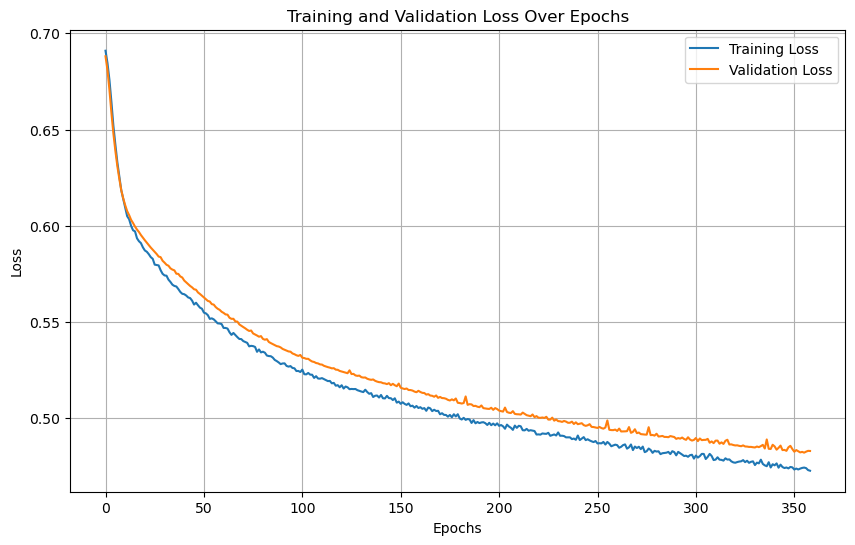

In [37]:
# Ensure that the length of gcn_train_loss_list and gcn_val_loss_list is equal to the number of epochs processed
assert len(gcn_train_loss_list) == len(gcn_val_loss_list)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gcn_train_loss_list, label='Training Loss')
plt.plot(gcn_val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Train on merged train and val sets


In [38]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.clone().detach().to(device)
        batch_features = batch_graphs.ndata['h']

        outputs = model(batch_graphs, batch_features)
        outputs = outputs.squeeze() # remove extra dimension
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)


## Reset weights before training again with all data


In [39]:
def reset_weights(m):
    """
    This function will reset the weights of a given module.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Example usage with your model
model.apply(reset_weights)


GCNClassifier(
  (conv1): GraphConv(in=74, out=148, normalization=both, activation=None)
  (conv2): GraphConv(in=148, out=148, normalization=both, activation=None)
  (fc): Linear(in_features=148, out_features=1, bias=True)
)

In [40]:
print("Final training on merged training and validation sets")

# Initialize list to store loss values
final_train_losses = []

for epoch in range(num_epochs_early):
    # Training
    train_loss = train(model, train_loader_all, criterion, optimizer, device)
    final_train_losses.append(train_loss)  # Store train loss

    # Print train loss
    print(f"Epoch {epoch+1}/{num_epochs_early}, Train Loss: {train_loss:.4f}")


Final training on merged training and validation sets


Epoch 1/359, Train Loss: 0.6812


Epoch 2/359, Train Loss: 0.6519


Epoch 3/359, Train Loss: 0.6270


Epoch 4/359, Train Loss: 0.6067


Epoch 5/359, Train Loss: 0.5911


Epoch 6/359, Train Loss: 0.5796


Epoch 7/359, Train Loss: 0.5708


Epoch 8/359, Train Loss: 0.5636


Epoch 9/359, Train Loss: 0.5575


Epoch 10/359, Train Loss: 0.5523


Epoch 11/359, Train Loss: 0.5477


Epoch 12/359, Train Loss: 0.5437


Epoch 13/359, Train Loss: 0.5401


Epoch 14/359, Train Loss: 0.5368


Epoch 15/359, Train Loss: 0.5336


Epoch 16/359, Train Loss: 0.5307


Epoch 17/359, Train Loss: 0.5280


Epoch 18/359, Train Loss: 0.5255


Epoch 19/359, Train Loss: 0.5232


Epoch 20/359, Train Loss: 0.5210


Epoch 21/359, Train Loss: 0.5190


Epoch 22/359, Train Loss: 0.5170


Epoch 23/359, Train Loss: 0.5153


Epoch 24/359, Train Loss: 0.5136


Epoch 25/359, Train Loss: 0.5121


Epoch 26/359, Train Loss: 0.5107


Epoch 27/359, Train Loss: 0.5093


Epoch 28/359, Train Loss: 0.5081


Epoch 29/359, Train Loss: 0.5069


Epoch 30/359, Train Loss: 0.5058


Epoch 31/359, Train Loss: 0.5047


Epoch 32/359, Train Loss: 0.5037


Epoch 33/359, Train Loss: 0.5028


Epoch 34/359, Train Loss: 0.5019


Epoch 35/359, Train Loss: 0.5010


Epoch 36/359, Train Loss: 0.5002


Epoch 37/359, Train Loss: 0.4995


Epoch 38/359, Train Loss: 0.4987


Epoch 39/359, Train Loss: 0.4980


Epoch 40/359, Train Loss: 0.4973


Epoch 41/359, Train Loss: 0.4967


Epoch 42/359, Train Loss: 0.4961


Epoch 43/359, Train Loss: 0.4955


Epoch 44/359, Train Loss: 0.4949


Epoch 45/359, Train Loss: 0.4944


Epoch 46/359, Train Loss: 0.4938


Epoch 47/359, Train Loss: 0.4933


Epoch 48/359, Train Loss: 0.4928


Epoch 49/359, Train Loss: 0.4923


Epoch 50/359, Train Loss: 0.4918


Epoch 51/359, Train Loss: 0.4913


Epoch 52/359, Train Loss: 0.4908


Epoch 53/359, Train Loss: 0.4904


Epoch 54/359, Train Loss: 0.4900


Epoch 55/359, Train Loss: 0.4895


Epoch 56/359, Train Loss: 0.4891


Epoch 57/359, Train Loss: 0.4887


Epoch 58/359, Train Loss: 0.4883


Epoch 59/359, Train Loss: 0.4879


Epoch 60/359, Train Loss: 0.4876


Epoch 61/359, Train Loss: 0.4872


Epoch 62/359, Train Loss: 0.4869


Epoch 63/359, Train Loss: 0.4865


Epoch 64/359, Train Loss: 0.4862


Epoch 65/359, Train Loss: 0.4859


Epoch 66/359, Train Loss: 0.4856


Epoch 67/359, Train Loss: 0.4853


Epoch 68/359, Train Loss: 0.4850


Epoch 69/359, Train Loss: 0.4847


Epoch 70/359, Train Loss: 0.4844


Epoch 71/359, Train Loss: 0.4841


Epoch 72/359, Train Loss: 0.4838


Epoch 73/359, Train Loss: 0.4835


Epoch 74/359, Train Loss: 0.4833


Epoch 75/359, Train Loss: 0.4830


Epoch 76/359, Train Loss: 0.4828


Epoch 77/359, Train Loss: 0.4825


Epoch 78/359, Train Loss: 0.4823


Epoch 79/359, Train Loss: 0.4820


Epoch 80/359, Train Loss: 0.4818


Epoch 81/359, Train Loss: 0.4815


Epoch 82/359, Train Loss: 0.4813


Epoch 83/359, Train Loss: 0.4811


Epoch 84/359, Train Loss: 0.4808


Epoch 85/359, Train Loss: 0.4806


Epoch 86/359, Train Loss: 0.4804


Epoch 87/359, Train Loss: 0.4802


Epoch 88/359, Train Loss: 0.4799


Epoch 89/359, Train Loss: 0.4797


Epoch 90/359, Train Loss: 0.4795


Epoch 91/359, Train Loss: 0.4793


Epoch 92/359, Train Loss: 0.4791


Epoch 93/359, Train Loss: 0.4789


Epoch 94/359, Train Loss: 0.4787


Epoch 95/359, Train Loss: 0.4785


Epoch 96/359, Train Loss: 0.4783


Epoch 97/359, Train Loss: 0.4781


Epoch 98/359, Train Loss: 0.4780


Epoch 99/359, Train Loss: 0.4778


Epoch 100/359, Train Loss: 0.4776


Epoch 101/359, Train Loss: 0.4774


Epoch 102/359, Train Loss: 0.4772


Epoch 103/359, Train Loss: 0.4771


Epoch 104/359, Train Loss: 0.4769


Epoch 105/359, Train Loss: 0.4767


Epoch 106/359, Train Loss: 0.4765


Epoch 107/359, Train Loss: 0.4764


Epoch 108/359, Train Loss: 0.4762


Epoch 109/359, Train Loss: 0.4760


Epoch 110/359, Train Loss: 0.4759


Epoch 111/359, Train Loss: 0.4757


Epoch 112/359, Train Loss: 0.4756


Epoch 113/359, Train Loss: 0.4754


Epoch 114/359, Train Loss: 0.4752


Epoch 115/359, Train Loss: 0.4751


Epoch 116/359, Train Loss: 0.4749


Epoch 117/359, Train Loss: 0.4748


Epoch 118/359, Train Loss: 0.4746


Epoch 119/359, Train Loss: 0.4745


Epoch 120/359, Train Loss: 0.4743


Epoch 121/359, Train Loss: 0.4742


Epoch 122/359, Train Loss: 0.4740


Epoch 123/359, Train Loss: 0.4739


Epoch 124/359, Train Loss: 0.4737


Epoch 125/359, Train Loss: 0.4736


Epoch 126/359, Train Loss: 0.4734


Epoch 127/359, Train Loss: 0.4733


Epoch 128/359, Train Loss: 0.4732


Epoch 129/359, Train Loss: 0.4730


Epoch 130/359, Train Loss: 0.4729


Epoch 131/359, Train Loss: 0.4727


Epoch 132/359, Train Loss: 0.4726


Epoch 133/359, Train Loss: 0.4725


Epoch 134/359, Train Loss: 0.4723


Epoch 135/359, Train Loss: 0.4722


Epoch 136/359, Train Loss: 0.4721


Epoch 137/359, Train Loss: 0.4719


Epoch 138/359, Train Loss: 0.4718


Epoch 139/359, Train Loss: 0.4717


Epoch 140/359, Train Loss: 0.4716


Epoch 141/359, Train Loss: 0.4714


Epoch 142/359, Train Loss: 0.4713


Epoch 143/359, Train Loss: 0.4712


Epoch 144/359, Train Loss: 0.4711


Epoch 145/359, Train Loss: 0.4709


Epoch 146/359, Train Loss: 0.4708


Epoch 147/359, Train Loss: 0.4707


Epoch 148/359, Train Loss: 0.4706


Epoch 149/359, Train Loss: 0.4704


Epoch 150/359, Train Loss: 0.4703


Epoch 151/359, Train Loss: 0.4702


Epoch 152/359, Train Loss: 0.4701


Epoch 153/359, Train Loss: 0.4700


Epoch 154/359, Train Loss: 0.4698


Epoch 155/359, Train Loss: 0.4697


Epoch 156/359, Train Loss: 0.4696


Epoch 157/359, Train Loss: 0.4695


Epoch 158/359, Train Loss: 0.4694


Epoch 159/359, Train Loss: 0.4692


Epoch 160/359, Train Loss: 0.4691


Epoch 161/359, Train Loss: 0.4690


Epoch 162/359, Train Loss: 0.4689


Epoch 163/359, Train Loss: 0.4688


Epoch 164/359, Train Loss: 0.4687


Epoch 165/359, Train Loss: 0.4685


Epoch 166/359, Train Loss: 0.4684


Epoch 167/359, Train Loss: 0.4683


Epoch 168/359, Train Loss: 0.4682


Epoch 169/359, Train Loss: 0.4681


Epoch 170/359, Train Loss: 0.4680


Epoch 171/359, Train Loss: 0.4678


Epoch 172/359, Train Loss: 0.4677


Epoch 173/359, Train Loss: 0.4676


Epoch 174/359, Train Loss: 0.4675


Epoch 175/359, Train Loss: 0.4674


Epoch 176/359, Train Loss: 0.4673


Epoch 177/359, Train Loss: 0.4672


Epoch 178/359, Train Loss: 0.4670


Epoch 179/359, Train Loss: 0.4669


Epoch 180/359, Train Loss: 0.4668


Epoch 181/359, Train Loss: 0.4667


Epoch 182/359, Train Loss: 0.4666


Epoch 183/359, Train Loss: 0.4665


Epoch 184/359, Train Loss: 0.4664


Epoch 185/359, Train Loss: 0.4663


Epoch 186/359, Train Loss: 0.4662


Epoch 187/359, Train Loss: 0.4661


Epoch 188/359, Train Loss: 0.4659


Epoch 189/359, Train Loss: 0.4658


Epoch 190/359, Train Loss: 0.4657


Epoch 191/359, Train Loss: 0.4656


Epoch 192/359, Train Loss: 0.4655


Epoch 193/359, Train Loss: 0.4654


Epoch 194/359, Train Loss: 0.4653


Epoch 195/359, Train Loss: 0.4652


Epoch 196/359, Train Loss: 0.4651


Epoch 197/359, Train Loss: 0.4650


Epoch 198/359, Train Loss: 0.4649


Epoch 199/359, Train Loss: 0.4648


Epoch 200/359, Train Loss: 0.4647


Epoch 201/359, Train Loss: 0.4646


Epoch 202/359, Train Loss: 0.4645


Epoch 203/359, Train Loss: 0.4644


Epoch 204/359, Train Loss: 0.4643


Epoch 205/359, Train Loss: 0.4642


Epoch 206/359, Train Loss: 0.4641


Epoch 207/359, Train Loss: 0.4640


Epoch 208/359, Train Loss: 0.4639


Epoch 209/359, Train Loss: 0.4639


Epoch 210/359, Train Loss: 0.4638


Epoch 211/359, Train Loss: 0.4637


Epoch 212/359, Train Loss: 0.4636


Epoch 213/359, Train Loss: 0.4635


Epoch 214/359, Train Loss: 0.4634


Epoch 215/359, Train Loss: 0.4633


Epoch 216/359, Train Loss: 0.4632


Epoch 217/359, Train Loss: 0.4631


Epoch 218/359, Train Loss: 0.4630


Epoch 219/359, Train Loss: 0.4629


Epoch 220/359, Train Loss: 0.4628


Epoch 221/359, Train Loss: 0.4627


Epoch 222/359, Train Loss: 0.4626


Epoch 223/359, Train Loss: 0.4625


Epoch 224/359, Train Loss: 0.4625


Epoch 225/359, Train Loss: 0.4624


Epoch 226/359, Train Loss: 0.4623


Epoch 227/359, Train Loss: 0.4622


Epoch 228/359, Train Loss: 0.4621


Epoch 229/359, Train Loss: 0.4620


Epoch 230/359, Train Loss: 0.4619


Epoch 231/359, Train Loss: 0.4618


Epoch 232/359, Train Loss: 0.4617


Epoch 233/359, Train Loss: 0.4616


Epoch 234/359, Train Loss: 0.4615


Epoch 235/359, Train Loss: 0.4614


Epoch 236/359, Train Loss: 0.4613


Epoch 237/359, Train Loss: 0.4612


Epoch 238/359, Train Loss: 0.4611


Epoch 239/359, Train Loss: 0.4610


Epoch 240/359, Train Loss: 0.4609


Epoch 241/359, Train Loss: 0.4608


Epoch 242/359, Train Loss: 0.4608


Epoch 243/359, Train Loss: 0.4607


Epoch 244/359, Train Loss: 0.4606


Epoch 245/359, Train Loss: 0.4605


Epoch 246/359, Train Loss: 0.4604


Epoch 247/359, Train Loss: 0.4603


Epoch 248/359, Train Loss: 0.4602


Epoch 249/359, Train Loss: 0.4601


Epoch 250/359, Train Loss: 0.4600


Epoch 251/359, Train Loss: 0.4599


Epoch 252/359, Train Loss: 0.4599


Epoch 253/359, Train Loss: 0.4598


Epoch 254/359, Train Loss: 0.4597


Epoch 255/359, Train Loss: 0.4596


Epoch 256/359, Train Loss: 0.4595


Epoch 257/359, Train Loss: 0.4594


Epoch 258/359, Train Loss: 0.4593


Epoch 259/359, Train Loss: 0.4593


Epoch 260/359, Train Loss: 0.4592


Epoch 261/359, Train Loss: 0.4591


Epoch 262/359, Train Loss: 0.4590


Epoch 263/359, Train Loss: 0.4589


Epoch 264/359, Train Loss: 0.4588


Epoch 265/359, Train Loss: 0.4588


Epoch 266/359, Train Loss: 0.4587


Epoch 267/359, Train Loss: 0.4586


Epoch 268/359, Train Loss: 0.4585


Epoch 269/359, Train Loss: 0.4584


Epoch 270/359, Train Loss: 0.4583


Epoch 271/359, Train Loss: 0.4583


Epoch 272/359, Train Loss: 0.4582


Epoch 273/359, Train Loss: 0.4581


Epoch 274/359, Train Loss: 0.4580


Epoch 275/359, Train Loss: 0.4580


Epoch 276/359, Train Loss: 0.4579


Epoch 277/359, Train Loss: 0.4578


Epoch 278/359, Train Loss: 0.4577


Epoch 279/359, Train Loss: 0.4576


Epoch 280/359, Train Loss: 0.4576


Epoch 281/359, Train Loss: 0.4575


Epoch 282/359, Train Loss: 0.4574


Epoch 283/359, Train Loss: 0.4573


Epoch 284/359, Train Loss: 0.4572


Epoch 285/359, Train Loss: 0.4571


Epoch 286/359, Train Loss: 0.4571


Epoch 287/359, Train Loss: 0.4570


Epoch 288/359, Train Loss: 0.4569


Epoch 289/359, Train Loss: 0.4568


Epoch 290/359, Train Loss: 0.4567


Epoch 291/359, Train Loss: 0.4567


Epoch 292/359, Train Loss: 0.4566


Epoch 293/359, Train Loss: 0.4565


Epoch 294/359, Train Loss: 0.4564


Epoch 295/359, Train Loss: 0.4564


Epoch 296/359, Train Loss: 0.4563


Epoch 297/359, Train Loss: 0.4562


Epoch 298/359, Train Loss: 0.4561


Epoch 299/359, Train Loss: 0.4560


Epoch 300/359, Train Loss: 0.4560


Epoch 301/359, Train Loss: 0.4559


Epoch 302/359, Train Loss: 0.4558


Epoch 303/359, Train Loss: 0.4557


Epoch 304/359, Train Loss: 0.4557


Epoch 305/359, Train Loss: 0.4556


Epoch 306/359, Train Loss: 0.4555


Epoch 307/359, Train Loss: 0.4554


Epoch 308/359, Train Loss: 0.4554


Epoch 309/359, Train Loss: 0.4553


Epoch 310/359, Train Loss: 0.4552


Epoch 311/359, Train Loss: 0.4551


Epoch 312/359, Train Loss: 0.4550


Epoch 313/359, Train Loss: 0.4550


Epoch 314/359, Train Loss: 0.4549


Epoch 315/359, Train Loss: 0.4548


Epoch 316/359, Train Loss: 0.4547


Epoch 317/359, Train Loss: 0.4546


Epoch 318/359, Train Loss: 0.4546


Epoch 319/359, Train Loss: 0.4545


Epoch 320/359, Train Loss: 0.4544


Epoch 321/359, Train Loss: 0.4543


Epoch 322/359, Train Loss: 0.4542


Epoch 323/359, Train Loss: 0.4542


Epoch 324/359, Train Loss: 0.4541


Epoch 325/359, Train Loss: 0.4540


Epoch 326/359, Train Loss: 0.4539


Epoch 327/359, Train Loss: 0.4538


Epoch 328/359, Train Loss: 0.4538


Epoch 329/359, Train Loss: 0.4537


Epoch 330/359, Train Loss: 0.4536


Epoch 331/359, Train Loss: 0.4535


Epoch 332/359, Train Loss: 0.4535


Epoch 333/359, Train Loss: 0.4534


Epoch 334/359, Train Loss: 0.4533


Epoch 335/359, Train Loss: 0.4532


Epoch 336/359, Train Loss: 0.4532


Epoch 337/359, Train Loss: 0.4531


Epoch 338/359, Train Loss: 0.4530


Epoch 339/359, Train Loss: 0.4529


Epoch 340/359, Train Loss: 0.4529


Epoch 341/359, Train Loss: 0.4528


Epoch 342/359, Train Loss: 0.4527


Epoch 343/359, Train Loss: 0.4527


Epoch 344/359, Train Loss: 0.4526


Epoch 345/359, Train Loss: 0.4525


Epoch 346/359, Train Loss: 0.4524


Epoch 347/359, Train Loss: 0.4524


Epoch 348/359, Train Loss: 0.4523


Epoch 349/359, Train Loss: 0.4522


Epoch 350/359, Train Loss: 0.4522


Epoch 351/359, Train Loss: 0.4521


Epoch 352/359, Train Loss: 0.4520


Epoch 353/359, Train Loss: 0.4519


Epoch 354/359, Train Loss: 0.4519


Epoch 355/359, Train Loss: 0.4518


Epoch 356/359, Train Loss: 0.4517


Epoch 357/359, Train Loss: 0.4516


Epoch 358/359, Train Loss: 0.4516


Epoch 359/359, Train Loss: 0.4515


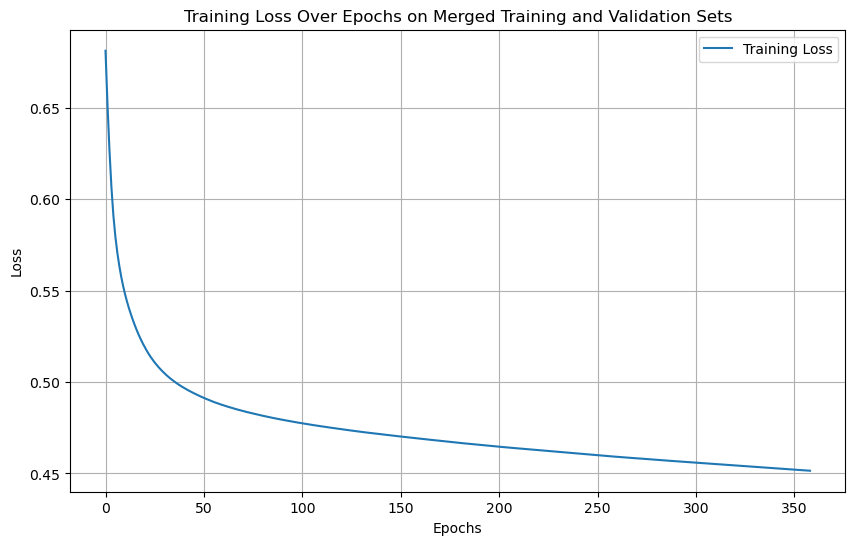

In [41]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(final_train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs on Merged Training and Validation Sets')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Save the model

In [42]:
# if there is not a folder named 'model' create one
if not os.path.exists('model'):
    os.mkdir('model')

# save the model
torch.save(model.state_dict(), 'model/gcn_model.pth')

In [43]:
# load the model
model = GCNClassifier(in_feats, hidden_size=148).to(device)
model.load_state_dict(torch.load('model/gcn_model.pth'))

<All keys matched successfully>

## Test the model

In [44]:
def test(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_pred_proba = []

    with torch.no_grad():
        for graphs, labels in data_loader:
            graphs = graphs.to(device)
            features = graphs.ndata['h'].to(device)
            labels = labels.to(device)

            outputs = model(graphs, features)
            probabilities = torch.sigmoid(outputs).squeeze()  # Apply sigmoid to convert logits to probabilities

            predicted = (probabilities > 0.5).long()  # Convert probabilities to binary predictions

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(probabilities.cpu().numpy())

    return y_true, y_pred, y_pred_proba


## Predict probabilities

In [45]:
# Now you can use this DataLoader in your test function
y_true, y_pred, y_pred_proba = test(model, test_loader, device)

# Convert probabilities to percentages for the positive class
# Assuming binary classification and class '1' is the positive class
confidence_percentages = [prob * 100 for prob in y_pred_proba]

# Now 'confidence_percentages' holds the confidence level for each prediction


In [46]:
# Extract the second element (index 1) from each 1D array in y_pred_proba
# y_pred_proba = [prob[1] for prob in y_pred_proba]
# Now y_pred_proba is a list of probabilities for the positive class
# Convert it to a NumPy array
y_pred_proba = np.array(y_pred_proba)


## Results

In [47]:
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')
print(f'AUC: {roc_auc_score(y_true, y_pred_proba)}')


Accuracy: 0.7834856175972927
Precision: 0.7834202580290969
Recall: 0.7788238504570882
F1: 0.7811152925076975
AUC: 0.8686308831601356


In [48]:
# Accuracy: 0.7896446700507614
# Precision: 0.8110537951363301
# Recall: 0.7508527766407422
# F1: 0.7797931132209155
# AUC: 0.8738676601333576

## Confusion matrix

In [49]:
# create folder 'visuals' if it does not exist
if not os.path.exists('visuals'):
    os.mkdir('visuals')
    

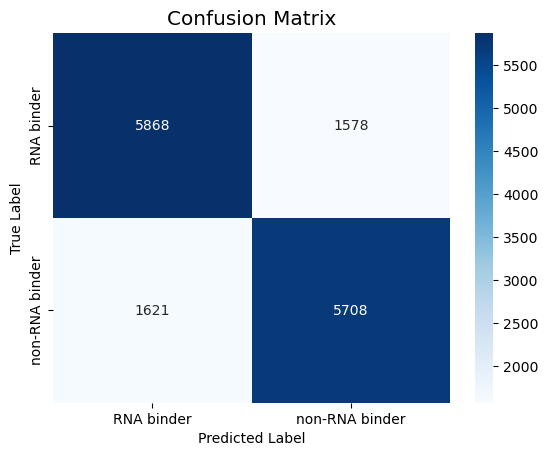

In [50]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['RNA binder', 'non-RNA binder'], columns=['RNA binder', 'non-RNA binder'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
sns.set(context='paper', style='white', font_scale=1.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('visuals/confusion_matrix_gcn.png', dpi=300)
plt.show()



## Classification report

In [51]:
# classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.78      0.79      0.79      7446
         1.0       0.78      0.78      0.78      7329

    accuracy                           0.78     14775
   macro avg       0.78      0.78      0.78     14775
weighted avg       0.78      0.78      0.78     14775



## ROC AUC

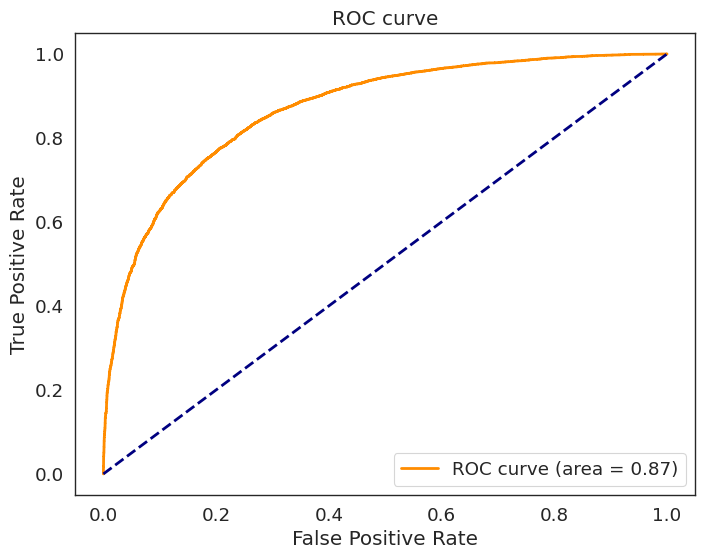

In [52]:
# visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('visuals/roc_curve_gcn.png', dpi=300)
plt.show()


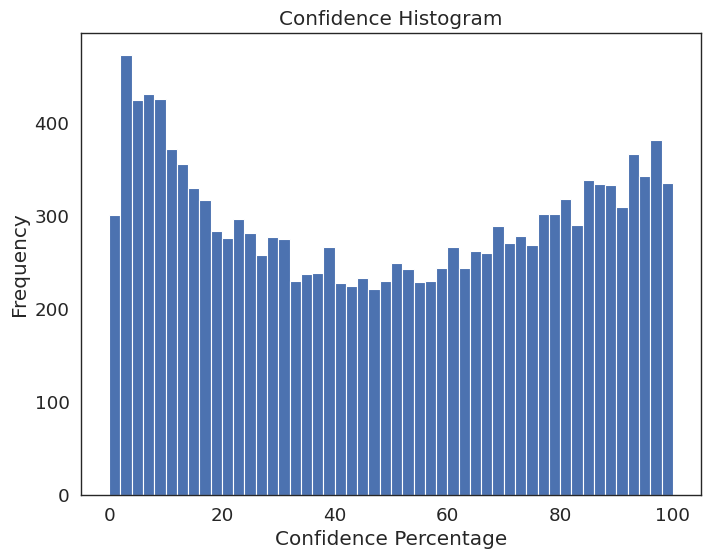

In [53]:
# visualize confidence_percentages in plot
plt.figure(figsize=(8, 6))
plt.hist(confidence_percentages, bins=50)
plt.title('Confidence Histogram')
plt.xlabel('Confidence Percentage')
plt.ylabel('Frequency')
plt.savefig('visuals/confidence_histogram_gcn.png', dpi=300)
plt.show()


In [54]:
# Sort test predictions by confidence and get top 10 indices
sorted_pairs = sorted(enumerate(confidence_percentages), key=lambda x: x[1], reverse=True)
top_molecules_test_indices = [index for index, _ in sorted_pairs[:20]]

# The indices in test_graphs correspond to their positions in the original loaded_graphs_orig
# Find the original indices in loaded_graphs_orig
original_indices = [loaded_graphs_orig.index(test_graphs[i]) for i in top_molecules_test_indices]

# Use the original indices to look up the corresponding rows in reconstructed_df
top_molecule_row_indices = reconstructed_df.index[original_indices]

# Now, top_molecule_row_indices contains the DataFrame indices of the top 10 RNA-binding molecules


In [55]:
top_molecule_row_indices

Index([73802, 72824,   353, 20934, 18120, 72796, 15967, 12580, 20157, 14998,
       15969, 71996, 14355, 72995, 10629, 14934, 73341, 15137, 10566, 16526],
      dtype='int64')

In [56]:
# create folder 'top_molecules' if it does not exist
if not os.path.exists('top_molecules_gcn'):
    os.mkdir('top_molecules_gcn')
    

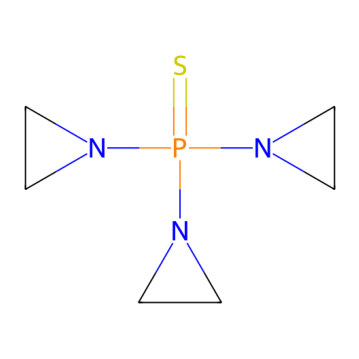

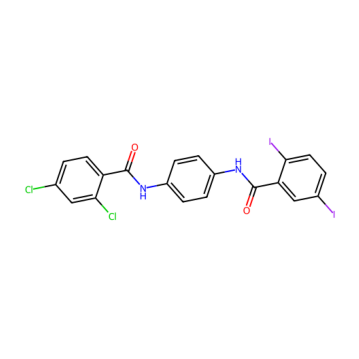

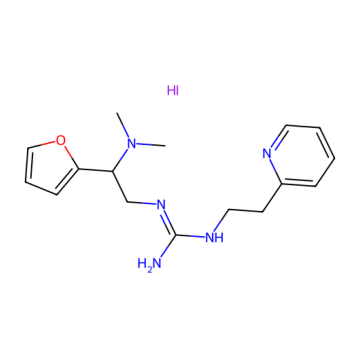

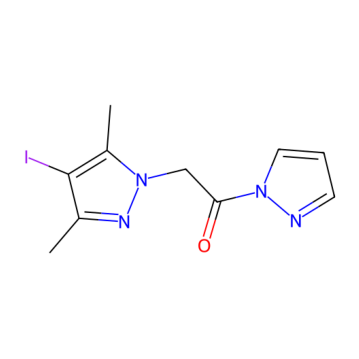

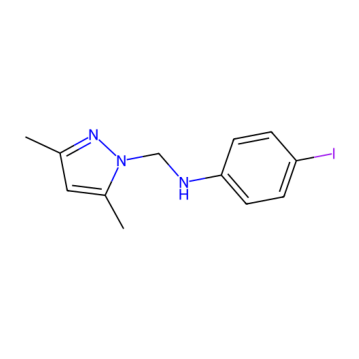

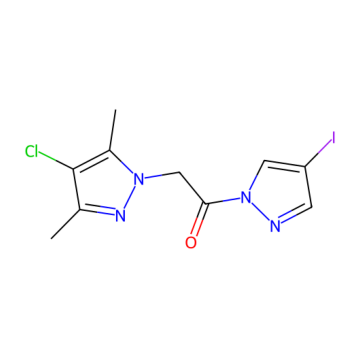

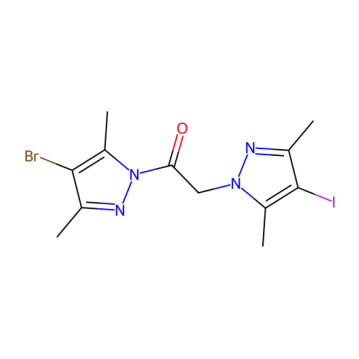

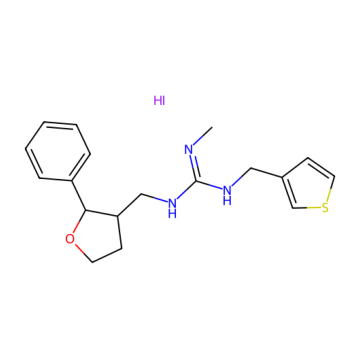

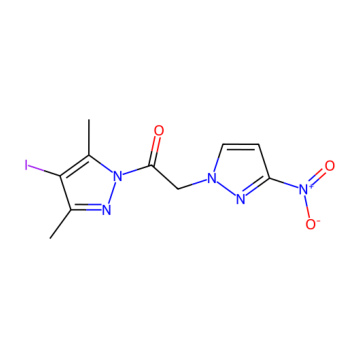

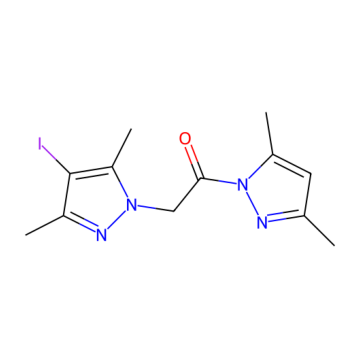

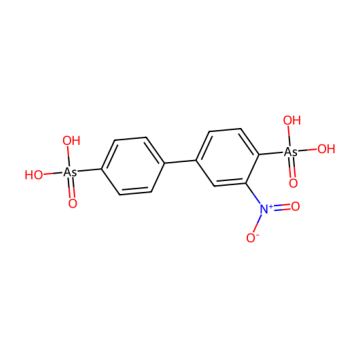

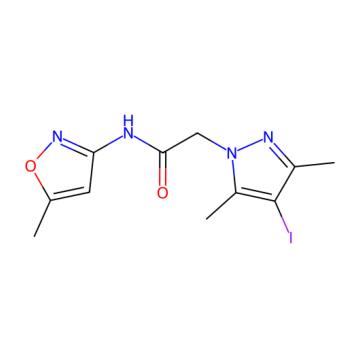

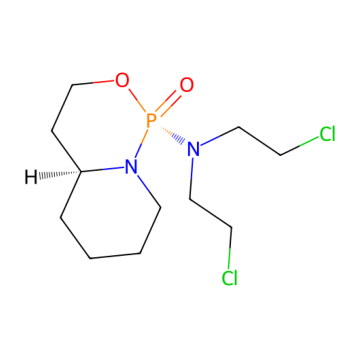

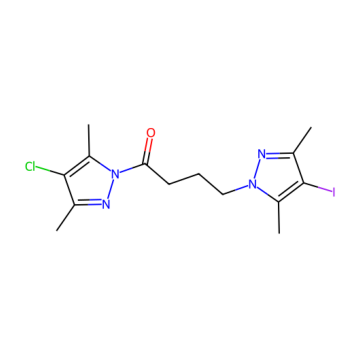

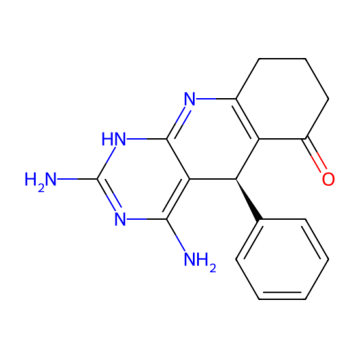

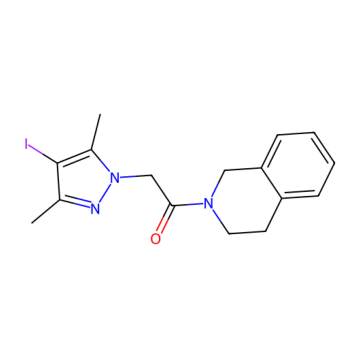

In [57]:
# Retrieve the SMILES codes and source information for the top 10 molecules
top_smiles = df_small.iloc[top_molecule_row_indices]['SMILES'].tolist()
top_sources = df_small.iloc[top_molecule_row_indices]['source'].tolist()

# Retrieve the confidence scores using the indices relative to the test dataset
top_confidences = [confidence_percentages[i] for i in top_molecules_test_indices]

# Convert SMILES to RDKit Mol objects
mols = [Chem.MolFromSmiles(smile) for smile in top_smiles]

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(500, 500))
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    # title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    # plt.title(title)
    plt.subplots_adjust(bottom=0.20)  # Adjust the position of the title
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gcn/molecule_{i+1}_{top_sources[i]}_a.png", dpi=300)
    plt.show()


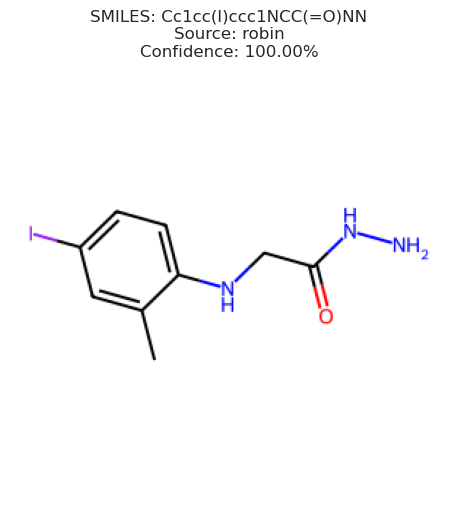

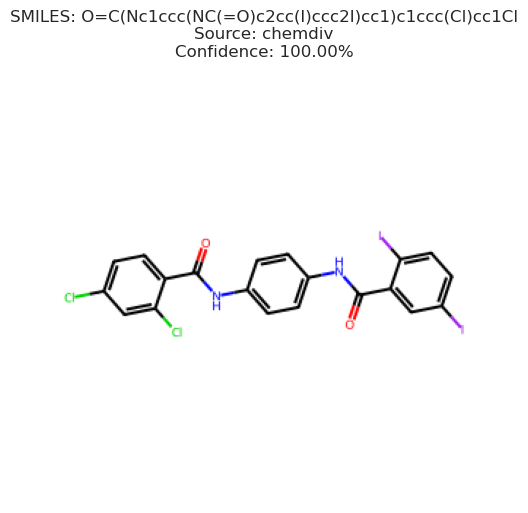

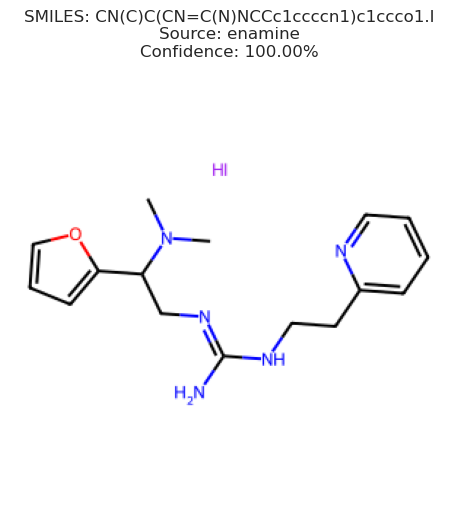

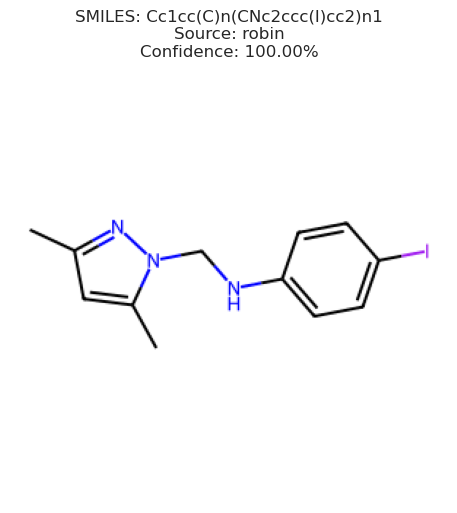

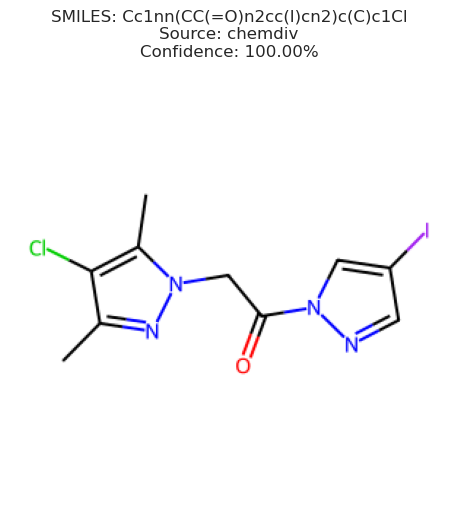

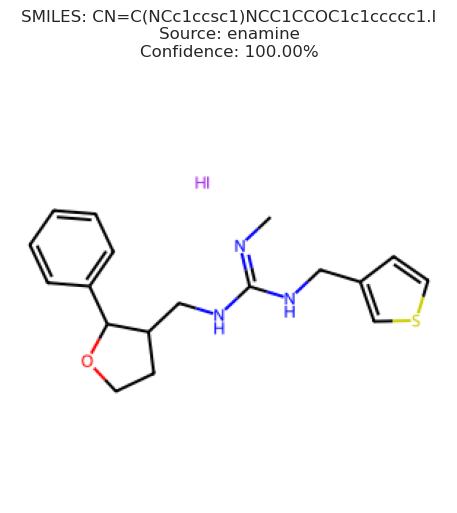

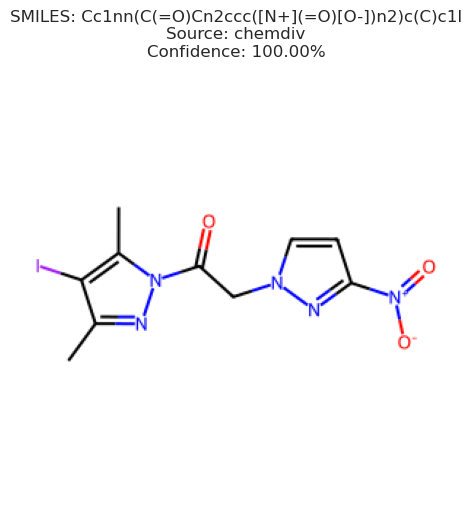

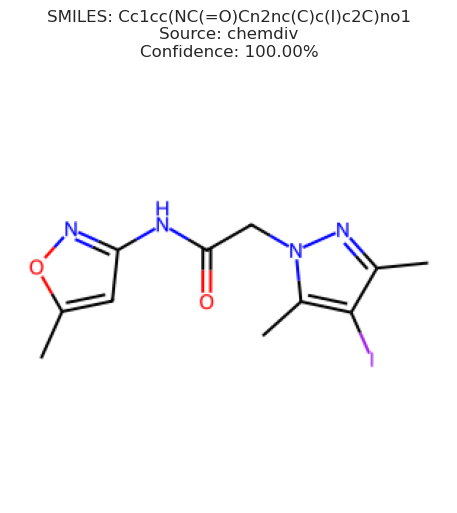

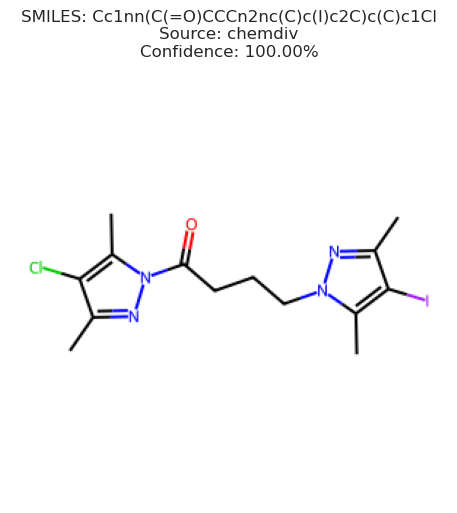

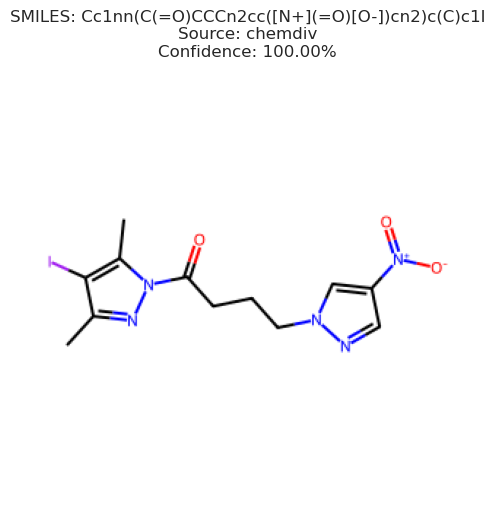

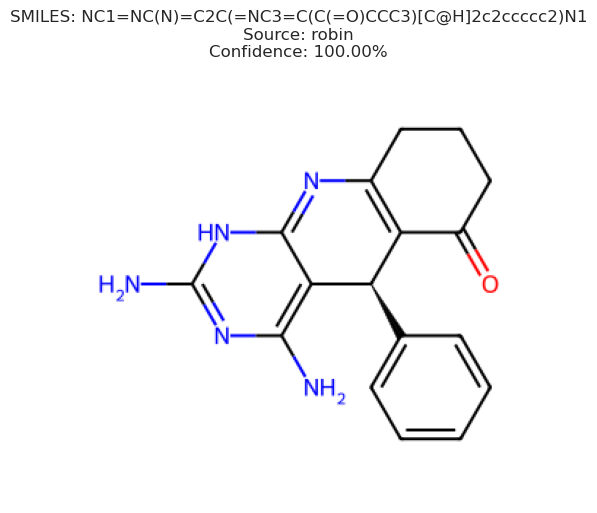

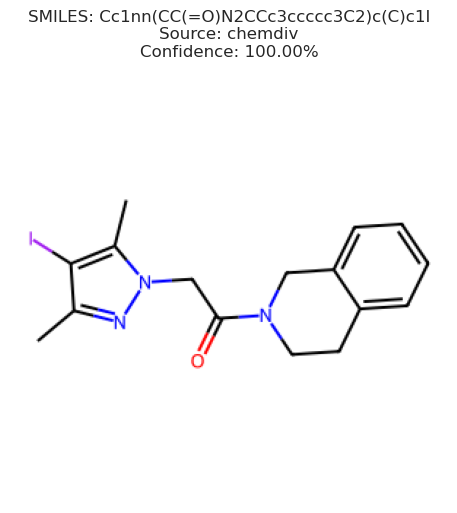

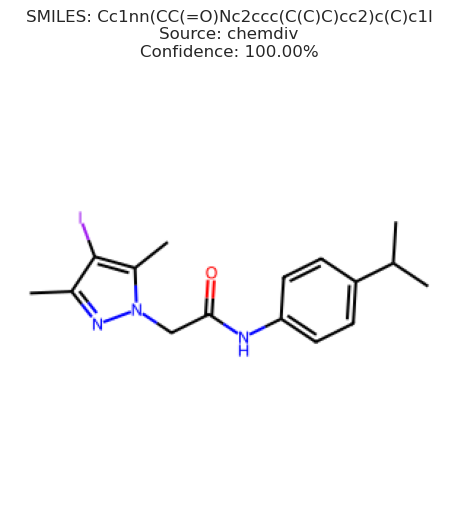

In [58]:
# Define the figure size and font size for titles
fig_size = (6, 6)
title_font_size = 12

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(300, 300))
    
    # Create a figure with adjusted size
    plt.figure(figsize=fig_size)
    plt.imshow(img)
    
    # Adjust the position of the text within the image
    title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    plt.title(title, fontsize=title_font_size)
    plt.subplots_adjust(bottom=0.15)  # Adjust the position of the title
    
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gcn/molecule_{i+1}_{top_sources[i]}_b.png", dpi=300)
    # plt.show()


# Message Passing Neural Network (MPNN)

In [59]:
class MPNNClassifier(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats):
        super(MPNNClassifier, self).__init__()
        self.edge_conv = dglnn.EdgeConv(in_feats, hidden_size)
        self.reduce_function = dgl.function.mean('m', 'h')
        self.fc = nn.Linear(74, out_feats)

    def forward(self, g, features):
        # Custom message function
        def message_function(edges):
            return {'m': edges.src['h'] + edges.dst['h']}

        # Message passing
        g.ndata['h'] = features
        g.apply_edges(message_function)
        g.update_all(dgl.function.copy_e('m', 'm'), self.reduce_function)
        
        x = dgl.mean_nodes(g, 'h')
        return self.fc(x)


## Instance of the the MPNN Model

In [60]:
# Instantiate the model
in_feats = train_graphs[0].ndata['h'].shape[1]  # Replace with your feature size
model = MPNNClassifier(in_feats, hidden_size=74, out_feats=1).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use this loss for binary classification with a sigmoid activation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


## Train the MPNN model

In [61]:
num_epochs = 500
early_stopping = EarlyStopping(patience=25, min_delta=0.002)

# Initialize lists to store loss values
mpnn_train_loss_list = []
mpnn_val_loss_list = []

for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_loader, criterion, optimizer, device)
    mpnn_train_loss_list.append(train_loss)  # Store train loss

    # Validation
    val_loss, _, _, _ = validate(model, val_loader, criterion, device)
    mpnn_val_loss_list.append(val_loss)  # Store validation loss

    # Print and check for early stopping
    print(f"Epoch: {epoch+1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
    early_stopping(val_loss, epoch)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break
    
# Store the epoch number when early stopping was triggered
num_epochs_early = early_stopping.stopped_epoch + 1



Epoch: 1, train_loss: 0.7067, val_loss: 0.7059


Epoch: 2, train_loss: 0.7053, val_loss: 0.7048


Epoch: 3, train_loss: 0.7044, val_loss: 0.7037


Epoch: 4, train_loss: 0.7032, val_loss: 0.7027


Epoch: 5, train_loss: 0.7023, val_loss: 0.7018


Epoch: 6, train_loss: 0.7013, val_loss: 0.7008


Epoch: 7, train_loss: 0.7004, val_loss: 0.6999


Epoch: 8, train_loss: 0.6994, val_loss: 0.6990


Epoch: 9, train_loss: 0.6985, val_loss: 0.6980


Epoch: 10, train_loss: 0.6976, val_loss: 0.6972


Epoch: 11, train_loss: 0.6966, val_loss: 0.6963


Epoch: 12, train_loss: 0.6958, val_loss: 0.6954


Epoch: 13, train_loss: 0.6949, val_loss: 0.6945


Epoch: 14, train_loss: 0.6941, val_loss: 0.6937


Epoch: 15, train_loss: 0.6932, val_loss: 0.6929


Epoch: 16, train_loss: 0.6923, val_loss: 0.6920


Epoch: 17, train_loss: 0.6915, val_loss: 0.6912


Epoch: 18, train_loss: 0.6907, val_loss: 0.6904


Epoch: 19, train_loss: 0.6899, val_loss: 0.6896


Epoch: 20, train_loss: 0.6891, val_loss: 0.6889


Epoch: 21, train_loss: 0.6883, val_loss: 0.6881


Epoch: 22, train_loss: 0.6875, val_loss: 0.6873


Epoch: 23, train_loss: 0.6867, val_loss: 0.6866


Epoch: 24, train_loss: 0.6860, val_loss: 0.6858


Epoch: 25, train_loss: 0.6853, val_loss: 0.6851


Epoch: 26, train_loss: 0.6846, val_loss: 0.6844


Epoch: 27, train_loss: 0.6838, val_loss: 0.6837


Epoch: 28, train_loss: 0.6831, val_loss: 0.6830


Epoch: 29, train_loss: 0.6824, val_loss: 0.6823


Epoch: 30, train_loss: 0.6819, val_loss: 0.6817


Epoch: 31, train_loss: 0.6810, val_loss: 0.6810


Epoch: 32, train_loss: 0.6803, val_loss: 0.6804


Epoch: 33, train_loss: 0.6798, val_loss: 0.6797


Epoch: 34, train_loss: 0.6790, val_loss: 0.6791


Epoch: 35, train_loss: 0.6784, val_loss: 0.6785


Epoch: 36, train_loss: 0.6776, val_loss: 0.6778


Epoch: 37, train_loss: 0.6772, val_loss: 0.6772


Epoch: 38, train_loss: 0.6766, val_loss: 0.6766


Epoch: 39, train_loss: 0.6759, val_loss: 0.6760


Epoch: 40, train_loss: 0.6753, val_loss: 0.6754


Epoch: 41, train_loss: 0.6748, val_loss: 0.6749


Epoch: 42, train_loss: 0.6741, val_loss: 0.6743


Epoch: 43, train_loss: 0.6737, val_loss: 0.6738


Epoch: 44, train_loss: 0.6730, val_loss: 0.6732


Epoch: 45, train_loss: 0.6727, val_loss: 0.6727


Epoch: 46, train_loss: 0.6719, val_loss: 0.6721


Epoch: 47, train_loss: 0.6714, val_loss: 0.6716


Epoch: 48, train_loss: 0.6710, val_loss: 0.6711


Epoch: 49, train_loss: 0.6706, val_loss: 0.6706


Epoch: 50, train_loss: 0.6698, val_loss: 0.6701


Epoch: 51, train_loss: 0.6695, val_loss: 0.6696


Epoch: 52, train_loss: 0.6688, val_loss: 0.6691


Epoch: 53, train_loss: 0.6683, val_loss: 0.6686


Epoch: 54, train_loss: 0.6678, val_loss: 0.6681


Epoch: 55, train_loss: 0.6673, val_loss: 0.6677


Epoch: 56, train_loss: 0.6668, val_loss: 0.6672


Epoch: 57, train_loss: 0.6664, val_loss: 0.6667


Epoch: 58, train_loss: 0.6658, val_loss: 0.6663


Epoch: 59, train_loss: 0.6656, val_loss: 0.6658


Epoch: 60, train_loss: 0.6649, val_loss: 0.6654


Epoch: 61, train_loss: 0.6644, val_loss: 0.6649


Epoch: 62, train_loss: 0.6641, val_loss: 0.6645


Epoch: 63, train_loss: 0.6639, val_loss: 0.6641


Epoch: 64, train_loss: 0.6630, val_loss: 0.6637


Epoch: 65, train_loss: 0.6629, val_loss: 0.6633


Epoch: 66, train_loss: 0.6624, val_loss: 0.6629


Epoch: 67, train_loss: 0.6620, val_loss: 0.6624


Epoch: 68, train_loss: 0.6616, val_loss: 0.6621


Epoch: 69, train_loss: 0.6610, val_loss: 0.6617


Epoch: 70, train_loss: 0.6608, val_loss: 0.6613


Epoch: 71, train_loss: 0.6602, val_loss: 0.6609


Epoch: 72, train_loss: 0.6601, val_loss: 0.6605


Epoch: 73, train_loss: 0.6597, val_loss: 0.6601


Epoch: 74, train_loss: 0.6593, val_loss: 0.6598


Epoch: 75, train_loss: 0.6588, val_loss: 0.6594


Epoch: 76, train_loss: 0.6586, val_loss: 0.6591


Epoch: 77, train_loss: 0.6579, val_loss: 0.6587


Epoch: 78, train_loss: 0.6579, val_loss: 0.6583


Epoch: 79, train_loss: 0.6574, val_loss: 0.6580


Epoch: 80, train_loss: 0.6571, val_loss: 0.6577


Epoch: 81, train_loss: 0.6565, val_loss: 0.6573


Epoch: 82, train_loss: 0.6564, val_loss: 0.6570


Epoch: 83, train_loss: 0.6562, val_loss: 0.6567


Epoch: 84, train_loss: 0.6560, val_loss: 0.6563


Epoch: 85, train_loss: 0.6554, val_loss: 0.6560


Epoch: 86, train_loss: 0.6552, val_loss: 0.6557


Epoch: 87, train_loss: 0.6548, val_loss: 0.6554


Epoch: 88, train_loss: 0.6542, val_loss: 0.6551


Epoch: 89, train_loss: 0.6535, val_loss: 0.6548


Epoch: 90, train_loss: 0.6539, val_loss: 0.6545


Epoch: 91, train_loss: 0.6533, val_loss: 0.6542


Epoch: 92, train_loss: 0.6531, val_loss: 0.6539


Epoch: 93, train_loss: 0.6527, val_loss: 0.6536


Epoch: 94, train_loss: 0.6524, val_loss: 0.6533


Epoch: 95, train_loss: 0.6524, val_loss: 0.6530


Epoch: 96, train_loss: 0.6520, val_loss: 0.6527


Epoch: 97, train_loss: 0.6516, val_loss: 0.6524


Epoch: 98, train_loss: 0.6514, val_loss: 0.6522


Epoch: 99, train_loss: 0.6515, val_loss: 0.6519


Epoch: 100, train_loss: 0.6509, val_loss: 0.6516


Epoch: 101, train_loss: 0.6506, val_loss: 0.6513


Epoch: 102, train_loss: 0.6500, val_loss: 0.6511


Epoch: 103, train_loss: 0.6501, val_loss: 0.6508


Epoch: 104, train_loss: 0.6494, val_loss: 0.6506


Epoch: 105, train_loss: 0.6498, val_loss: 0.6503


Epoch: 106, train_loss: 0.6497, val_loss: 0.6500


Epoch: 107, train_loss: 0.6489, val_loss: 0.6498


Epoch: 108, train_loss: 0.6487, val_loss: 0.6496


Epoch: 109, train_loss: 0.6484, val_loss: 0.6493


Epoch: 110, train_loss: 0.6484, val_loss: 0.6491


Epoch: 111, train_loss: 0.6477, val_loss: 0.6488


Epoch: 112, train_loss: 0.6477, val_loss: 0.6486


Epoch: 113, train_loss: 0.6473, val_loss: 0.6484


Epoch: 114, train_loss: 0.6480, val_loss: 0.6481


Epoch: 115, train_loss: 0.6470, val_loss: 0.6479


Epoch: 116, train_loss: 0.6465, val_loss: 0.6477


Epoch: 117, train_loss: 0.6467, val_loss: 0.6474


Epoch: 118, train_loss: 0.6464, val_loss: 0.6472


Epoch: 119, train_loss: 0.6459, val_loss: 0.6470


Epoch: 120, train_loss: 0.6461, val_loss: 0.6468


Epoch: 121, train_loss: 0.6451, val_loss: 0.6465


Epoch: 122, train_loss: 0.6453, val_loss: 0.6463


Epoch: 123, train_loss: 0.6455, val_loss: 0.6461


Epoch: 124, train_loss: 0.6452, val_loss: 0.6459


Epoch: 125, train_loss: 0.6446, val_loss: 0.6457


Epoch: 126, train_loss: 0.6445, val_loss: 0.6455


Epoch: 127, train_loss: 0.6444, val_loss: 0.6453


Epoch: 128, train_loss: 0.6440, val_loss: 0.6451


Epoch: 129, train_loss: 0.6442, val_loss: 0.6449


Epoch: 130, train_loss: 0.6436, val_loss: 0.6447


Epoch: 131, train_loss: 0.6433, val_loss: 0.6445


Epoch: 132, train_loss: 0.6432, val_loss: 0.6443


Epoch: 133, train_loss: 0.6432, val_loss: 0.6441


Epoch: 134, train_loss: 0.6430, val_loss: 0.6439


Epoch: 135, train_loss: 0.6425, val_loss: 0.6437


Epoch: 136, train_loss: 0.6429, val_loss: 0.6435


Epoch: 137, train_loss: 0.6421, val_loss: 0.6433


Epoch: 138, train_loss: 0.6423, val_loss: 0.6431


Epoch: 139, train_loss: 0.6417, val_loss: 0.6429


Epoch: 140, train_loss: 0.6417, val_loss: 0.6427


Epoch: 141, train_loss: 0.6411, val_loss: 0.6425


Epoch: 142, train_loss: 0.6412, val_loss: 0.6424


Epoch: 143, train_loss: 0.6412, val_loss: 0.6422


Epoch: 144, train_loss: 0.6405, val_loss: 0.6420


Epoch: 145, train_loss: 0.6407, val_loss: 0.6418


Epoch: 146, train_loss: 0.6408, val_loss: 0.6416


Epoch: 147, train_loss: 0.6400, val_loss: 0.6415


Epoch: 148, train_loss: 0.6399, val_loss: 0.6413


Epoch: 149, train_loss: 0.6397, val_loss: 0.6411


Epoch: 150, train_loss: 0.6396, val_loss: 0.6409


Epoch: 151, train_loss: 0.6396, val_loss: 0.6407


Epoch: 152, train_loss: 0.6399, val_loss: 0.6406


Epoch: 153, train_loss: 0.6392, val_loss: 0.6404


Epoch: 154, train_loss: 0.6391, val_loss: 0.6402


Epoch: 155, train_loss: 0.6391, val_loss: 0.6401


Epoch: 156, train_loss: 0.6388, val_loss: 0.6399


Epoch: 157, train_loss: 0.6385, val_loss: 0.6397


Epoch: 158, train_loss: 0.6379, val_loss: 0.6396


Epoch: 159, train_loss: 0.6385, val_loss: 0.6394


Epoch: 160, train_loss: 0.6385, val_loss: 0.6392


Epoch: 161, train_loss: 0.6374, val_loss: 0.6391


Epoch: 162, train_loss: 0.6374, val_loss: 0.6389


Epoch: 163, train_loss: 0.6380, val_loss: 0.6387


Epoch: 164, train_loss: 0.6372, val_loss: 0.6386


Epoch: 165, train_loss: 0.6372, val_loss: 0.6384


Epoch: 166, train_loss: 0.6371, val_loss: 0.6383


Epoch: 167, train_loss: 0.6369, val_loss: 0.6381


Epoch: 168, train_loss: 0.6369, val_loss: 0.6379


Epoch: 169, train_loss: 0.6367, val_loss: 0.6378


Epoch: 170, train_loss: 0.6367, val_loss: 0.6376


Epoch: 171, train_loss: 0.6365, val_loss: 0.6375


Epoch: 172, train_loss: 0.6361, val_loss: 0.6373


Epoch: 173, train_loss: 0.6358, val_loss: 0.6372


Epoch: 174, train_loss: 0.6361, val_loss: 0.6370


Epoch: 175, train_loss: 0.6355, val_loss: 0.6369


Epoch: 176, train_loss: 0.6355, val_loss: 0.6367


Epoch: 177, train_loss: 0.6350, val_loss: 0.6366


Epoch: 178, train_loss: 0.6349, val_loss: 0.6364


Epoch: 179, train_loss: 0.6348, val_loss: 0.6363


Epoch: 180, train_loss: 0.6350, val_loss: 0.6361


Epoch: 181, train_loss: 0.6346, val_loss: 0.6360


Epoch: 182, train_loss: 0.6349, val_loss: 0.6358


Epoch: 183, train_loss: 0.6345, val_loss: 0.6357


Epoch: 184, train_loss: 0.6341, val_loss: 0.6356


Epoch: 185, train_loss: 0.6338, val_loss: 0.6354


Epoch: 186, train_loss: 0.6341, val_loss: 0.6353


Epoch: 187, train_loss: 0.6340, val_loss: 0.6351


Epoch: 188, train_loss: 0.6333, val_loss: 0.6350


Epoch: 189, train_loss: 0.6332, val_loss: 0.6349


Epoch: 190, train_loss: 0.6334, val_loss: 0.6347


Epoch: 191, train_loss: 0.6330, val_loss: 0.6346


Epoch: 192, train_loss: 0.6333, val_loss: 0.6344


Epoch: 193, train_loss: 0.6327, val_loss: 0.6343


Epoch: 194, train_loss: 0.6328, val_loss: 0.6342


Epoch: 195, train_loss: 0.6326, val_loss: 0.6340


Epoch: 196, train_loss: 0.6322, val_loss: 0.6339


Epoch: 197, train_loss: 0.6322, val_loss: 0.6338


Epoch: 198, train_loss: 0.6323, val_loss: 0.6336


Epoch: 199, train_loss: 0.6327, val_loss: 0.6335


Epoch: 200, train_loss: 0.6317, val_loss: 0.6334


Epoch: 201, train_loss: 0.6319, val_loss: 0.6332


Epoch: 202, train_loss: 0.6319, val_loss: 0.6331


Epoch: 203, train_loss: 0.6321, val_loss: 0.6330


Epoch: 204, train_loss: 0.6319, val_loss: 0.6328


Epoch: 205, train_loss: 0.6310, val_loss: 0.6327


Epoch: 206, train_loss: 0.6317, val_loss: 0.6326


Epoch: 207, train_loss: 0.6313, val_loss: 0.6325


Epoch: 208, train_loss: 0.6309, val_loss: 0.6324


Epoch: 209, train_loss: 0.6312, val_loss: 0.6322


Epoch: 210, train_loss: 0.6301, val_loss: 0.6321


Epoch: 211, train_loss: 0.6302, val_loss: 0.6320


Epoch: 212, train_loss: 0.6304, val_loss: 0.6319


Epoch: 213, train_loss: 0.6301, val_loss: 0.6317


Epoch: 214, train_loss: 0.6295, val_loss: 0.6316


Epoch: 215, train_loss: 0.6305, val_loss: 0.6315


Epoch: 216, train_loss: 0.6305, val_loss: 0.6314


Epoch: 217, train_loss: 0.6303, val_loss: 0.6313


Epoch: 218, train_loss: 0.6298, val_loss: 0.6312


Epoch: 219, train_loss: 0.6296, val_loss: 0.6310


Epoch: 220, train_loss: 0.6296, val_loss: 0.6309


Epoch: 221, train_loss: 0.6294, val_loss: 0.6308


Epoch: 222, train_loss: 0.6290, val_loss: 0.6307


Epoch: 223, train_loss: 0.6291, val_loss: 0.6306


Epoch: 224, train_loss: 0.6293, val_loss: 0.6305


Epoch: 225, train_loss: 0.6288, val_loss: 0.6304


Epoch: 226, train_loss: 0.6291, val_loss: 0.6303


Epoch: 227, train_loss: 0.6285, val_loss: 0.6301


Epoch: 228, train_loss: 0.6286, val_loss: 0.6300


Epoch: 229, train_loss: 0.6281, val_loss: 0.6299


Epoch: 230, train_loss: 0.6279, val_loss: 0.6298


Epoch: 231, train_loss: 0.6284, val_loss: 0.6297


Epoch: 232, train_loss: 0.6279, val_loss: 0.6296


Epoch: 233, train_loss: 0.6276, val_loss: 0.6295


Epoch: 234, train_loss: 0.6273, val_loss: 0.6294


Epoch: 235, train_loss: 0.6277, val_loss: 0.6293


Epoch: 236, train_loss: 0.6282, val_loss: 0.6292


Epoch: 237, train_loss: 0.6275, val_loss: 0.6291


Epoch: 238, train_loss: 0.6273, val_loss: 0.6290


Epoch: 239, train_loss: 0.6272, val_loss: 0.6289


Epoch: 240, train_loss: 0.6278, val_loss: 0.6288


Epoch: 241, train_loss: 0.6268, val_loss: 0.6287


Epoch: 242, train_loss: 0.6271, val_loss: 0.6286


Epoch: 243, train_loss: 0.6273, val_loss: 0.6285


Epoch: 244, train_loss: 0.6266, val_loss: 0.6284


Epoch: 245, train_loss: 0.6268, val_loss: 0.6283


Epoch: 246, train_loss: 0.6262, val_loss: 0.6282


Epoch: 247, train_loss: 0.6262, val_loss: 0.6281


Epoch: 248, train_loss: 0.6264, val_loss: 0.6280


Epoch: 249, train_loss: 0.6267, val_loss: 0.6279


Epoch: 250, train_loss: 0.6266, val_loss: 0.6278


Epoch: 251, train_loss: 0.6256, val_loss: 0.6277


Epoch: 252, train_loss: 0.6255, val_loss: 0.6276


Epoch: 253, train_loss: 0.6262, val_loss: 0.6275


Epoch: 254, train_loss: 0.6256, val_loss: 0.6274


Epoch: 255, train_loss: 0.6254, val_loss: 0.6273


Epoch: 256, train_loss: 0.6262, val_loss: 0.6272


Epoch: 257, train_loss: 0.6251, val_loss: 0.6271


Epoch: 258, train_loss: 0.6262, val_loss: 0.6270


Epoch: 259, train_loss: 0.6252, val_loss: 0.6269


Epoch: 260, train_loss: 0.6254, val_loss: 0.6268


Epoch: 261, train_loss: 0.6250, val_loss: 0.6268


Epoch: 262, train_loss: 0.6248, val_loss: 0.6267


Epoch: 263, train_loss: 0.6246, val_loss: 0.6266


Epoch: 264, train_loss: 0.6250, val_loss: 0.6265


Epoch: 265, train_loss: 0.6249, val_loss: 0.6264


Epoch: 266, train_loss: 0.6248, val_loss: 0.6263


Epoch: 267, train_loss: 0.6245, val_loss: 0.6262


Epoch: 268, train_loss: 0.6249, val_loss: 0.6261


Epoch: 269, train_loss: 0.6246, val_loss: 0.6261


Epoch: 270, train_loss: 0.6237, val_loss: 0.6260


Epoch: 271, train_loss: 0.6244, val_loss: 0.6259


Epoch: 272, train_loss: 0.6249, val_loss: 0.6258


Epoch: 273, train_loss: 0.6245, val_loss: 0.6257


Epoch: 274, train_loss: 0.6241, val_loss: 0.6256


Epoch: 275, train_loss: 0.6238, val_loss: 0.6256


Epoch: 276, train_loss: 0.6235, val_loss: 0.6255


Epoch: 277, train_loss: 0.6236, val_loss: 0.6254


Epoch: 278, train_loss: 0.6235, val_loss: 0.6253


Epoch: 279, train_loss: 0.6234, val_loss: 0.6252


Epoch: 280, train_loss: 0.6233, val_loss: 0.6252


Epoch: 281, train_loss: 0.6235, val_loss: 0.6251


Epoch: 282, train_loss: 0.6238, val_loss: 0.6250


Epoch: 283, train_loss: 0.6230, val_loss: 0.6249


Epoch: 284, train_loss: 0.6233, val_loss: 0.6248


Epoch: 285, train_loss: 0.6235, val_loss: 0.6248


Epoch: 286, train_loss: 0.6230, val_loss: 0.6247


Epoch: 287, train_loss: 0.6227, val_loss: 0.6246


Epoch: 288, train_loss: 0.6230, val_loss: 0.6245


Epoch: 289, train_loss: 0.6225, val_loss: 0.6245


Epoch: 290, train_loss: 0.6228, val_loss: 0.6244


Epoch: 291, train_loss: 0.6223, val_loss: 0.6243


Epoch: 292, train_loss: 0.6216, val_loss: 0.6242


Epoch: 293, train_loss: 0.6228, val_loss: 0.6242


Epoch: 294, train_loss: 0.6227, val_loss: 0.6241


Epoch: 295, train_loss: 0.6218, val_loss: 0.6240


Epoch: 296, train_loss: 0.6227, val_loss: 0.6239


Epoch: 297, train_loss: 0.6219, val_loss: 0.6239


Epoch: 298, train_loss: 0.6217, val_loss: 0.6238


Epoch: 299, train_loss: 0.6224, val_loss: 0.6237


Epoch: 300, train_loss: 0.6218, val_loss: 0.6237


Epoch: 301, train_loss: 0.6221, val_loss: 0.6236


Epoch: 302, train_loss: 0.6217, val_loss: 0.6235


Epoch: 303, train_loss: 0.6214, val_loss: 0.6234


Epoch: 304, train_loss: 0.6218, val_loss: 0.6234
Early stopping triggered at epoch 304


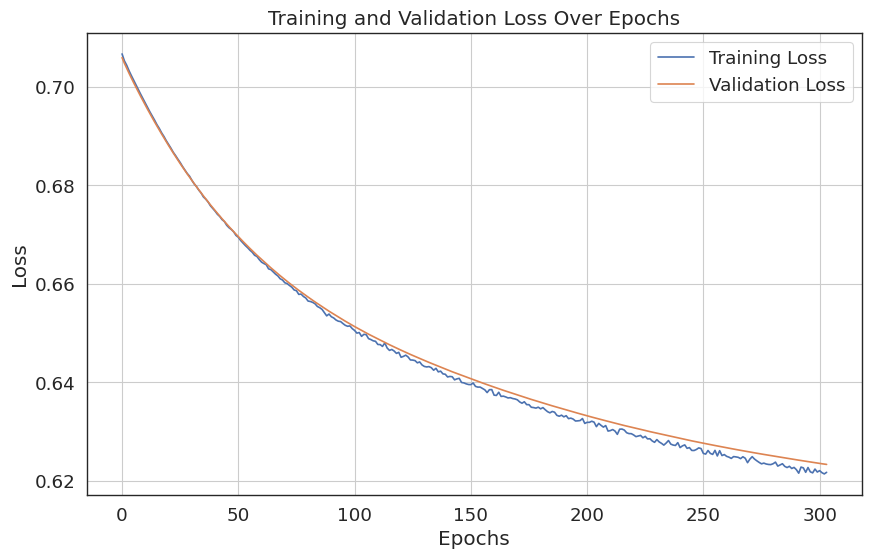

In [62]:
# Ensure that the length of mpnn_train_loss_list and mpnn_val_loss_list is equal to the number of epochs processed
assert len(mpnn_train_loss_list) == len(mpnn_val_loss_list)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mpnn_train_loss_list, label='Training Loss')
plt.plot(mpnn_val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Train on merged train and val sets


In [63]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.clone().detach().to(device)
        batch_features = batch_graphs.ndata['h']

        outputs = model(batch_graphs, batch_features)
        outputs = outputs.squeeze() # remove extra dimension
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

## Reset weights before training again with all data


In [64]:
def reset_weights(m):
    """
    This function will reset the weights of a given module.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Example usage with your model
model.apply(reset_weights)

MPNNClassifier(
  (edge_conv): EdgeConv(
    (theta): Linear(in_features=74, out_features=74, bias=True)
    (phi): Linear(in_features=74, out_features=74, bias=True)
  )
  (fc): Linear(in_features=74, out_features=1, bias=True)
)

In [65]:
print("Final training on merged training and validation sets")

# Initialize list to store loss values
final_train_losses = []

for epoch in range(num_epochs_early):
    # Training
    train_loss = train(model, train_loader_all, criterion, optimizer, device)
    final_train_losses.append(train_loss)  # Store train loss

    # Print train loss
    print(f"Epoch {epoch+1}/{num_epochs_early}, Train Loss: {train_loss:.4f}")


Final training on merged training and validation sets


Epoch 1/304, Train Loss: 0.6856


Epoch 2/304, Train Loss: 0.6832


Epoch 3/304, Train Loss: 0.6813


Epoch 4/304, Train Loss: 0.6796


Epoch 5/304, Train Loss: 0.6782


Epoch 6/304, Train Loss: 0.6768


Epoch 7/304, Train Loss: 0.6756


Epoch 8/304, Train Loss: 0.6744


Epoch 9/304, Train Loss: 0.6733


Epoch 10/304, Train Loss: 0.6723


Epoch 11/304, Train Loss: 0.6713


Epoch 12/304, Train Loss: 0.6704


Epoch 13/304, Train Loss: 0.6696


Epoch 14/304, Train Loss: 0.6687


Epoch 15/304, Train Loss: 0.6679


Epoch 16/304, Train Loss: 0.6672


Epoch 17/304, Train Loss: 0.6664


Epoch 18/304, Train Loss: 0.6657


Epoch 19/304, Train Loss: 0.6650


Epoch 20/304, Train Loss: 0.6644


Epoch 21/304, Train Loss: 0.6637


Epoch 22/304, Train Loss: 0.6631


Epoch 23/304, Train Loss: 0.6625


Epoch 24/304, Train Loss: 0.6619


Epoch 25/304, Train Loss: 0.6613


Epoch 26/304, Train Loss: 0.6607


Epoch 27/304, Train Loss: 0.6602


Epoch 28/304, Train Loss: 0.6597


Epoch 29/304, Train Loss: 0.6591


Epoch 30/304, Train Loss: 0.6586


Epoch 31/304, Train Loss: 0.6581


Epoch 32/304, Train Loss: 0.6576


Epoch 33/304, Train Loss: 0.6572


Epoch 34/304, Train Loss: 0.6567


Epoch 35/304, Train Loss: 0.6562


Epoch 36/304, Train Loss: 0.6558


Epoch 37/304, Train Loss: 0.6554


Epoch 38/304, Train Loss: 0.6549


Epoch 39/304, Train Loss: 0.6545


Epoch 40/304, Train Loss: 0.6541


Epoch 41/304, Train Loss: 0.6537


Epoch 42/304, Train Loss: 0.6533


Epoch 43/304, Train Loss: 0.6529


Epoch 44/304, Train Loss: 0.6525


Epoch 45/304, Train Loss: 0.6521


Epoch 46/304, Train Loss: 0.6517


Epoch 47/304, Train Loss: 0.6514


Epoch 48/304, Train Loss: 0.6510


Epoch 49/304, Train Loss: 0.6507


Epoch 50/304, Train Loss: 0.6503


Epoch 51/304, Train Loss: 0.6500


Epoch 52/304, Train Loss: 0.6496


Epoch 53/304, Train Loss: 0.6493


Epoch 54/304, Train Loss: 0.6489


Epoch 55/304, Train Loss: 0.6486


Epoch 56/304, Train Loss: 0.6483


Epoch 57/304, Train Loss: 0.6480


Epoch 58/304, Train Loss: 0.6477


Epoch 59/304, Train Loss: 0.6473


Epoch 60/304, Train Loss: 0.6470


Epoch 61/304, Train Loss: 0.6467


Epoch 62/304, Train Loss: 0.6464


Epoch 63/304, Train Loss: 0.6461


Epoch 64/304, Train Loss: 0.6458


Epoch 65/304, Train Loss: 0.6455


Epoch 66/304, Train Loss: 0.6453


Epoch 67/304, Train Loss: 0.6450


Epoch 68/304, Train Loss: 0.6447


Epoch 69/304, Train Loss: 0.6444


Epoch 70/304, Train Loss: 0.6441


Epoch 71/304, Train Loss: 0.6439


Epoch 72/304, Train Loss: 0.6436


Epoch 73/304, Train Loss: 0.6433


Epoch 74/304, Train Loss: 0.6431


Epoch 75/304, Train Loss: 0.6428


Epoch 76/304, Train Loss: 0.6425


Epoch 77/304, Train Loss: 0.6423


Epoch 78/304, Train Loss: 0.6420


Epoch 79/304, Train Loss: 0.6418


Epoch 80/304, Train Loss: 0.6415


Epoch 81/304, Train Loss: 0.6413


Epoch 82/304, Train Loss: 0.6410


Epoch 83/304, Train Loss: 0.6408


Epoch 84/304, Train Loss: 0.6405


Epoch 85/304, Train Loss: 0.6403


Epoch 86/304, Train Loss: 0.6401


Epoch 87/304, Train Loss: 0.6398


Epoch 88/304, Train Loss: 0.6396


Epoch 89/304, Train Loss: 0.6394


Epoch 90/304, Train Loss: 0.6391


Epoch 91/304, Train Loss: 0.6389


Epoch 92/304, Train Loss: 0.6387


Epoch 93/304, Train Loss: 0.6385


Epoch 94/304, Train Loss: 0.6382


Epoch 95/304, Train Loss: 0.6380


Epoch 96/304, Train Loss: 0.6378


Epoch 97/304, Train Loss: 0.6376


Epoch 98/304, Train Loss: 0.6374


Epoch 99/304, Train Loss: 0.6371


Epoch 100/304, Train Loss: 0.6369


Epoch 101/304, Train Loss: 0.6367


Epoch 102/304, Train Loss: 0.6365


Epoch 103/304, Train Loss: 0.6363


Epoch 104/304, Train Loss: 0.6361


Epoch 105/304, Train Loss: 0.6359


Epoch 106/304, Train Loss: 0.6357


Epoch 107/304, Train Loss: 0.6355


Epoch 108/304, Train Loss: 0.6353


Epoch 109/304, Train Loss: 0.6351


Epoch 110/304, Train Loss: 0.6349


Epoch 111/304, Train Loss: 0.6347


Epoch 112/304, Train Loss: 0.6345


Epoch 113/304, Train Loss: 0.6343


Epoch 114/304, Train Loss: 0.6341


Epoch 115/304, Train Loss: 0.6340


Epoch 116/304, Train Loss: 0.6338


Epoch 117/304, Train Loss: 0.6336


Epoch 118/304, Train Loss: 0.6334


Epoch 119/304, Train Loss: 0.6332


Epoch 120/304, Train Loss: 0.6330


Epoch 121/304, Train Loss: 0.6329


Epoch 122/304, Train Loss: 0.6327


Epoch 123/304, Train Loss: 0.6325


Epoch 124/304, Train Loss: 0.6323


Epoch 125/304, Train Loss: 0.6321


Epoch 126/304, Train Loss: 0.6320


Epoch 127/304, Train Loss: 0.6318


Epoch 128/304, Train Loss: 0.6316


Epoch 129/304, Train Loss: 0.6315


Epoch 130/304, Train Loss: 0.6313


Epoch 131/304, Train Loss: 0.6311


Epoch 132/304, Train Loss: 0.6310


Epoch 133/304, Train Loss: 0.6308


Epoch 134/304, Train Loss: 0.6306


Epoch 135/304, Train Loss: 0.6305


Epoch 136/304, Train Loss: 0.6303


Epoch 137/304, Train Loss: 0.6302


Epoch 138/304, Train Loss: 0.6300


Epoch 139/304, Train Loss: 0.6298


Epoch 140/304, Train Loss: 0.6297


Epoch 141/304, Train Loss: 0.6295


Epoch 142/304, Train Loss: 0.6294


Epoch 143/304, Train Loss: 0.6292


Epoch 144/304, Train Loss: 0.6291


Epoch 145/304, Train Loss: 0.6289


Epoch 146/304, Train Loss: 0.6288


Epoch 147/304, Train Loss: 0.6286


Epoch 148/304, Train Loss: 0.6285


Epoch 149/304, Train Loss: 0.6283


Epoch 150/304, Train Loss: 0.6282


Epoch 151/304, Train Loss: 0.6281


Epoch 152/304, Train Loss: 0.6279


Epoch 153/304, Train Loss: 0.6278


Epoch 154/304, Train Loss: 0.6276


Epoch 155/304, Train Loss: 0.6275


Epoch 156/304, Train Loss: 0.6274


Epoch 157/304, Train Loss: 0.6272


Epoch 158/304, Train Loss: 0.6271


Epoch 159/304, Train Loss: 0.6270


Epoch 160/304, Train Loss: 0.6268


Epoch 161/304, Train Loss: 0.6267


Epoch 162/304, Train Loss: 0.6266


Epoch 163/304, Train Loss: 0.6264


Epoch 164/304, Train Loss: 0.6263


Epoch 165/304, Train Loss: 0.6262


Epoch 166/304, Train Loss: 0.6260


Epoch 167/304, Train Loss: 0.6259


Epoch 168/304, Train Loss: 0.6258


Epoch 169/304, Train Loss: 0.6257


Epoch 170/304, Train Loss: 0.6256


Epoch 171/304, Train Loss: 0.6254


Epoch 172/304, Train Loss: 0.6253


Epoch 173/304, Train Loss: 0.6252


Epoch 174/304, Train Loss: 0.6251


Epoch 175/304, Train Loss: 0.6249


Epoch 176/304, Train Loss: 0.6248


Epoch 177/304, Train Loss: 0.6247


Epoch 178/304, Train Loss: 0.6246


Epoch 179/304, Train Loss: 0.6245


Epoch 180/304, Train Loss: 0.6244


Epoch 181/304, Train Loss: 0.6243


Epoch 182/304, Train Loss: 0.6241


Epoch 183/304, Train Loss: 0.6240


Epoch 184/304, Train Loss: 0.6239


Epoch 185/304, Train Loss: 0.6238


Epoch 186/304, Train Loss: 0.6237


Epoch 187/304, Train Loss: 0.6236


Epoch 188/304, Train Loss: 0.6235


Epoch 189/304, Train Loss: 0.6234


Epoch 190/304, Train Loss: 0.6233


Epoch 191/304, Train Loss: 0.6232


Epoch 192/304, Train Loss: 0.6231


Epoch 193/304, Train Loss: 0.6230


Epoch 194/304, Train Loss: 0.6229


Epoch 195/304, Train Loss: 0.6228


Epoch 196/304, Train Loss: 0.6227


Epoch 197/304, Train Loss: 0.6226


Epoch 198/304, Train Loss: 0.6225


Epoch 199/304, Train Loss: 0.6224


Epoch 200/304, Train Loss: 0.6223


Epoch 201/304, Train Loss: 0.6222


Epoch 202/304, Train Loss: 0.6221


Epoch 203/304, Train Loss: 0.6220


Epoch 204/304, Train Loss: 0.6219


Epoch 205/304, Train Loss: 0.6218


Epoch 206/304, Train Loss: 0.6217


Epoch 207/304, Train Loss: 0.6216


Epoch 208/304, Train Loss: 0.6215


Epoch 209/304, Train Loss: 0.6214


Epoch 210/304, Train Loss: 0.6213


Epoch 211/304, Train Loss: 0.6212


Epoch 212/304, Train Loss: 0.6211


Epoch 213/304, Train Loss: 0.6210


Epoch 214/304, Train Loss: 0.6210


Epoch 215/304, Train Loss: 0.6209


Epoch 216/304, Train Loss: 0.6208


Epoch 217/304, Train Loss: 0.6207


Epoch 218/304, Train Loss: 0.6206


Epoch 219/304, Train Loss: 0.6205


Epoch 220/304, Train Loss: 0.6204


Epoch 221/304, Train Loss: 0.6204


Epoch 222/304, Train Loss: 0.6203


Epoch 223/304, Train Loss: 0.6202


Epoch 224/304, Train Loss: 0.6201


Epoch 225/304, Train Loss: 0.6200


Epoch 226/304, Train Loss: 0.6199


Epoch 227/304, Train Loss: 0.6199


Epoch 228/304, Train Loss: 0.6198


Epoch 229/304, Train Loss: 0.6197


Epoch 230/304, Train Loss: 0.6196


Epoch 231/304, Train Loss: 0.6196


Epoch 232/304, Train Loss: 0.6195


Epoch 233/304, Train Loss: 0.6194


Epoch 234/304, Train Loss: 0.6193


Epoch 235/304, Train Loss: 0.6192


Epoch 236/304, Train Loss: 0.6192


Epoch 237/304, Train Loss: 0.6191


Epoch 238/304, Train Loss: 0.6190


Epoch 239/304, Train Loss: 0.6189


Epoch 240/304, Train Loss: 0.6189


Epoch 241/304, Train Loss: 0.6188


Epoch 242/304, Train Loss: 0.6187


Epoch 243/304, Train Loss: 0.6187


Epoch 244/304, Train Loss: 0.6186


Epoch 245/304, Train Loss: 0.6185


Epoch 246/304, Train Loss: 0.6184


Epoch 247/304, Train Loss: 0.6184


Epoch 248/304, Train Loss: 0.6183


Epoch 249/304, Train Loss: 0.6182


Epoch 250/304, Train Loss: 0.6182


Epoch 251/304, Train Loss: 0.6181


Epoch 252/304, Train Loss: 0.6180


Epoch 253/304, Train Loss: 0.6180


Epoch 254/304, Train Loss: 0.6179


Epoch 255/304, Train Loss: 0.6178


Epoch 256/304, Train Loss: 0.6178


Epoch 257/304, Train Loss: 0.6177


Epoch 258/304, Train Loss: 0.6176


Epoch 259/304, Train Loss: 0.6176


Epoch 260/304, Train Loss: 0.6175


Epoch 261/304, Train Loss: 0.6174


Epoch 262/304, Train Loss: 0.6174


Epoch 263/304, Train Loss: 0.6173


Epoch 264/304, Train Loss: 0.6173


Epoch 265/304, Train Loss: 0.6172


Epoch 266/304, Train Loss: 0.6171


Epoch 267/304, Train Loss: 0.6171


Epoch 268/304, Train Loss: 0.6170


Epoch 269/304, Train Loss: 0.6170


Epoch 270/304, Train Loss: 0.6169


Epoch 271/304, Train Loss: 0.6168


Epoch 272/304, Train Loss: 0.6168


Epoch 273/304, Train Loss: 0.6167


Epoch 274/304, Train Loss: 0.6167


Epoch 275/304, Train Loss: 0.6166


Epoch 276/304, Train Loss: 0.6166


Epoch 277/304, Train Loss: 0.6165


Epoch 278/304, Train Loss: 0.6164


Epoch 279/304, Train Loss: 0.6164


Epoch 280/304, Train Loss: 0.6163


Epoch 281/304, Train Loss: 0.6163


Epoch 282/304, Train Loss: 0.6162


Epoch 283/304, Train Loss: 0.6162


Epoch 284/304, Train Loss: 0.6161


Epoch 285/304, Train Loss: 0.6161


Epoch 286/304, Train Loss: 0.6160


Epoch 287/304, Train Loss: 0.6159


Epoch 288/304, Train Loss: 0.6159


Epoch 289/304, Train Loss: 0.6158


Epoch 290/304, Train Loss: 0.6158


Epoch 291/304, Train Loss: 0.6157


Epoch 292/304, Train Loss: 0.6157


Epoch 293/304, Train Loss: 0.6156


Epoch 294/304, Train Loss: 0.6156


Epoch 295/304, Train Loss: 0.6155


Epoch 296/304, Train Loss: 0.6155


Epoch 297/304, Train Loss: 0.6154


Epoch 298/304, Train Loss: 0.6154


Epoch 299/304, Train Loss: 0.6153


Epoch 300/304, Train Loss: 0.6153


Epoch 301/304, Train Loss: 0.6152


Epoch 302/304, Train Loss: 0.6152


Epoch 303/304, Train Loss: 0.6151


Epoch 304/304, Train Loss: 0.6151


In [66]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(final_train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs on Merged Training and Validation Sets')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Save the model

In [67]:
# if there is not a folder named 'model' create one
if not os.path.exists('model'):
    os.mkdir('model')

# save the model
torch.save(model.state_dict(), 'model/mpnn_model.pth')

In [68]:
# Define the number of output features for binary classification
out_feats = 1

# Instantiate the model
hidden_size = 74 
model = MPNNClassifier(in_feats, hidden_size, out_feats).to(device)

# Load the model state
model.load_state_dict(torch.load('model/mpnn_model.pth'))


<All keys matched successfully>

## Test the model

## Predict probabilities

In [69]:
y_true, y_pred, y_pred_proba = test(model, test_loader, device)

confidence_percentages = [prob * 100 for prob in y_pred_proba]

y_pred_proba = np.array(y_pred_proba)

## Results

In [70]:
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')
print(f'AUC: {roc_auc_score(y_true, y_pred_proba)}')

Accuracy: 0.6676818950930626
Precision: 0.6485689718707776
Recall: 0.7204257060990585
F1: 0.6826115061409179
AUC: 0.725772796590997


In [71]:
# Accuracy: 0.6711336717428088
# Precision: 0.6515337423312884
# Recall: 0.7245190339746214
# F1: 0.6860908327411331
# AUC: 0.7276068962734443

## Confusion matrix

In [72]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['RNA binder', 'non-RNA binder'], columns=['RNA binder', 'non-RNA binder'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
sns.set(context='paper', style='white', font_scale=1.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('visuals/confusion_matrix_mpnn.png', dpi=300)
plt.show()



## Classification report

In [73]:
# classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.69      0.62      0.65      7446
         1.0       0.65      0.72      0.68      7329

    accuracy                           0.67     14775
   macro avg       0.67      0.67      0.67     14775
weighted avg       0.67      0.67      0.67     14775



## ROC AUC

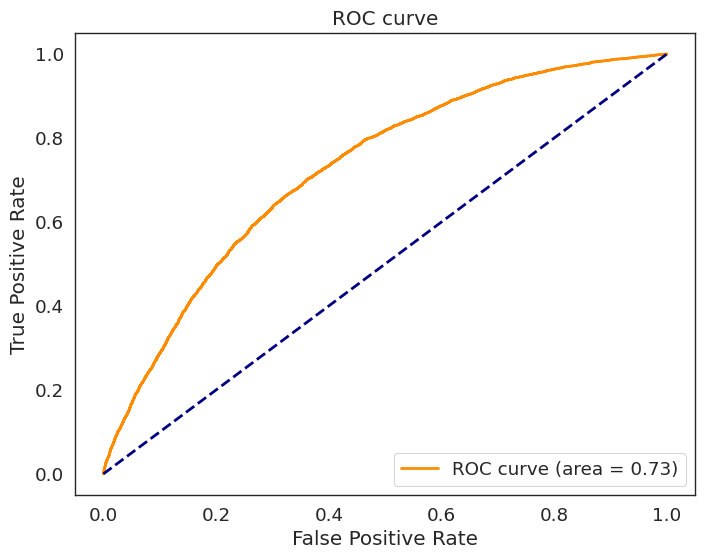

In [74]:
# visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('visuals/roc_curve_mpnn.png', dpi=300)
plt.show()


In [75]:
# visualize confidence_percentages in plot
plt.figure(figsize=(8, 6))
plt.hist(confidence_percentages, bins=50)
plt.title('Confidence Histogram')
plt.xlabel('Confidence Percentage')
plt.ylabel('Frequency')
plt.savefig('visuals/confidence_histogram_mpnn.png', dpi=300)
plt.show()


In [76]:
# Sort test predictions by confidence and get top 10 indices
sorted_pairs = sorted(enumerate(confidence_percentages), key=lambda x: x[1], reverse=True)
top_molecules_test_indices = [index for index, _ in sorted_pairs[:20]]

# The indices in test_graphs correspond to their positions in the original loaded_graphs_orig
# Find the original indices in loaded_graphs_orig
original_indices = [loaded_graphs_orig.index(test_graphs[i]) for i in top_molecules_test_indices]

# Use the original indices to look up the corresponding rows in reconstructed_df
top_molecule_row_indices = reconstructed_df.index[original_indices]

# Now, top_molecule_row_indices contains the DataFrame indices of the top 10 RNA-binding molecules


In [77]:
# create folder 'top_molecules' if it does not exist
if not os.path.exists('top_molecules_mpnn'):
    os.mkdir('top_molecules_mpnn')
    

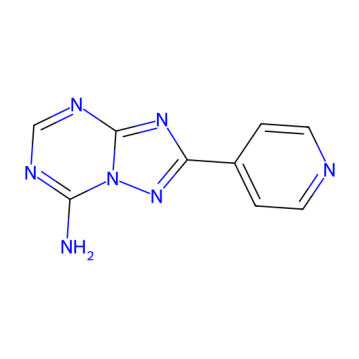

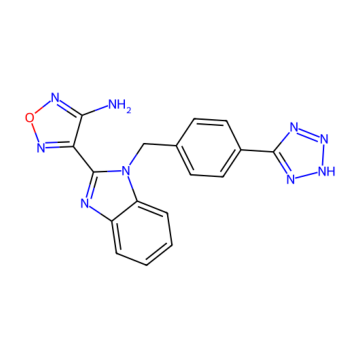

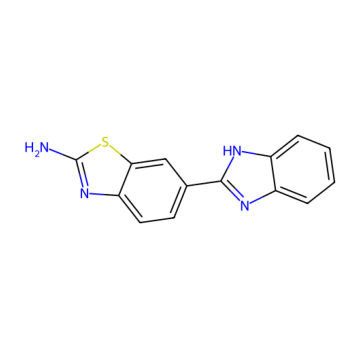

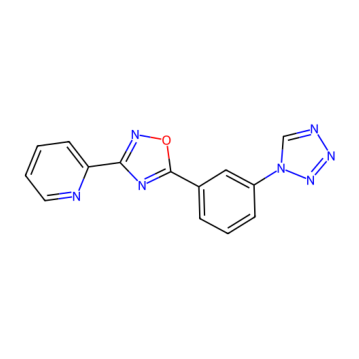

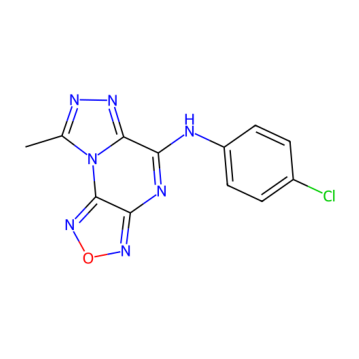

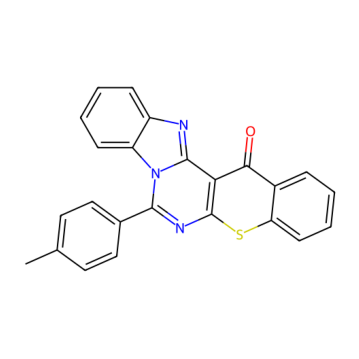

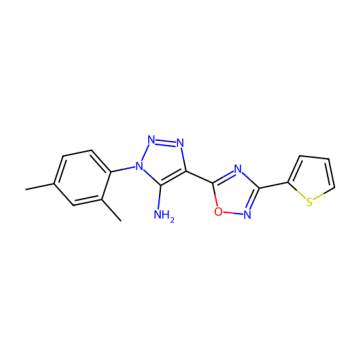

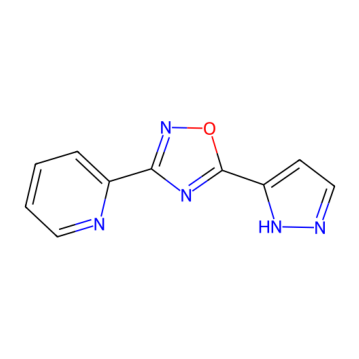

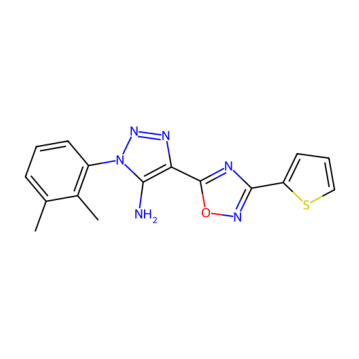

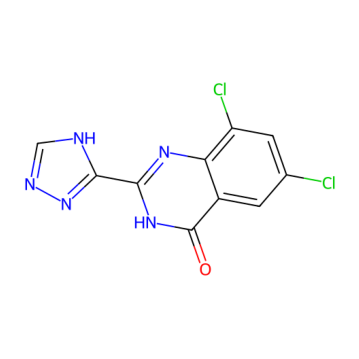

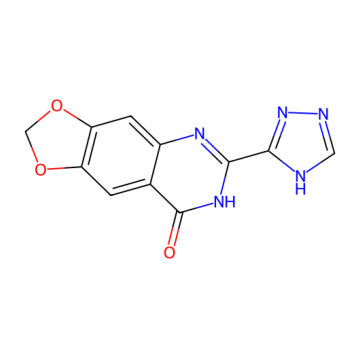

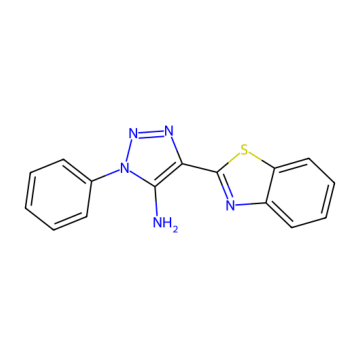

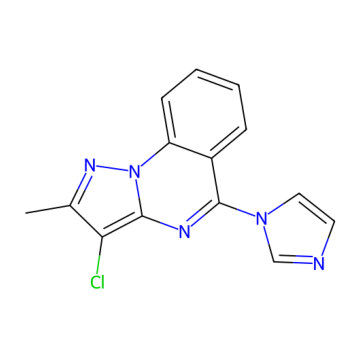

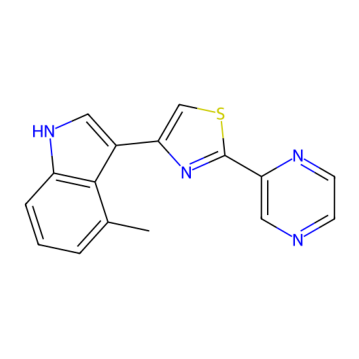

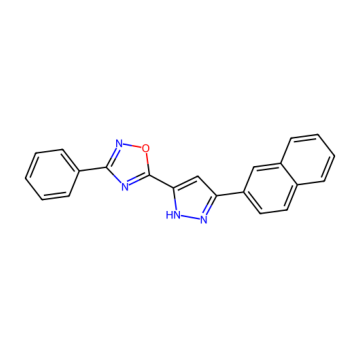

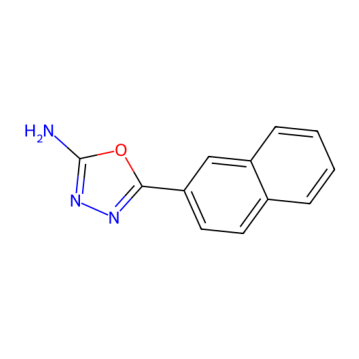

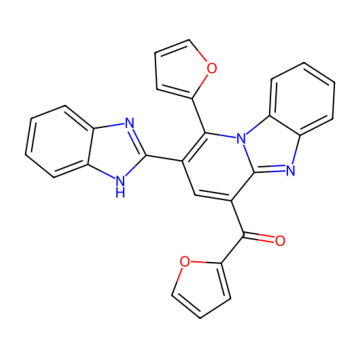

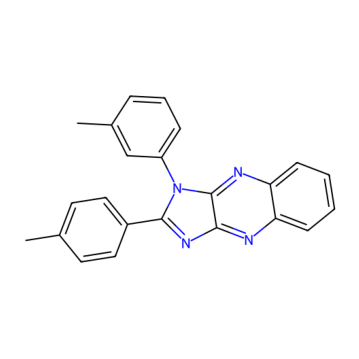

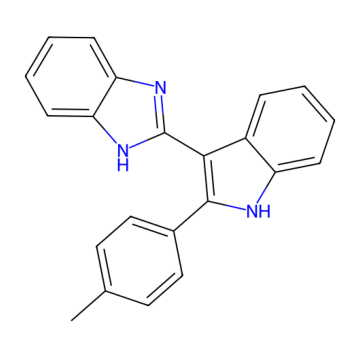

In [78]:
# Retrieve the SMILES codes and source information for the top 10 molecules
top_smiles = df_small.iloc[top_molecule_row_indices]['SMILES'].tolist()
top_sources = df_small.iloc[top_molecule_row_indices]['source'].tolist()

# Retrieve the confidence scores using the indices relative to the test dataset
top_confidences = [confidence_percentages[i] for i in top_molecules_test_indices]

# Convert SMILES to RDKit Mol objects
mols = [Chem.MolFromSmiles(smile) for smile in top_smiles]

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(500, 500))
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    # title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    # plt.title(title)
    plt.subplots_adjust(bottom=0.20)  # Adjust the position of the title
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_mpnn/molecule_{i+1}_{top_sources[i]}_a.png", dpi=300)
    plt.show()


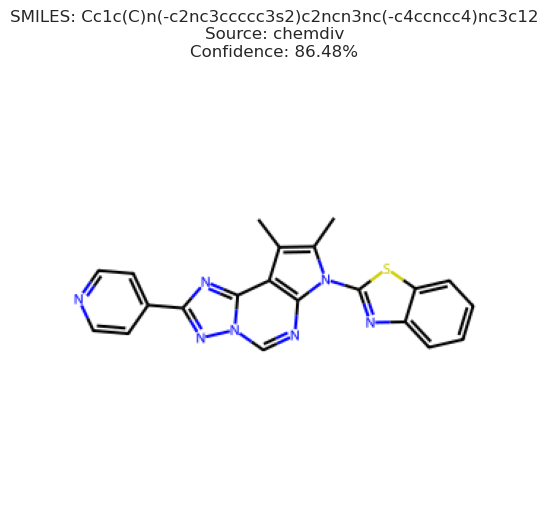

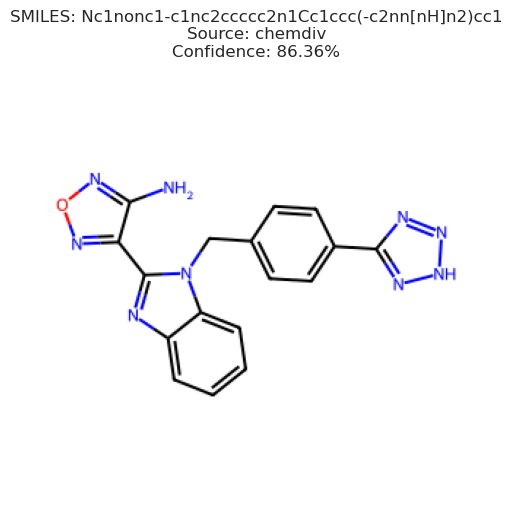

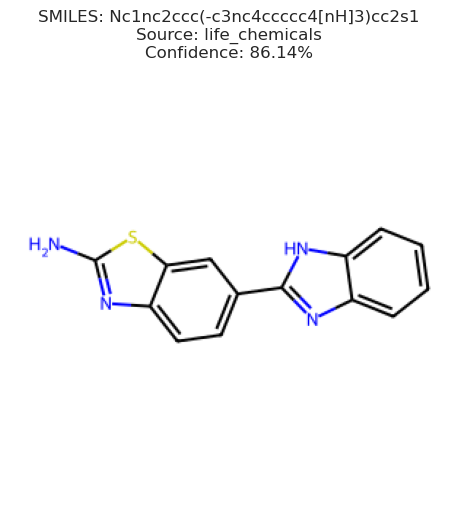

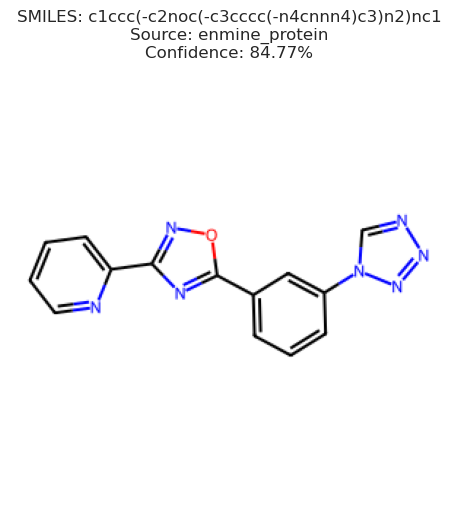

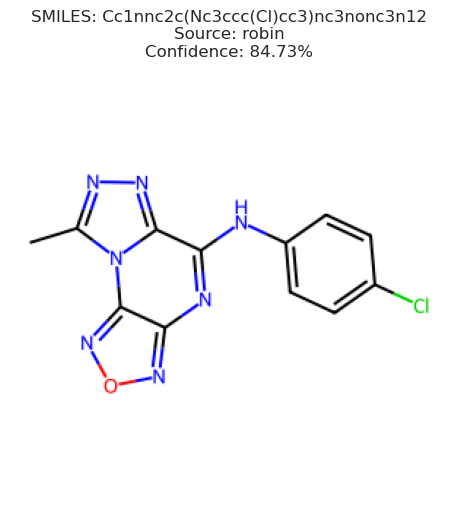

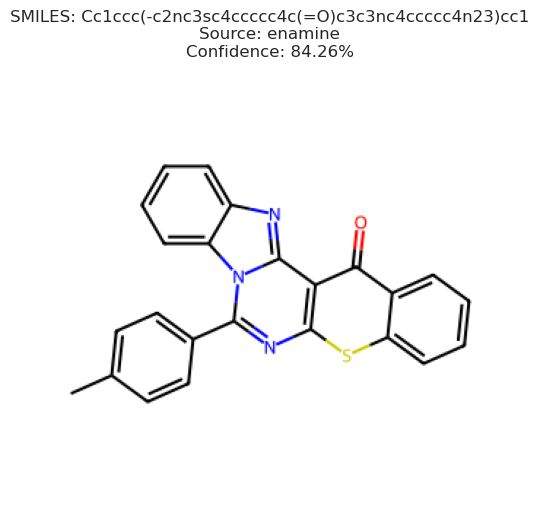

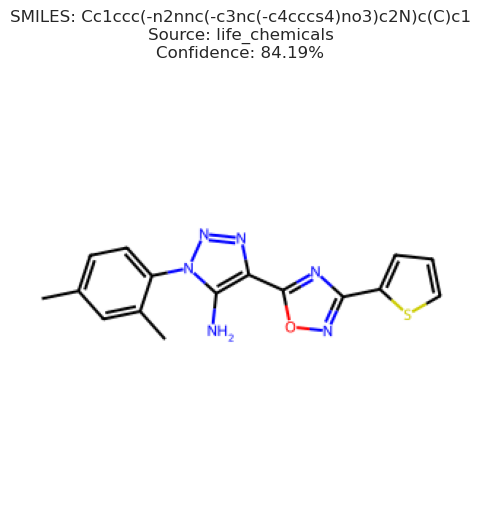

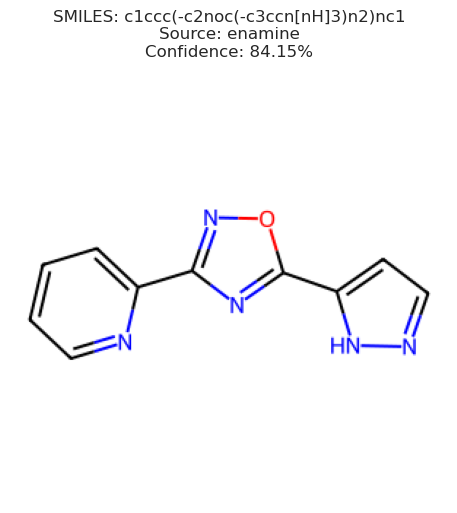

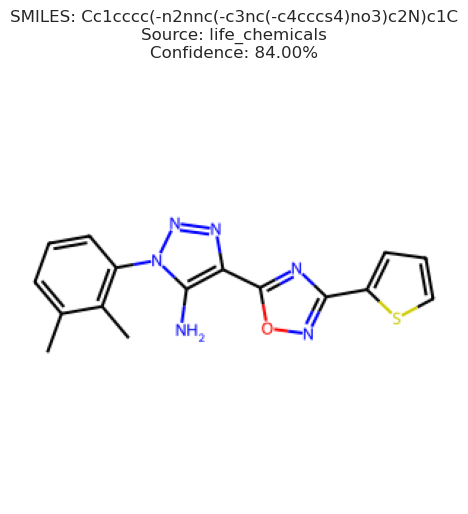

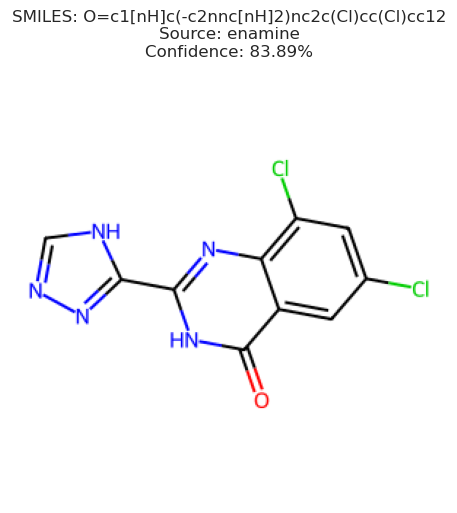

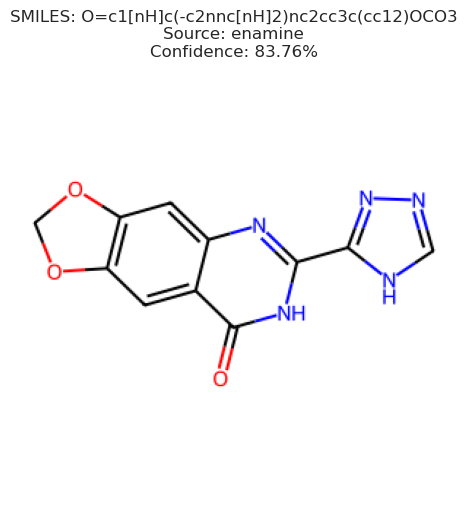

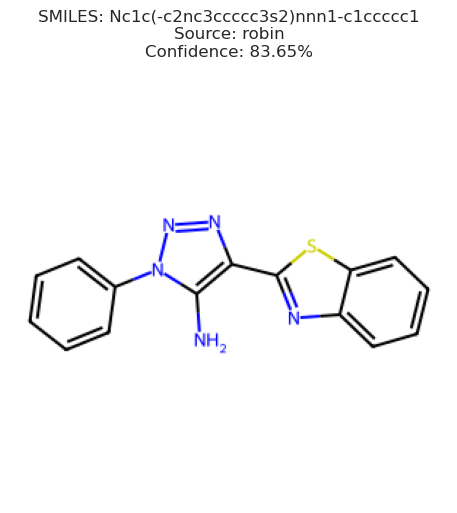

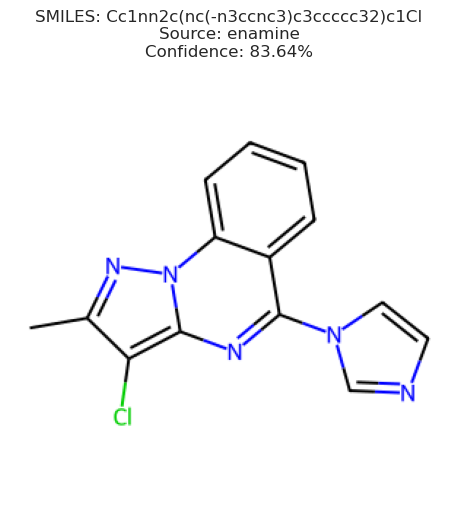

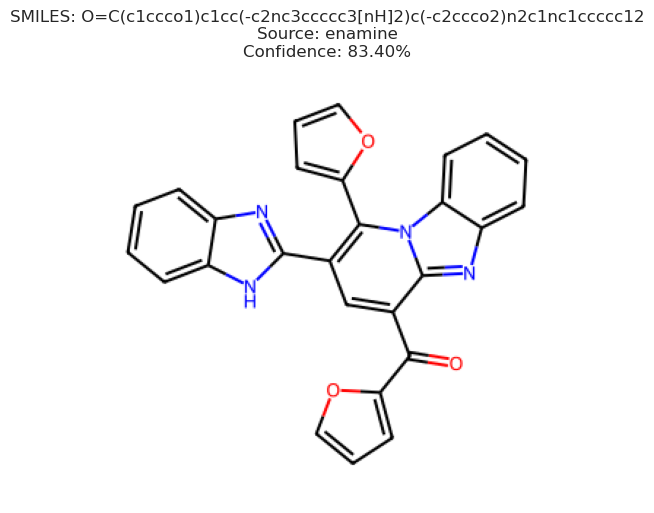

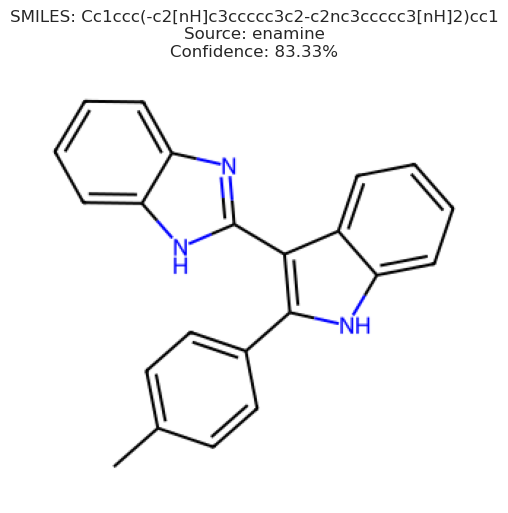

In [79]:
# Define the figure size and font size for titles
fig_size = (6, 6)
title_font_size = 12

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(300, 300))
    
    # Create a figure with adjusted size
    plt.figure(figsize=fig_size)
    plt.imshow(img)
    
    # Adjust the position of the text within the image
    title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    plt.title(title, fontsize=title_font_size)
    plt.subplots_adjust(bottom=0.15)  # Adjust the position of the title
    
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_mpnn/molecule_{i+1}_{top_sources[i]}_b.png", dpi=300)
    # plt.show()


# Graph Attention Networks (GAT)

In [80]:
class GATClassifier(nn.Module):
    def __init__(self, in_feats, hidden_size, num_heads=1):
        super(GATClassifier, self).__init__()
        self.conv1 = dglnn.GATConv(in_feats, hidden_size, num_heads=num_heads)

        # Adjusted to account for the mean aggregation of head outputs
        self.fc = nn.Linear(hidden_size, 1)  # For binary classification

    def forward(self, g, features):
        # Apply GAT convolution
        gat_output = self.conv1(g, features)  # Shape: [num_nodes, num_heads, hidden_size]

        # Mean over heads
        x = F.elu(gat_output.mean(1))  # Now shape: [num_nodes, hidden_size]
        
        # Update node features
        g.ndata['h'] = x

        # Aggregate node features across the graph
        x = dgl.mean_nodes(g, 'h')

        # Pass through the fully connected layer
        return self.fc(x)


## Instance of the the GAT Model

In [81]:
# Instantiate the model
in_feats = train_graphs[0].ndata['h'].shape[1]  # Replace with your feature size
model = GATClassifier(in_feats, hidden_size=148, num_heads=4).to(device)  # hidden_size is set to 74

# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()  # Use this loss if you are using a sigmoid activation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Train the GAT model

In [82]:
num_epochs = 500
early_stopping = EarlyStopping(patience=25, min_delta=0.002)

# Initialize lists to store loss values
gat_train_loss_list = []
gat_val_loss_list = []

for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_loader, criterion, optimizer, device)
    gat_train_loss_list.append(train_loss)  # Store train loss

    # Validation
    val_loss, _, _, _ = validate(model, val_loader, criterion, device)
    gat_val_loss_list.append(val_loss)  # Store validation loss

    # Print and check for early stopping
    print(f"Epoch: {epoch+1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
    early_stopping(val_loss, epoch)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break
    
# Store the epoch number when early stopping was triggered
num_epochs_early = early_stopping.stopped_epoch + 1



Epoch: 1, train_loss: 0.6917, val_loss: 0.6901


Epoch: 2, train_loss: 0.6883, val_loss: 0.6866


Epoch: 3, train_loss: 0.6846, val_loss: 0.6829


Epoch: 4, train_loss: 0.6808, val_loss: 0.6789


Epoch: 5, train_loss: 0.6766, val_loss: 0.6745


Epoch: 6, train_loss: 0.6718, val_loss: 0.6698


Epoch: 7, train_loss: 0.6669, val_loss: 0.6648


Epoch: 8, train_loss: 0.6615, val_loss: 0.6595


Epoch: 9, train_loss: 0.6561, val_loss: 0.6540


Epoch: 10, train_loss: 0.6506, val_loss: 0.6482


Epoch: 11, train_loss: 0.6448, val_loss: 0.6426


Epoch: 12, train_loss: 0.6392, val_loss: 0.6370


Epoch: 13, train_loss: 0.6337, val_loss: 0.6317


Epoch: 14, train_loss: 0.6270, val_loss: 0.6267


Epoch: 15, train_loss: 0.6229, val_loss: 0.6222


Epoch: 16, train_loss: 0.6188, val_loss: 0.6184


Epoch: 17, train_loss: 0.6150, val_loss: 0.6150


Epoch: 18, train_loss: 0.6112, val_loss: 0.6123


Epoch: 19, train_loss: 0.6090, val_loss: 0.6096


Epoch: 20, train_loss: 0.6065, val_loss: 0.6075


Epoch: 21, train_loss: 0.6042, val_loss: 0.6056


Epoch: 22, train_loss: 0.6027, val_loss: 0.6038


Epoch: 23, train_loss: 0.6014, val_loss: 0.6022


Epoch: 24, train_loss: 0.5996, val_loss: 0.6009


Epoch: 25, train_loss: 0.5970, val_loss: 0.5996


Epoch: 26, train_loss: 0.5968, val_loss: 0.5984


Epoch: 27, train_loss: 0.5951, val_loss: 0.5974


Epoch: 28, train_loss: 0.5938, val_loss: 0.5965


Epoch: 29, train_loss: 0.5935, val_loss: 0.5955


Epoch: 30, train_loss: 0.5921, val_loss: 0.5946


Epoch: 31, train_loss: 0.5919, val_loss: 0.5938


Epoch: 32, train_loss: 0.5902, val_loss: 0.5931


Epoch: 33, train_loss: 0.5897, val_loss: 0.5927


Epoch: 34, train_loss: 0.5892, val_loss: 0.5918


Epoch: 35, train_loss: 0.5886, val_loss: 0.5912


Epoch: 36, train_loss: 0.5879, val_loss: 0.5907


Epoch: 37, train_loss: 0.5867, val_loss: 0.5901


Epoch: 38, train_loss: 0.5858, val_loss: 0.5897


Epoch: 39, train_loss: 0.5863, val_loss: 0.5890


Epoch: 40, train_loss: 0.5848, val_loss: 0.5885


Epoch: 41, train_loss: 0.5846, val_loss: 0.5881


Epoch: 42, train_loss: 0.5846, val_loss: 0.5877


Epoch: 43, train_loss: 0.5841, val_loss: 0.5872


Epoch: 44, train_loss: 0.5830, val_loss: 0.5866


Epoch: 45, train_loss: 0.5827, val_loss: 0.5861


Epoch: 46, train_loss: 0.5828, val_loss: 0.5856


Epoch: 47, train_loss: 0.5821, val_loss: 0.5852


Epoch: 48, train_loss: 0.5815, val_loss: 0.5847


Epoch: 49, train_loss: 0.5801, val_loss: 0.5845


Epoch: 50, train_loss: 0.5805, val_loss: 0.5840


Epoch: 51, train_loss: 0.5800, val_loss: 0.5834


Epoch: 52, train_loss: 0.5795, val_loss: 0.5830


Epoch: 53, train_loss: 0.5785, val_loss: 0.5826


Epoch: 54, train_loss: 0.5785, val_loss: 0.5819


Epoch: 55, train_loss: 0.5788, val_loss: 0.5812


Epoch: 56, train_loss: 0.5772, val_loss: 0.5806


Epoch: 57, train_loss: 0.5771, val_loss: 0.5800


Epoch: 58, train_loss: 0.5756, val_loss: 0.5791


Epoch: 59, train_loss: 0.5751, val_loss: 0.5784


Epoch: 60, train_loss: 0.5737, val_loss: 0.5777


Epoch: 61, train_loss: 0.5741, val_loss: 0.5771


Epoch: 62, train_loss: 0.5735, val_loss: 0.5766


Epoch: 63, train_loss: 0.5725, val_loss: 0.5761


Epoch: 64, train_loss: 0.5727, val_loss: 0.5756


Epoch: 65, train_loss: 0.5703, val_loss: 0.5751


Epoch: 66, train_loss: 0.5712, val_loss: 0.5746


Epoch: 67, train_loss: 0.5706, val_loss: 0.5742


Epoch: 68, train_loss: 0.5710, val_loss: 0.5741


Epoch: 69, train_loss: 0.5693, val_loss: 0.5732


Epoch: 70, train_loss: 0.5689, val_loss: 0.5729


Epoch: 71, train_loss: 0.5690, val_loss: 0.5724


Epoch: 72, train_loss: 0.5678, val_loss: 0.5719


Epoch: 73, train_loss: 0.5678, val_loss: 0.5714


Epoch: 74, train_loss: 0.5668, val_loss: 0.5710


Epoch: 75, train_loss: 0.5659, val_loss: 0.5707


Epoch: 76, train_loss: 0.5663, val_loss: 0.5702


Epoch: 77, train_loss: 0.5658, val_loss: 0.5699


Epoch: 78, train_loss: 0.5662, val_loss: 0.5696


Epoch: 79, train_loss: 0.5648, val_loss: 0.5691


Epoch: 80, train_loss: 0.5642, val_loss: 0.5687


Epoch: 81, train_loss: 0.5640, val_loss: 0.5685


Epoch: 82, train_loss: 0.5646, val_loss: 0.5687


Epoch: 83, train_loss: 0.5637, val_loss: 0.5676


Epoch: 84, train_loss: 0.5635, val_loss: 0.5673


Epoch: 85, train_loss: 0.5623, val_loss: 0.5672


Epoch: 86, train_loss: 0.5629, val_loss: 0.5669


Epoch: 87, train_loss: 0.5619, val_loss: 0.5663


Epoch: 88, train_loss: 0.5610, val_loss: 0.5662


Epoch: 89, train_loss: 0.5628, val_loss: 0.5662


Epoch: 90, train_loss: 0.5610, val_loss: 0.5654


Epoch: 91, train_loss: 0.5612, val_loss: 0.5651


Epoch: 92, train_loss: 0.5598, val_loss: 0.5647


Epoch: 93, train_loss: 0.5592, val_loss: 0.5644


Epoch: 94, train_loss: 0.5596, val_loss: 0.5644


Epoch: 95, train_loss: 0.5587, val_loss: 0.5638


Epoch: 96, train_loss: 0.5592, val_loss: 0.5635


Epoch: 97, train_loss: 0.5591, val_loss: 0.5632


Epoch: 98, train_loss: 0.5580, val_loss: 0.5629


Epoch: 99, train_loss: 0.5583, val_loss: 0.5629


Epoch: 100, train_loss: 0.5580, val_loss: 0.5624


Epoch: 101, train_loss: 0.5577, val_loss: 0.5622


Epoch: 102, train_loss: 0.5572, val_loss: 0.5619


Epoch: 103, train_loss: 0.5578, val_loss: 0.5618


Epoch: 104, train_loss: 0.5569, val_loss: 0.5616


Epoch: 105, train_loss: 0.5561, val_loss: 0.5614


Epoch: 106, train_loss: 0.5568, val_loss: 0.5610


Epoch: 107, train_loss: 0.5566, val_loss: 0.5606


Epoch: 108, train_loss: 0.5553, val_loss: 0.5605


Epoch: 109, train_loss: 0.5546, val_loss: 0.5601


Epoch: 110, train_loss: 0.5551, val_loss: 0.5599


Epoch: 111, train_loss: 0.5562, val_loss: 0.5597


Epoch: 112, train_loss: 0.5552, val_loss: 0.5593


Epoch: 113, train_loss: 0.5543, val_loss: 0.5590


Epoch: 114, train_loss: 0.5540, val_loss: 0.5592


Epoch: 115, train_loss: 0.5531, val_loss: 0.5584


Epoch: 116, train_loss: 0.5528, val_loss: 0.5581


Epoch: 117, train_loss: 0.5533, val_loss: 0.5578


Epoch: 118, train_loss: 0.5523, val_loss: 0.5575


Epoch: 119, train_loss: 0.5532, val_loss: 0.5574


Epoch: 120, train_loss: 0.5516, val_loss: 0.5571


Epoch: 121, train_loss: 0.5516, val_loss: 0.5568


Epoch: 122, train_loss: 0.5510, val_loss: 0.5566


Epoch: 123, train_loss: 0.5508, val_loss: 0.5563


Epoch: 124, train_loss: 0.5524, val_loss: 0.5561


Epoch: 125, train_loss: 0.5512, val_loss: 0.5558


Epoch: 126, train_loss: 0.5503, val_loss: 0.5556


Epoch: 127, train_loss: 0.5500, val_loss: 0.5559


Epoch: 128, train_loss: 0.5501, val_loss: 0.5552


Epoch: 129, train_loss: 0.5501, val_loss: 0.5551


Epoch: 130, train_loss: 0.5485, val_loss: 0.5547


Epoch: 131, train_loss: 0.5487, val_loss: 0.5548


Epoch: 132, train_loss: 0.5498, val_loss: 0.5542


Epoch: 133, train_loss: 0.5481, val_loss: 0.5539


Epoch: 134, train_loss: 0.5479, val_loss: 0.5537


Epoch: 135, train_loss: 0.5485, val_loss: 0.5535


Epoch: 136, train_loss: 0.5488, val_loss: 0.5532


Epoch: 137, train_loss: 0.5477, val_loss: 0.5529


Epoch: 138, train_loss: 0.5478, val_loss: 0.5527


Epoch: 139, train_loss: 0.5480, val_loss: 0.5524


Epoch: 140, train_loss: 0.5471, val_loss: 0.5523


Epoch: 141, train_loss: 0.5461, val_loss: 0.5519


Epoch: 142, train_loss: 0.5455, val_loss: 0.5518


Epoch: 143, train_loss: 0.5464, val_loss: 0.5514


Epoch: 144, train_loss: 0.5456, val_loss: 0.5511


Epoch: 145, train_loss: 0.5466, val_loss: 0.5508


Epoch: 146, train_loss: 0.5446, val_loss: 0.5507


Epoch: 147, train_loss: 0.5447, val_loss: 0.5504


Epoch: 148, train_loss: 0.5442, val_loss: 0.5502


Epoch: 149, train_loss: 0.5444, val_loss: 0.5500


Epoch: 150, train_loss: 0.5444, val_loss: 0.5497


Epoch: 151, train_loss: 0.5446, val_loss: 0.5497


Epoch: 152, train_loss: 0.5443, val_loss: 0.5494


Epoch: 153, train_loss: 0.5424, val_loss: 0.5493


Epoch: 154, train_loss: 0.5431, val_loss: 0.5490


Epoch: 155, train_loss: 0.5423, val_loss: 0.5487


Epoch: 156, train_loss: 0.5417, val_loss: 0.5486


Epoch: 157, train_loss: 0.5437, val_loss: 0.5482


Epoch: 158, train_loss: 0.5434, val_loss: 0.5486


Epoch: 159, train_loss: 0.5425, val_loss: 0.5478


Epoch: 160, train_loss: 0.5421, val_loss: 0.5475


Epoch: 161, train_loss: 0.5413, val_loss: 0.5474


Epoch: 162, train_loss: 0.5414, val_loss: 0.5473


Epoch: 163, train_loss: 0.5404, val_loss: 0.5470


Epoch: 164, train_loss: 0.5406, val_loss: 0.5468


Epoch: 165, train_loss: 0.5405, val_loss: 0.5465


Epoch: 166, train_loss: 0.5410, val_loss: 0.5463


Epoch: 167, train_loss: 0.5403, val_loss: 0.5466


Epoch: 168, train_loss: 0.5400, val_loss: 0.5459


Epoch: 169, train_loss: 0.5390, val_loss: 0.5457


Epoch: 170, train_loss: 0.5403, val_loss: 0.5458


Epoch: 171, train_loss: 0.5393, val_loss: 0.5454


Epoch: 172, train_loss: 0.5385, val_loss: 0.5452


Epoch: 173, train_loss: 0.5393, val_loss: 0.5450


Epoch: 174, train_loss: 0.5378, val_loss: 0.5448


Epoch: 175, train_loss: 0.5373, val_loss: 0.5447


Epoch: 176, train_loss: 0.5377, val_loss: 0.5446


Epoch: 177, train_loss: 0.5379, val_loss: 0.5445


Epoch: 178, train_loss: 0.5375, val_loss: 0.5441


Epoch: 179, train_loss: 0.5372, val_loss: 0.5440


Epoch: 180, train_loss: 0.5372, val_loss: 0.5439


Epoch: 181, train_loss: 0.5384, val_loss: 0.5438


Epoch: 182, train_loss: 0.5379, val_loss: 0.5434


Epoch: 183, train_loss: 0.5366, val_loss: 0.5432


Epoch: 184, train_loss: 0.5367, val_loss: 0.5432


Epoch: 185, train_loss: 0.5362, val_loss: 0.5429


Epoch: 186, train_loss: 0.5361, val_loss: 0.5426


Epoch: 187, train_loss: 0.5355, val_loss: 0.5427


Epoch: 188, train_loss: 0.5361, val_loss: 0.5425


Epoch: 189, train_loss: 0.5351, val_loss: 0.5421


Epoch: 190, train_loss: 0.5363, val_loss: 0.5423


Epoch: 191, train_loss: 0.5347, val_loss: 0.5417


Epoch: 192, train_loss: 0.5352, val_loss: 0.5415


Epoch: 193, train_loss: 0.5352, val_loss: 0.5416


Epoch: 194, train_loss: 0.5346, val_loss: 0.5412


Epoch: 195, train_loss: 0.5343, val_loss: 0.5411


Epoch: 196, train_loss: 0.5348, val_loss: 0.5409


Epoch: 197, train_loss: 0.5337, val_loss: 0.5407


Epoch: 198, train_loss: 0.5345, val_loss: 0.5406


Epoch: 199, train_loss: 0.5332, val_loss: 0.5405


Epoch: 200, train_loss: 0.5333, val_loss: 0.5404


Epoch: 201, train_loss: 0.5335, val_loss: 0.5406


Epoch: 202, train_loss: 0.5336, val_loss: 0.5398


Epoch: 203, train_loss: 0.5332, val_loss: 0.5397


Epoch: 204, train_loss: 0.5333, val_loss: 0.5408


Epoch: 205, train_loss: 0.5320, val_loss: 0.5395


Epoch: 206, train_loss: 0.5325, val_loss: 0.5391


Epoch: 207, train_loss: 0.5329, val_loss: 0.5391


Epoch: 208, train_loss: 0.5319, val_loss: 0.5389


Epoch: 209, train_loss: 0.5321, val_loss: 0.5390


Epoch: 210, train_loss: 0.5312, val_loss: 0.5385


Epoch: 211, train_loss: 0.5314, val_loss: 0.5384


Epoch: 212, train_loss: 0.5306, val_loss: 0.5383


Epoch: 213, train_loss: 0.5326, val_loss: 0.5380


Epoch: 214, train_loss: 0.5305, val_loss: 0.5377


Epoch: 215, train_loss: 0.5307, val_loss: 0.5375


Epoch: 216, train_loss: 0.5301, val_loss: 0.5373


Epoch: 217, train_loss: 0.5307, val_loss: 0.5372


Epoch: 218, train_loss: 0.5303, val_loss: 0.5373


Epoch: 219, train_loss: 0.5316, val_loss: 0.5369


Epoch: 220, train_loss: 0.5295, val_loss: 0.5367


Epoch: 221, train_loss: 0.5284, val_loss: 0.5366


Epoch: 222, train_loss: 0.5296, val_loss: 0.5366


Epoch: 223, train_loss: 0.5287, val_loss: 0.5363


Epoch: 224, train_loss: 0.5294, val_loss: 0.5361


Epoch: 225, train_loss: 0.5283, val_loss: 0.5360


Epoch: 226, train_loss: 0.5274, val_loss: 0.5359


Epoch: 227, train_loss: 0.5279, val_loss: 0.5357


Epoch: 228, train_loss: 0.5276, val_loss: 0.5357


Epoch: 229, train_loss: 0.5274, val_loss: 0.5357


Epoch: 230, train_loss: 0.5292, val_loss: 0.5353


Epoch: 231, train_loss: 0.5282, val_loss: 0.5355


Epoch: 232, train_loss: 0.5275, val_loss: 0.5351


Epoch: 233, train_loss: 0.5290, val_loss: 0.5352


Epoch: 234, train_loss: 0.5273, val_loss: 0.5348


Epoch: 235, train_loss: 0.5280, val_loss: 0.5347


Epoch: 236, train_loss: 0.5270, val_loss: 0.5347


Epoch: 237, train_loss: 0.5264, val_loss: 0.5345


Epoch: 238, train_loss: 0.5270, val_loss: 0.5344


Epoch: 239, train_loss: 0.5275, val_loss: 0.5342


Epoch: 240, train_loss: 0.5266, val_loss: 0.5341


Epoch: 241, train_loss: 0.5284, val_loss: 0.5339


Epoch: 242, train_loss: 0.5271, val_loss: 0.5338


Epoch: 243, train_loss: 0.5274, val_loss: 0.5337


Epoch: 244, train_loss: 0.5264, val_loss: 0.5339


Epoch: 245, train_loss: 0.5264, val_loss: 0.5335


Epoch: 246, train_loss: 0.5255, val_loss: 0.5333


Epoch: 247, train_loss: 0.5248, val_loss: 0.5335


Epoch: 248, train_loss: 0.5258, val_loss: 0.5331


Epoch: 249, train_loss: 0.5254, val_loss: 0.5340


Epoch: 250, train_loss: 0.5268, val_loss: 0.5329


Epoch: 251, train_loss: 0.5249, val_loss: 0.5328


Epoch: 252, train_loss: 0.5254, val_loss: 0.5329


Epoch: 253, train_loss: 0.5253, val_loss: 0.5326


Epoch: 254, train_loss: 0.5241, val_loss: 0.5326


Epoch: 255, train_loss: 0.5244, val_loss: 0.5324


Epoch: 256, train_loss: 0.5251, val_loss: 0.5327


Epoch: 257, train_loss: 0.5240, val_loss: 0.5322


Epoch: 258, train_loss: 0.5239, val_loss: 0.5321


Epoch: 259, train_loss: 0.5240, val_loss: 0.5320


Epoch: 260, train_loss: 0.5235, val_loss: 0.5318


Epoch: 261, train_loss: 0.5233, val_loss: 0.5321


Epoch: 262, train_loss: 0.5248, val_loss: 0.5317


Epoch: 263, train_loss: 0.5232, val_loss: 0.5315


Epoch: 264, train_loss: 0.5239, val_loss: 0.5314


Epoch: 265, train_loss: 0.5226, val_loss: 0.5318


Epoch: 266, train_loss: 0.5238, val_loss: 0.5312


Epoch: 267, train_loss: 0.5237, val_loss: 0.5311


Epoch: 268, train_loss: 0.5222, val_loss: 0.5311


Epoch: 269, train_loss: 0.5228, val_loss: 0.5309


Epoch: 270, train_loss: 0.5233, val_loss: 0.5309


Epoch: 271, train_loss: 0.5240, val_loss: 0.5306


Epoch: 272, train_loss: 0.5222, val_loss: 0.5304


Epoch: 273, train_loss: 0.5232, val_loss: 0.5303


Epoch: 274, train_loss: 0.5222, val_loss: 0.5305


Epoch: 275, train_loss: 0.5222, val_loss: 0.5303


Epoch: 276, train_loss: 0.5222, val_loss: 0.5300


Epoch: 277, train_loss: 0.5222, val_loss: 0.5301


Epoch: 278, train_loss: 0.5227, val_loss: 0.5299


Epoch: 279, train_loss: 0.5213, val_loss: 0.5301


Epoch: 280, train_loss: 0.5216, val_loss: 0.5297


Epoch: 281, train_loss: 0.5227, val_loss: 0.5308


Epoch: 282, train_loss: 0.5205, val_loss: 0.5296


Epoch: 283, train_loss: 0.5221, val_loss: 0.5295


Epoch: 284, train_loss: 0.5218, val_loss: 0.5294


Epoch: 285, train_loss: 0.5215, val_loss: 0.5293


Epoch: 286, train_loss: 0.5216, val_loss: 0.5291


Epoch: 287, train_loss: 0.5218, val_loss: 0.5291


Epoch: 288, train_loss: 0.5209, val_loss: 0.5295


Epoch: 289, train_loss: 0.5205, val_loss: 0.5288


Epoch: 290, train_loss: 0.5205, val_loss: 0.5288


Epoch: 291, train_loss: 0.5197, val_loss: 0.5285


Epoch: 292, train_loss: 0.5193, val_loss: 0.5285


Epoch: 293, train_loss: 0.5206, val_loss: 0.5283


Epoch: 294, train_loss: 0.5194, val_loss: 0.5284


Epoch: 295, train_loss: 0.5198, val_loss: 0.5283


Epoch: 296, train_loss: 0.5204, val_loss: 0.5283


Epoch: 297, train_loss: 0.5203, val_loss: 0.5280


Epoch: 298, train_loss: 0.5193, val_loss: 0.5288


Epoch: 299, train_loss: 0.5184, val_loss: 0.5278


Epoch: 300, train_loss: 0.5192, val_loss: 0.5278


Epoch: 301, train_loss: 0.5189, val_loss: 0.5277


Epoch: 302, train_loss: 0.5194, val_loss: 0.5276


Epoch: 303, train_loss: 0.5182, val_loss: 0.5275


Epoch: 304, train_loss: 0.5184, val_loss: 0.5274


Epoch: 305, train_loss: 0.5186, val_loss: 0.5282


Epoch: 306, train_loss: 0.5188, val_loss: 0.5275


Epoch: 307, train_loss: 0.5179, val_loss: 0.5272


Epoch: 308, train_loss: 0.5179, val_loss: 0.5272


Epoch: 309, train_loss: 0.5176, val_loss: 0.5271


Epoch: 310, train_loss: 0.5180, val_loss: 0.5271


Epoch: 311, train_loss: 0.5200, val_loss: 0.5278


Epoch: 312, train_loss: 0.5182, val_loss: 0.5268


Epoch: 313, train_loss: 0.5174, val_loss: 0.5267


Epoch: 314, train_loss: 0.5169, val_loss: 0.5267


Epoch: 315, train_loss: 0.5174, val_loss: 0.5267


Epoch: 316, train_loss: 0.5185, val_loss: 0.5266


Epoch: 317, train_loss: 0.5177, val_loss: 0.5264


Epoch: 318, train_loss: 0.5179, val_loss: 0.5265


Epoch: 319, train_loss: 0.5184, val_loss: 0.5268


Epoch: 320, train_loss: 0.5171, val_loss: 0.5262


Epoch: 321, train_loss: 0.5178, val_loss: 0.5263


Epoch: 322, train_loss: 0.5178, val_loss: 0.5261


Epoch: 323, train_loss: 0.5164, val_loss: 0.5262


Epoch: 324, train_loss: 0.5171, val_loss: 0.5259


Epoch: 325, train_loss: 0.5167, val_loss: 0.5258


Epoch: 326, train_loss: 0.5164, val_loss: 0.5259


Epoch: 327, train_loss: 0.5176, val_loss: 0.5262


Epoch: 328, train_loss: 0.5167, val_loss: 0.5257


Epoch: 329, train_loss: 0.5168, val_loss: 0.5255


Epoch: 330, train_loss: 0.5171, val_loss: 0.5261


Epoch: 331, train_loss: 0.5154, val_loss: 0.5253


Epoch: 332, train_loss: 0.5158, val_loss: 0.5265
Early stopping triggered at epoch 332


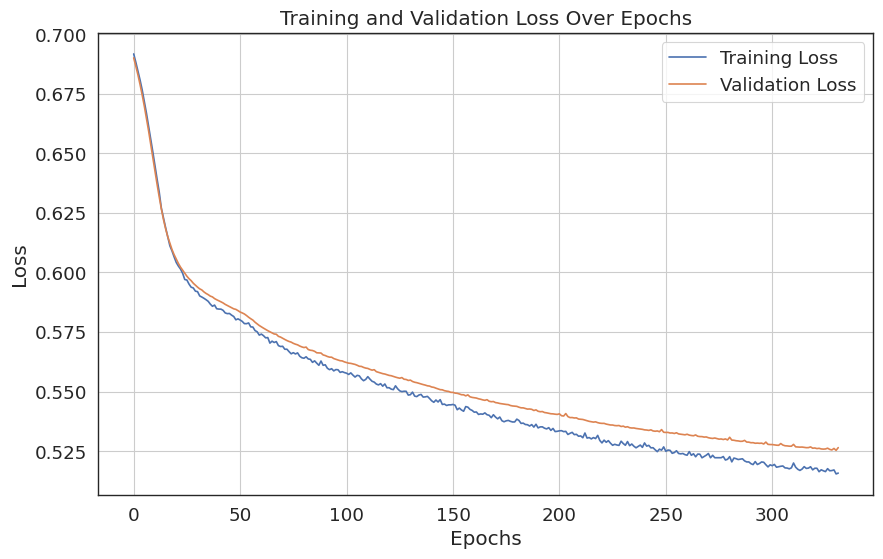

In [83]:
# Ensure that the length of gat_train_loss_list and gat_val_loss_list is equal to the number of epochs processed
assert len(gat_train_loss_list) == len(gat_val_loss_list)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gat_train_loss_list, label='Training Loss')
plt.plot(gat_val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Train on merged train and val sets


In [84]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.clone().detach().to(device)
        batch_features = batch_graphs.ndata['h']

        outputs = model(batch_graphs, batch_features)
        outputs = outputs.squeeze() # remove extra dimension
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

## Reset weights before training again with all data


In [85]:
def reset_weights(m):
    """
    This function will reset the weights of a given module.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Example usage with your model
model.apply(reset_weights)

GATClassifier(
  (conv1): GATConv(
    (fc): Linear(in_features=74, out_features=592, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (fc): Linear(in_features=148, out_features=1, bias=True)
)

In [86]:
print("Final training on merged training and validation sets")

# Initialize list to store loss values
final_train_losses = []

for epoch in range(num_epochs_early):
    # Training
    train_loss = train(model, train_loader_all, criterion, optimizer, device)
    final_train_losses.append(train_loss)  # Store train loss

    # Print train loss
    print(f"Epoch {epoch+1}/{num_epochs_early}, Train Loss: {train_loss:.4f}")


Final training on merged training and validation sets


Epoch 1/332, Train Loss: 0.6929


Epoch 2/332, Train Loss: 0.6903


Epoch 3/332, Train Loss: 0.6877


Epoch 4/332, Train Loss: 0.6850


Epoch 5/332, Train Loss: 0.6821


Epoch 6/332, Train Loss: 0.6790


Epoch 7/332, Train Loss: 0.6755


Epoch 8/332, Train Loss: 0.6718


Epoch 9/332, Train Loss: 0.6678


Epoch 10/332, Train Loss: 0.6637


Epoch 11/332, Train Loss: 0.6594


Epoch 12/332, Train Loss: 0.6550


Epoch 13/332, Train Loss: 0.6506


Epoch 14/332, Train Loss: 0.6464


Epoch 15/332, Train Loss: 0.6424


Epoch 16/332, Train Loss: 0.6388


Epoch 17/332, Train Loss: 0.6354


Epoch 18/332, Train Loss: 0.6323


Epoch 19/332, Train Loss: 0.6294


Epoch 20/332, Train Loss: 0.6268


Epoch 21/332, Train Loss: 0.6241


Epoch 22/332, Train Loss: 0.6213


Epoch 23/332, Train Loss: 0.6182


Epoch 24/332, Train Loss: 0.6151


Epoch 25/332, Train Loss: 0.6123


Epoch 26/332, Train Loss: 0.6097


Epoch 27/332, Train Loss: 0.6073


Epoch 28/332, Train Loss: 0.6052


Epoch 29/332, Train Loss: 0.6034


Epoch 30/332, Train Loss: 0.6017


Epoch 31/332, Train Loss: 0.6001


Epoch 32/332, Train Loss: 0.5987


Epoch 33/332, Train Loss: 0.5975


Epoch 34/332, Train Loss: 0.5965


Epoch 35/332, Train Loss: 0.5955


Epoch 36/332, Train Loss: 0.5947


Epoch 37/332, Train Loss: 0.5939


Epoch 38/332, Train Loss: 0.5932


Epoch 39/332, Train Loss: 0.5926


Epoch 40/332, Train Loss: 0.5919


Epoch 41/332, Train Loss: 0.5913


Epoch 42/332, Train Loss: 0.5908


Epoch 43/332, Train Loss: 0.5902


Epoch 44/332, Train Loss: 0.5897


Epoch 45/332, Train Loss: 0.5892


Epoch 46/332, Train Loss: 0.5887


Epoch 47/332, Train Loss: 0.5883


Epoch 48/332, Train Loss: 0.5878


Epoch 49/332, Train Loss: 0.5874


Epoch 50/332, Train Loss: 0.5870


Epoch 51/332, Train Loss: 0.5865


Epoch 52/332, Train Loss: 0.5860


Epoch 53/332, Train Loss: 0.5855


Epoch 54/332, Train Loss: 0.5850


Epoch 55/332, Train Loss: 0.5846


Epoch 56/332, Train Loss: 0.5842


Epoch 57/332, Train Loss: 0.5838


Epoch 58/332, Train Loss: 0.5834


Epoch 59/332, Train Loss: 0.5830


Epoch 60/332, Train Loss: 0.5826


Epoch 61/332, Train Loss: 0.5822


Epoch 62/332, Train Loss: 0.5818


Epoch 63/332, Train Loss: 0.5815


Epoch 64/332, Train Loss: 0.5811


Epoch 65/332, Train Loss: 0.5807


Epoch 66/332, Train Loss: 0.5804


Epoch 67/332, Train Loss: 0.5801


Epoch 68/332, Train Loss: 0.5797


Epoch 69/332, Train Loss: 0.5794


Epoch 70/332, Train Loss: 0.5791


Epoch 71/332, Train Loss: 0.5788


Epoch 72/332, Train Loss: 0.5785


Epoch 73/332, Train Loss: 0.5781


Epoch 74/332, Train Loss: 0.5778


Epoch 75/332, Train Loss: 0.5775


Epoch 76/332, Train Loss: 0.5772


Epoch 77/332, Train Loss: 0.5769


Epoch 78/332, Train Loss: 0.5766


Epoch 79/332, Train Loss: 0.5763


Epoch 80/332, Train Loss: 0.5760


Epoch 81/332, Train Loss: 0.5757


Epoch 82/332, Train Loss: 0.5753


Epoch 83/332, Train Loss: 0.5750


Epoch 84/332, Train Loss: 0.5747


Epoch 85/332, Train Loss: 0.5744


Epoch 86/332, Train Loss: 0.5741


Epoch 87/332, Train Loss: 0.5738


Epoch 88/332, Train Loss: 0.5735


Epoch 89/332, Train Loss: 0.5732


Epoch 90/332, Train Loss: 0.5729


Epoch 91/332, Train Loss: 0.5726


Epoch 92/332, Train Loss: 0.5723


Epoch 93/332, Train Loss: 0.5720


Epoch 94/332, Train Loss: 0.5717


Epoch 95/332, Train Loss: 0.5713


Epoch 96/332, Train Loss: 0.5710


Epoch 97/332, Train Loss: 0.5706


Epoch 98/332, Train Loss: 0.5703


Epoch 99/332, Train Loss: 0.5700


Epoch 100/332, Train Loss: 0.5696


Epoch 101/332, Train Loss: 0.5693


Epoch 102/332, Train Loss: 0.5690


Epoch 103/332, Train Loss: 0.5686


Epoch 104/332, Train Loss: 0.5682


Epoch 105/332, Train Loss: 0.5679


Epoch 106/332, Train Loss: 0.5675


Epoch 107/332, Train Loss: 0.5671


Epoch 108/332, Train Loss: 0.5667


Epoch 109/332, Train Loss: 0.5664


Epoch 110/332, Train Loss: 0.5660


Epoch 111/332, Train Loss: 0.5656


Epoch 112/332, Train Loss: 0.5653


Epoch 113/332, Train Loss: 0.5649


Epoch 114/332, Train Loss: 0.5645


Epoch 115/332, Train Loss: 0.5642


Epoch 116/332, Train Loss: 0.5638


Epoch 117/332, Train Loss: 0.5634


Epoch 118/332, Train Loss: 0.5630


Epoch 119/332, Train Loss: 0.5625


Epoch 120/332, Train Loss: 0.5622


Epoch 121/332, Train Loss: 0.5618


Epoch 122/332, Train Loss: 0.5615


Epoch 123/332, Train Loss: 0.5611


Epoch 124/332, Train Loss: 0.5608


Epoch 125/332, Train Loss: 0.5604


Epoch 126/332, Train Loss: 0.5601


Epoch 127/332, Train Loss: 0.5598


Epoch 128/332, Train Loss: 0.5595


Epoch 129/332, Train Loss: 0.5592


Epoch 130/332, Train Loss: 0.5589


Epoch 131/332, Train Loss: 0.5586


Epoch 132/332, Train Loss: 0.5583


Epoch 133/332, Train Loss: 0.5580


Epoch 134/332, Train Loss: 0.5578


Epoch 135/332, Train Loss: 0.5575


Epoch 136/332, Train Loss: 0.5572


Epoch 137/332, Train Loss: 0.5570


Epoch 138/332, Train Loss: 0.5567


Epoch 139/332, Train Loss: 0.5565


Epoch 140/332, Train Loss: 0.5562


Epoch 141/332, Train Loss: 0.5560


Epoch 142/332, Train Loss: 0.5557


Epoch 143/332, Train Loss: 0.5555


Epoch 144/332, Train Loss: 0.5553


Epoch 145/332, Train Loss: 0.5551


Epoch 146/332, Train Loss: 0.5548


Epoch 147/332, Train Loss: 0.5546


Epoch 148/332, Train Loss: 0.5544


Epoch 149/332, Train Loss: 0.5542


Epoch 150/332, Train Loss: 0.5540


Epoch 151/332, Train Loss: 0.5538


Epoch 152/332, Train Loss: 0.5536


Epoch 153/332, Train Loss: 0.5534


Epoch 154/332, Train Loss: 0.5532


Epoch 155/332, Train Loss: 0.5530


Epoch 156/332, Train Loss: 0.5528


Epoch 157/332, Train Loss: 0.5526


Epoch 158/332, Train Loss: 0.5524


Epoch 159/332, Train Loss: 0.5522


Epoch 160/332, Train Loss: 0.5520


Epoch 161/332, Train Loss: 0.5518


Epoch 162/332, Train Loss: 0.5517


Epoch 163/332, Train Loss: 0.5515


Epoch 164/332, Train Loss: 0.5513


Epoch 165/332, Train Loss: 0.5511


Epoch 166/332, Train Loss: 0.5509


Epoch 167/332, Train Loss: 0.5507


Epoch 168/332, Train Loss: 0.5505


Epoch 169/332, Train Loss: 0.5504


Epoch 170/332, Train Loss: 0.5502


Epoch 171/332, Train Loss: 0.5500


Epoch 172/332, Train Loss: 0.5498


Epoch 173/332, Train Loss: 0.5496


Epoch 174/332, Train Loss: 0.5494


Epoch 175/332, Train Loss: 0.5492


Epoch 176/332, Train Loss: 0.5490


Epoch 177/332, Train Loss: 0.5488


Epoch 178/332, Train Loss: 0.5486


Epoch 179/332, Train Loss: 0.5484


Epoch 180/332, Train Loss: 0.5482


Epoch 181/332, Train Loss: 0.5480


Epoch 182/332, Train Loss: 0.5478


Epoch 183/332, Train Loss: 0.5477


Epoch 184/332, Train Loss: 0.5475


Epoch 185/332, Train Loss: 0.5473


Epoch 186/332, Train Loss: 0.5471


Epoch 187/332, Train Loss: 0.5469


Epoch 188/332, Train Loss: 0.5468


Epoch 189/332, Train Loss: 0.5466


Epoch 190/332, Train Loss: 0.5464


Epoch 191/332, Train Loss: 0.5462


Epoch 192/332, Train Loss: 0.5461


Epoch 193/332, Train Loss: 0.5459


Epoch 194/332, Train Loss: 0.5457


Epoch 195/332, Train Loss: 0.5455


Epoch 196/332, Train Loss: 0.5454


Epoch 197/332, Train Loss: 0.5452


Epoch 198/332, Train Loss: 0.5450


Epoch 199/332, Train Loss: 0.5449


Epoch 200/332, Train Loss: 0.5447


Epoch 201/332, Train Loss: 0.5446


Epoch 202/332, Train Loss: 0.5444


Epoch 203/332, Train Loss: 0.5442


Epoch 204/332, Train Loss: 0.5441


Epoch 205/332, Train Loss: 0.5439


Epoch 206/332, Train Loss: 0.5438


Epoch 207/332, Train Loss: 0.5436


Epoch 208/332, Train Loss: 0.5435


Epoch 209/332, Train Loss: 0.5433


Epoch 210/332, Train Loss: 0.5431


Epoch 211/332, Train Loss: 0.5430


Epoch 212/332, Train Loss: 0.5428


Epoch 213/332, Train Loss: 0.5427


Epoch 214/332, Train Loss: 0.5425


Epoch 215/332, Train Loss: 0.5424


Epoch 216/332, Train Loss: 0.5423


Epoch 217/332, Train Loss: 0.5421


Epoch 218/332, Train Loss: 0.5420


Epoch 219/332, Train Loss: 0.5418


Epoch 220/332, Train Loss: 0.5417


Epoch 221/332, Train Loss: 0.5415


Epoch 222/332, Train Loss: 0.5414


Epoch 223/332, Train Loss: 0.5413


Epoch 224/332, Train Loss: 0.5411


Epoch 225/332, Train Loss: 0.5410


Epoch 226/332, Train Loss: 0.5408


Epoch 227/332, Train Loss: 0.5407


Epoch 228/332, Train Loss: 0.5406


Epoch 229/332, Train Loss: 0.5404


Epoch 230/332, Train Loss: 0.5403


Epoch 231/332, Train Loss: 0.5402


Epoch 232/332, Train Loss: 0.5400


Epoch 233/332, Train Loss: 0.5399


Epoch 234/332, Train Loss: 0.5398


Epoch 235/332, Train Loss: 0.5396


Epoch 236/332, Train Loss: 0.5395


Epoch 237/332, Train Loss: 0.5394


Epoch 238/332, Train Loss: 0.5392


Epoch 239/332, Train Loss: 0.5391


Epoch 240/332, Train Loss: 0.5390


Epoch 241/332, Train Loss: 0.5389


Epoch 242/332, Train Loss: 0.5387


Epoch 243/332, Train Loss: 0.5386


Epoch 244/332, Train Loss: 0.5385


Epoch 245/332, Train Loss: 0.5384


Epoch 246/332, Train Loss: 0.5383


Epoch 247/332, Train Loss: 0.5381


Epoch 248/332, Train Loss: 0.5380


Epoch 249/332, Train Loss: 0.5379


Epoch 250/332, Train Loss: 0.5378


Epoch 251/332, Train Loss: 0.5377


Epoch 252/332, Train Loss: 0.5375


Epoch 253/332, Train Loss: 0.5374


Epoch 254/332, Train Loss: 0.5373


Epoch 255/332, Train Loss: 0.5372


Epoch 256/332, Train Loss: 0.5371


Epoch 257/332, Train Loss: 0.5370


Epoch 258/332, Train Loss: 0.5368


Epoch 259/332, Train Loss: 0.5367


Epoch 260/332, Train Loss: 0.5366


Epoch 261/332, Train Loss: 0.5365


Epoch 262/332, Train Loss: 0.5363


Epoch 263/332, Train Loss: 0.5362


Epoch 264/332, Train Loss: 0.5361


Epoch 265/332, Train Loss: 0.5360


Epoch 266/332, Train Loss: 0.5358


Epoch 267/332, Train Loss: 0.5357


Epoch 268/332, Train Loss: 0.5355


Epoch 269/332, Train Loss: 0.5354


Epoch 270/332, Train Loss: 0.5352


Epoch 271/332, Train Loss: 0.5350


Epoch 272/332, Train Loss: 0.5348


Epoch 273/332, Train Loss: 0.5346


Epoch 274/332, Train Loss: 0.5344


Epoch 275/332, Train Loss: 0.5343


Epoch 276/332, Train Loss: 0.5341


Epoch 277/332, Train Loss: 0.5339


Epoch 278/332, Train Loss: 0.5338


Epoch 279/332, Train Loss: 0.5336


Epoch 280/332, Train Loss: 0.5334


Epoch 281/332, Train Loss: 0.5333


Epoch 282/332, Train Loss: 0.5331


Epoch 283/332, Train Loss: 0.5330


Epoch 284/332, Train Loss: 0.5328


Epoch 285/332, Train Loss: 0.5327


Epoch 286/332, Train Loss: 0.5326


Epoch 287/332, Train Loss: 0.5324


Epoch 288/332, Train Loss: 0.5323


Epoch 289/332, Train Loss: 0.5321


Epoch 290/332, Train Loss: 0.5320


Epoch 291/332, Train Loss: 0.5319


Epoch 292/332, Train Loss: 0.5317


Epoch 293/332, Train Loss: 0.5316


Epoch 294/332, Train Loss: 0.5315


Epoch 295/332, Train Loss: 0.5314


Epoch 296/332, Train Loss: 0.5312


Epoch 297/332, Train Loss: 0.5311


Epoch 298/332, Train Loss: 0.5310


Epoch 299/332, Train Loss: 0.5309


Epoch 300/332, Train Loss: 0.5308


Epoch 301/332, Train Loss: 0.5306


Epoch 302/332, Train Loss: 0.5305


Epoch 303/332, Train Loss: 0.5304


Epoch 304/332, Train Loss: 0.5303


Epoch 305/332, Train Loss: 0.5302


Epoch 306/332, Train Loss: 0.5301


Epoch 307/332, Train Loss: 0.5299


Epoch 308/332, Train Loss: 0.5298


Epoch 309/332, Train Loss: 0.5297


Epoch 310/332, Train Loss: 0.5296


Epoch 311/332, Train Loss: 0.5295


Epoch 312/332, Train Loss: 0.5294


Epoch 313/332, Train Loss: 0.5293


Epoch 314/332, Train Loss: 0.5292


Epoch 315/332, Train Loss: 0.5291


Epoch 316/332, Train Loss: 0.5290


Epoch 317/332, Train Loss: 0.5289


Epoch 318/332, Train Loss: 0.5288


Epoch 319/332, Train Loss: 0.5287


Epoch 320/332, Train Loss: 0.5286


Epoch 321/332, Train Loss: 0.5285


Epoch 322/332, Train Loss: 0.5284


Epoch 323/332, Train Loss: 0.5283


Epoch 324/332, Train Loss: 0.5282


Epoch 325/332, Train Loss: 0.5281


Epoch 326/332, Train Loss: 0.5280


Epoch 327/332, Train Loss: 0.5279


Epoch 328/332, Train Loss: 0.5278


Epoch 329/332, Train Loss: 0.5277


Epoch 330/332, Train Loss: 0.5276


Epoch 331/332, Train Loss: 0.5275


Epoch 332/332, Train Loss: 0.5274


In [87]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(final_train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs on Merged Training and Validation Sets')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Save the model

In [88]:
# if there is not a folder named 'model' create one
if not os.path.exists('model'):
    os.mkdir('model')

# save the model
torch.save(model.state_dict(), 'model/gat_model.pth')

In [89]:
# load the model
model = GATClassifier(in_feats, hidden_size=148, num_heads=4).to(device)
model.load_state_dict(torch.load('model/gat_model.pth'))

<All keys matched successfully>

## Test the model

## Predict probabilities

In [90]:
y_true, y_pred, y_pred_proba = test(model, test_loader, device)

confidence_percentages = [prob * 100 for prob in y_pred_proba]

y_pred_proba = np.array(y_pred_proba)

## Results

In [91]:
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')
print(f'AUC: {roc_auc_score(y_true, y_pred_proba)}')

Accuracy: 0.7385448392554992
Precision: 0.7319325481798715
Recall: 0.7462136717151043
F1: 0.7390041213431525
AUC: 0.8164813582797278


In [92]:
# Accuracy: 0.7387478849407784
# Precision: 0.7532486494378742
# Recall: 0.7039159503342884
# F1: 0.727747213993511
# AUC: 0.8162738424254579


## Confusion matrix

In [93]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['RNA binder', 'non-RNA binder'], columns=['RNA binder', 'non-RNA binder'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
sns.set(context='paper', style='white', font_scale=1.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('visuals/confusion_matrix_gat.png', dpi=300)
plt.show()



## Classification report

In [94]:
# classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74      7446
         1.0       0.73      0.75      0.74      7329

    accuracy                           0.74     14775
   macro avg       0.74      0.74      0.74     14775
weighted avg       0.74      0.74      0.74     14775



## ROC AUC

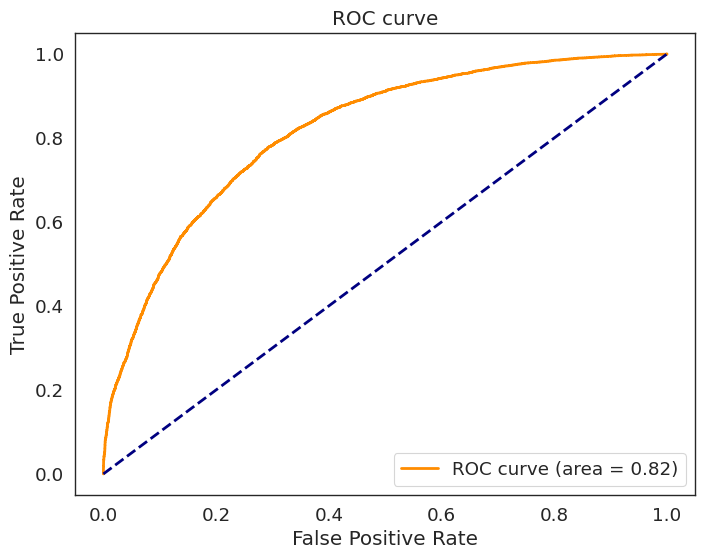

In [95]:
# visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('visuals/roc_curve_gat.png', dpi=300)
plt.show()


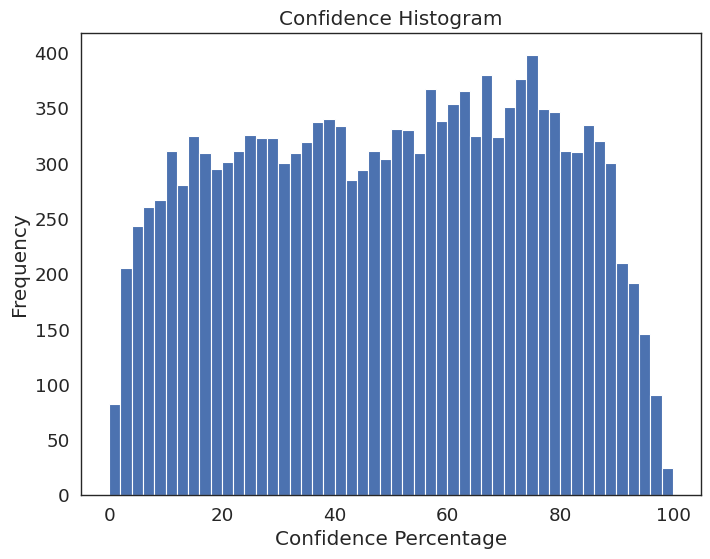

In [96]:
# visualize confidence_percentages in plot
plt.figure(figsize=(8, 6))
plt.hist(confidence_percentages, bins=50)
plt.title('Confidence Histogram')
plt.xlabel('Confidence Percentage')
plt.ylabel('Frequency')
plt.savefig('visuals/confidence_histogram_gat.png', dpi=300)
plt.show()


In [97]:
# Sort test predictions by confidence and get top 10 indices
sorted_pairs = sorted(enumerate(confidence_percentages), key=lambda x: x[1], reverse=True)
top_molecules_test_indices = [index for index, _ in sorted_pairs[:20]]

# The indices in test_graphs correspond to their positions in the original loaded_graphs_orig
# Find the original indices in loaded_graphs_orig
original_indices = [loaded_graphs_orig.index(test_graphs[i]) for i in top_molecules_test_indices]

# Use the original indices to look up the corresponding rows in reconstructed_df
top_molecule_row_indices = reconstructed_df.index[original_indices]

# Now, top_molecule_row_indices contains the DataFrame indices of the top 10 RNA-binding molecules


In [98]:
# create folder 'top_molecules' if it does not exist
if not os.path.exists('top_molecules_gat'):
    os.mkdir('top_molecules_gat')
    

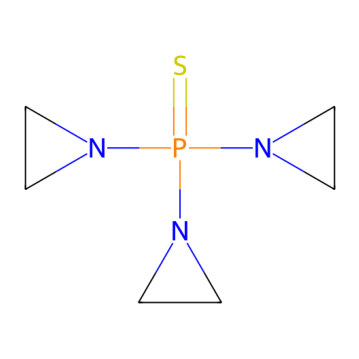

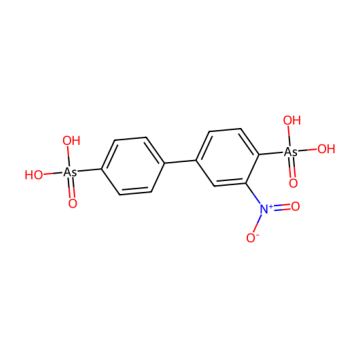

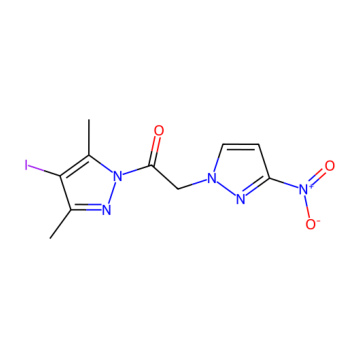

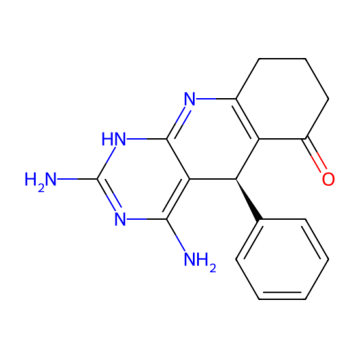

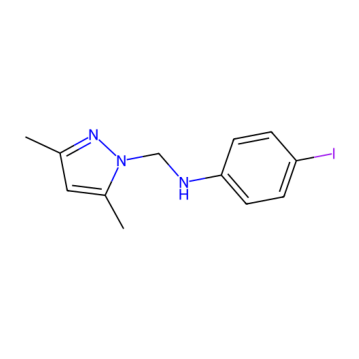

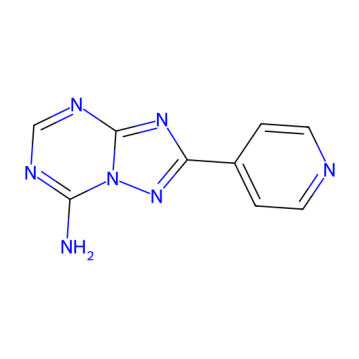

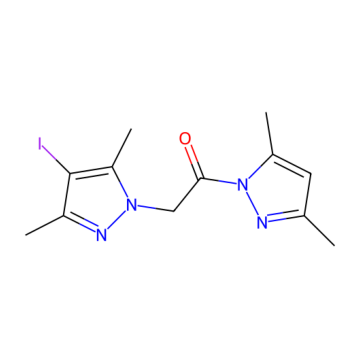

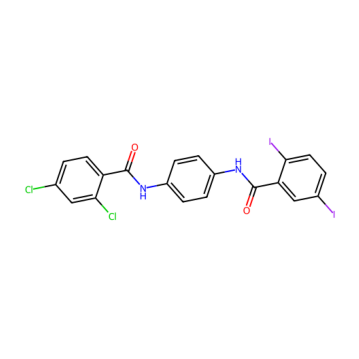

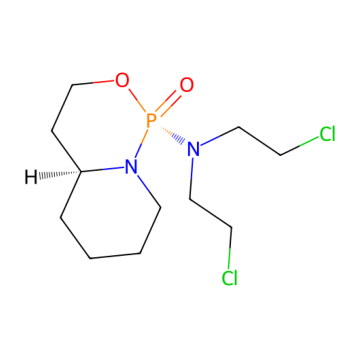

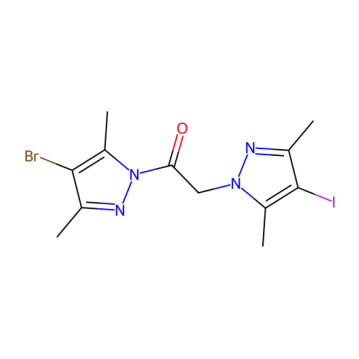

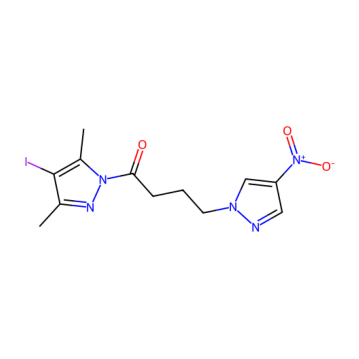

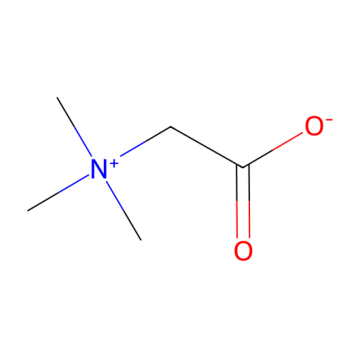

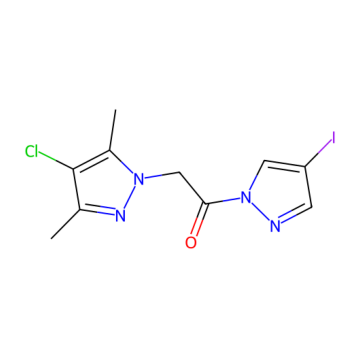

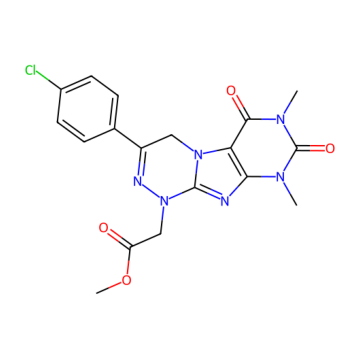

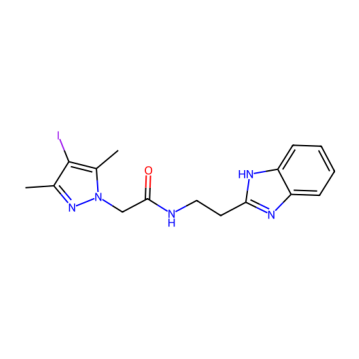

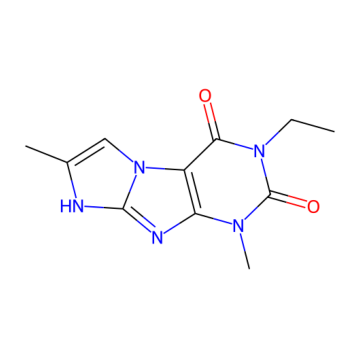

In [99]:
# Retrieve the SMILES codes and source information for the top 10 molecules
top_smiles = df_small.iloc[top_molecule_row_indices]['SMILES'].tolist()
top_sources = df_small.iloc[top_molecule_row_indices]['source'].tolist()

# Retrieve the confidence scores using the indices relative to the test dataset
top_confidences = [confidence_percentages[i] for i in top_molecules_test_indices]

# Convert SMILES to RDKit Mol objects
mols = [Chem.MolFromSmiles(smile) for smile in top_smiles]

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(500, 500))
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    # title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    # plt.title(title)
    plt.subplots_adjust(bottom=0.20)  # Adjust the position of the title
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gat/molecule_{i+1}_{top_sources[i]}_a.png", dpi=300)
    plt.show()


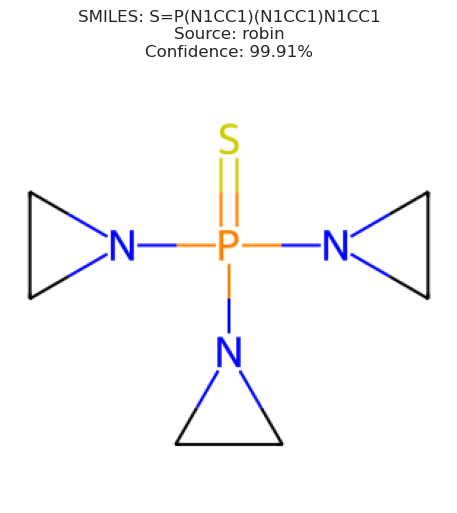

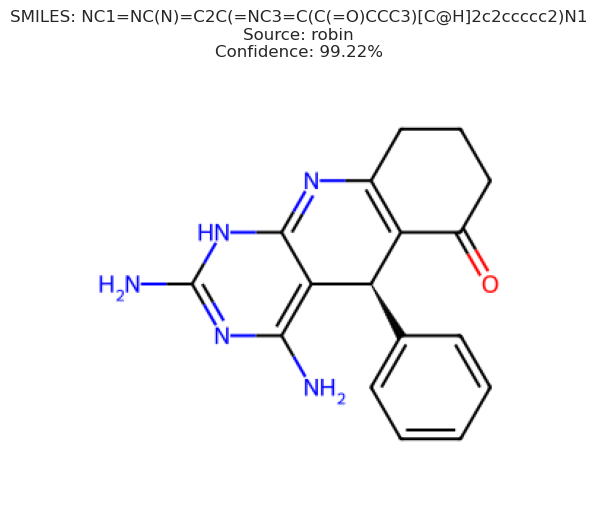

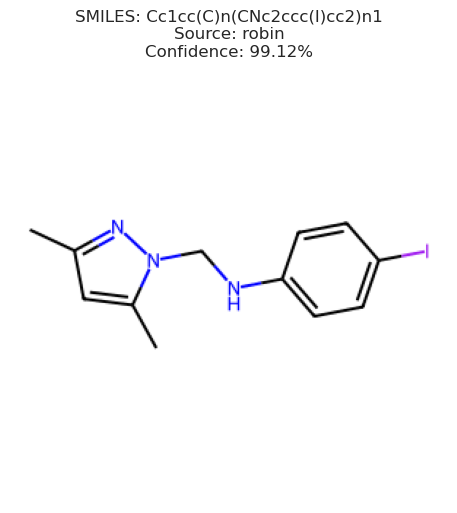

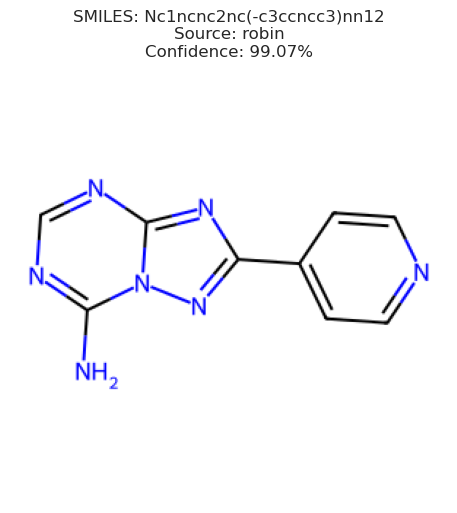

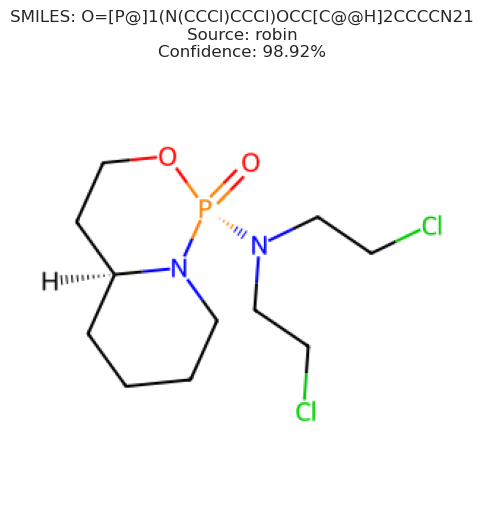

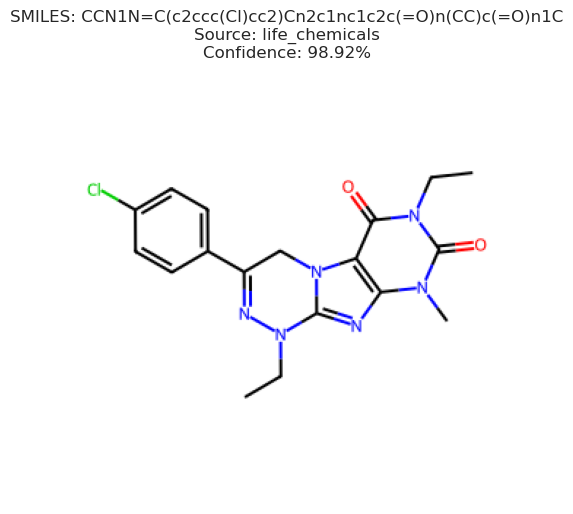

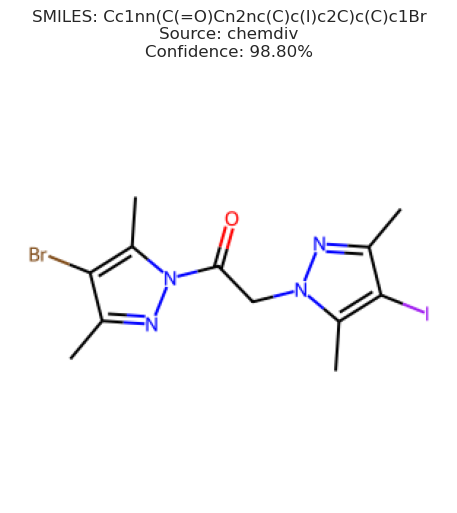

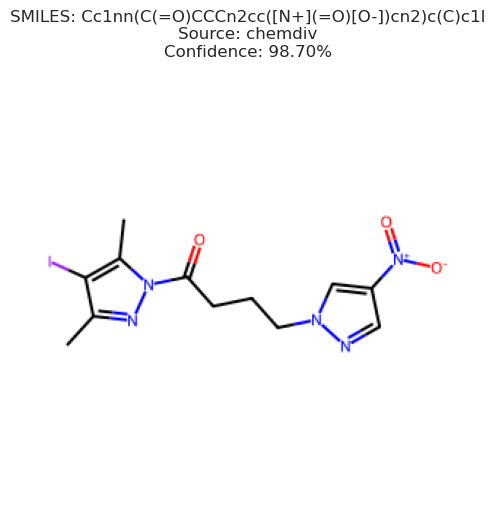

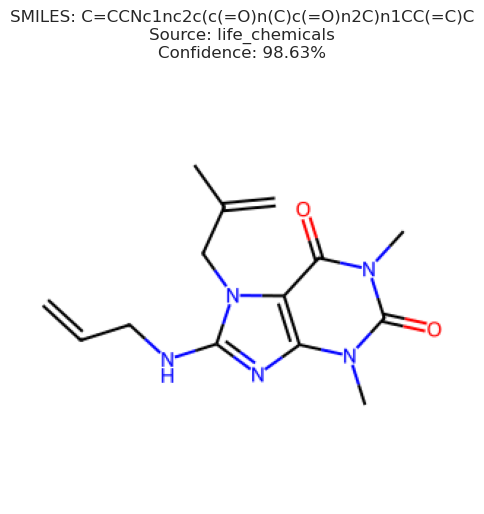

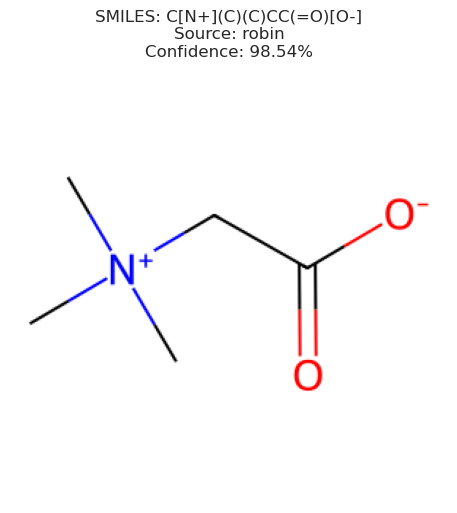

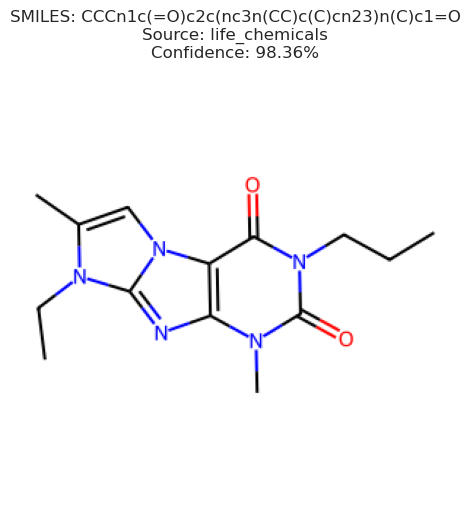

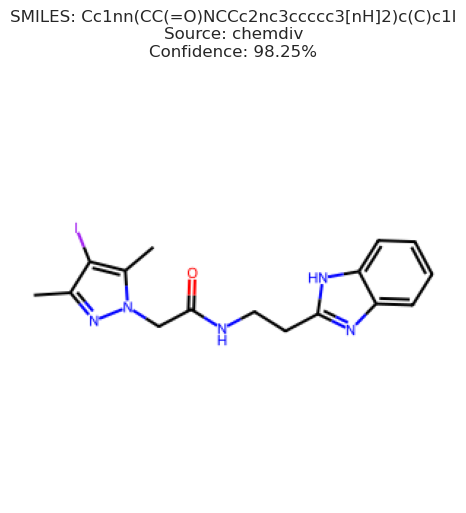

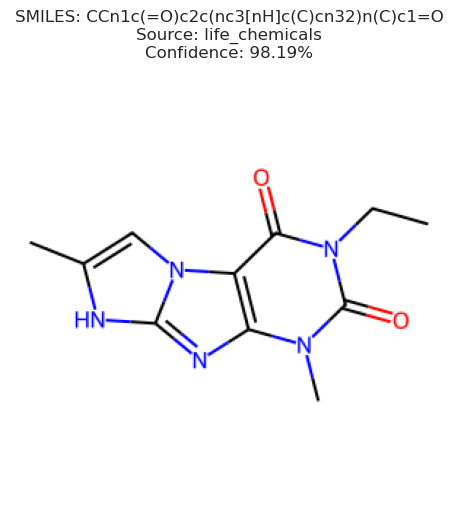

In [100]:
# Define the figure size and font size for titles
fig_size = (6, 6)
title_font_size = 12

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(300, 300))
    
    # Create a figure with adjusted size
    plt.figure(figsize=fig_size)
    plt.imshow(img)
    
    # Adjust the position of the text within the image
    title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    plt.title(title, fontsize=title_font_size)
    plt.subplots_adjust(bottom=0.15)  # Adjust the position of the title
    
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gat/molecule_{i+1}_{top_sources[i]}_b.png", dpi=300)
    plt.show()


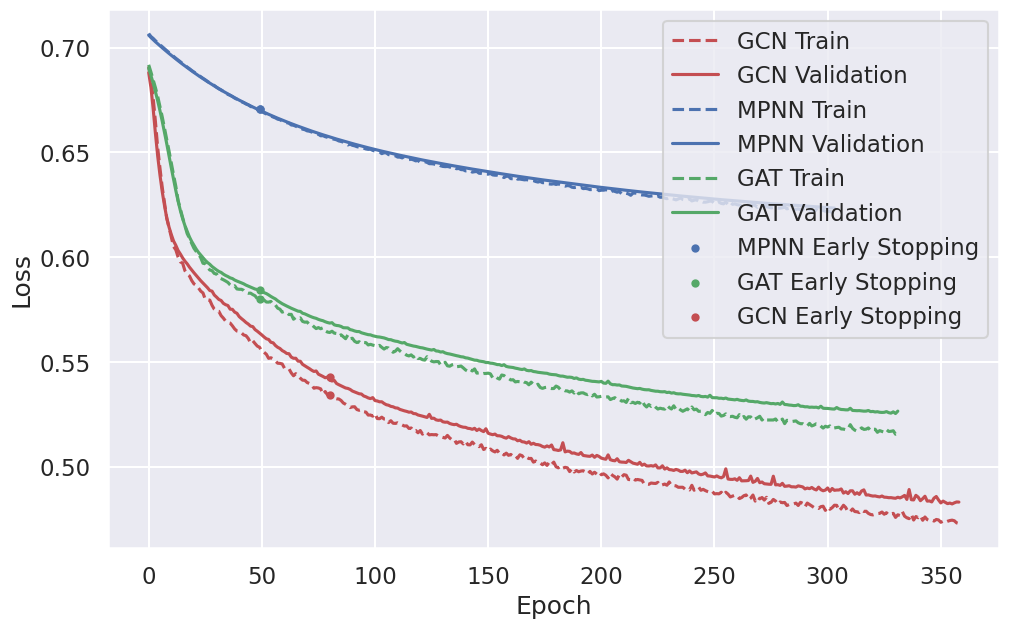

In [101]:
# Plot the training and validation loss, same model will have same color but different line style use seaborn and style report and second plot style to talk-presentation
sns.set(context='talk', rc={'figure.figsize': (11.5, 7)})

plt.plot(gcn_train_loss_list, label='GCN Train', color='r', linestyle='--')
plt.plot(gcn_val_loss_list, label='GCN Validation', color='r', linestyle='-')
plt.plot(mpnn_train_loss_list, label='MPNN Train', color='b', linestyle='--')
plt.plot(mpnn_val_loss_list, label='MPNN Validation', color='b', linestyle='-')
plt.plot(gat_train_loss_list, label='GAT Train', color='g', linestyle='--')
plt.plot(gat_val_loss_list, label='GAT Validation', color='g', linestyle='-')

# Markers for early stopping
plt.scatter(49, mpnn_train_loss_list[48], color='b', marker='o', s=20, label='MPNN Early Stopping')
plt.scatter(49, mpnn_val_loss_list[48], color='b', marker='o', s=20)
plt.scatter(49, gat_train_loss_list[48], color='g', marker='o', s=20, label='GAT Early Stopping')
plt.scatter(49, gat_val_loss_list[48], color='g', marker='o', s=20)
plt.scatter(80, gcn_train_loss_list[79], color='r', marker='o', s=20, label='GCN Early Stopping')
plt.scatter(80, gcn_val_loss_list[79], color='r', marker='o', s=20)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('visuals/loss_talk.png', dpi=300)
plt.show()


# Plot the training and validation loss, same model will have same color but different line style use seaborn and style report and second plot style to talk-presentation
sns.set(context='paper', rc={'figure.figsize': (10, 4)})


plt.plot(gcn_train_loss_list, label='GCN Train', color='r', linestyle='--')
plt.plot(gcn_val_loss_list, label='GCN Validation', color='r', linestyle='-')
plt.plot(mpnn_train_loss_list, label='MPNN Train', color='b', linestyle='--')
plt.plot(mpnn_val_loss_list, label='MPNN Validation', color='b', linestyle='-')
plt.plot(gat_train_loss_list, label='GAT Train', color='g', linestyle='--')
plt.plot(gat_val_loss_list, label='GAT Validation', color='g', linestyle='-')

# Markers for early stopping
plt.scatter(49, mpnn_train_loss_list[48], color='b', marker='o', s=20, label='MPNN Early Stopping')
plt.scatter(49, mpnn_val_loss_list[48], color='b', marker='o', s=20)
plt.scatter(49, gat_train_loss_list[48], color='g', marker='o', s=20, label='GAT Early Stopping')
plt.scatter(49, gat_val_loss_list[48], color='g', marker='o', s=20)
plt.scatter(80, gcn_train_loss_list[79], color='r', marker='o', s=20, label='GCN Early Stopping')
plt.scatter(80, gcn_val_loss_list[79], color='r', marker='o', s=20)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('visuals/loss_paper.png', dpi=300)
plt.show()


